# Twitter Sentiment Analysis of COVID-19 in the state of Virginia

## Introduction
The United States is in disarray. It started with the onset of COVID-19, an extremely contagious respiratory virus with an estimated mortality rate of 3-4% according to the World Health Organization. The rate for at-risk populations—elderly, and those with underlying conditions such as heart disease, diabetes, asthma, etc.— is much higher. Much of the country is shut down, and on March 30, 2020 Virginia Governor Ralph Northam declared a stay-at-home order until June 10th. States across the country are grappling to design a testing and tracing infrastructure before opening the economy back up. Opinions on how and when to reopen the country are varied.

The COVID-19 pandemic is going to have long-lasting impacts on our public health, economy, and way of life. From the dramatic increase in unemployment to the subsequent loneliness and depression caused by social distancing measures, the mental health impact of COVID-19 will be substantial. For my Capstone project, I am using Twitter data from Virginia to track daily sentiment toward the virus (and stay-at-home measures) as the virus travels through the state. The goal of this project is to create an auxiliary surveillance tool for the Virginia Department of Health (DOH) that uses social media data to track sentiment towards COVID-19 and the stay-at-home measures in place.

## Public Health Surveillance using Twitter Data
“Health organizations require accurate and timely disease surveillance techniques in order respond to emerging epidemics. Such information may inform planning for surges in patient visits, therapeutic supplies, and public health information dissemination campaigns.” (Broniatowski, Paul & Dredze, M, 2013.). However, real-time data collection is very expensive and simply not feasible for most organizations. As such, ongoing research continues into using social media for real-time disease and health surveillance.

Using social media data for public health surveillance is not a new idea, and in fact the Center for Disease Control and Prevention (CDC) has been using Twitter for influenza surveillance for almost a decade. The goal of this project is not to necessarily use Twitter data to estimate COVID-19 prevalence using the frequency of COVID-related Tweets as the CDC has done with influenza surveillance, though I will look to see if COVID sentiment leads or lags reported cases. The goal is broadly exploratory, aiming to monitor sentiment towards the virus and the stay-at-home measures by time and location. In addition to highlighting areas in which sentiment is particularly low (and potentially triggering investigation by the VA DOH), the idea is to set up a framework for the VA DOH to use Twitter for surveillance for the remainder of the COVID lifespan. Right now, we are looking at stay-at-home measures, but when things reopen it could be identifying COVID resurgence hot spots (via text frequency or sentiment), or measuring response towards the vaccine once available.


## Data Collection
Data was pulled daily from the Twitter application user interface (API) using the rtweet package in R. Data collection was limited to tweets posted in Virginia according to Twitter. Two daily pulls were run:
1.	COVID pull that uses the search terms: #COVID, COVID, COVID-19, #COVID-19, coronavirus, and #coronavirus. Data collection April 7th through May 22nd.
2.	Stay-at-home pull that uses the search terms: #stayhome, #stayathome, #Quarantine, quarantine, and #SocialDistancing. Data collection April 9th through May 22nd.

COVID-19 county level data (confirmed cases and deaths) was retrieved from the New York Times GitHub page (https://github.com/nytimes/covid-19-data). Additional county-level demographic data was be pulled from American Community Survey via Census.gov, and unemployment data from the Bureau of Labor Statistics. 


This notebook focuses on the Stay-at-home data only.

In [2]:
import re,string
import nltk
import pickle

from pprint import pprint
import pandas as pd
import numpy as np
import os
import matplotlib
import functools
from functools import reduce

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as pyplt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import multiprocessing
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.collections import Counter
from nltk.tokenize import TreebankWordTokenizer
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
import sklearn.linear_model 

from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import spacy

# Plotting tools
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

RANDOM = 36 # To be reproducible

# set working file
os.chdir('/Users/rachelmartonik/MSDS_498_Capstone/data')

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data - Stay-At-Home & Quarantine

I am pulling daily data from the Twitter application user interface (API) using the rtweet package in R. Data collection is limited to tweets posted in Virginia according to Twitter. Two daily pulls are run:

    1.	COVID pull that uses the search terms: #COVID, COVID, COVID-19, #COVID-19, coronavirus, and #coronavirus. Data collection started April 7th.
    2.	Stay-at-home pull that uses the search terms: #stayhome, #stayathome, #Quarantine, quarantine, and #SocialDistancing. Data collection started April 7th.

This notebook focuses on the Stay-At-Home Data Set.

In [ ]:
date_freq_df = pd.read_pickle("date_freq_df_STAY.pickle")
merged_cleaned_data = pd.read_pickle("merged_cleaned_data_final_STAY_200531.pkl")

In [74]:
# #### Read in COVID pull data ###
# # Find a more efficient way to do this
# data = pd.read_csv("va_stay_0415.csv") # started new filtering as of 4/15 - have to pull from 4/9-4/15 from this file
# data_0409 = data[data['X1']=='2020-04-09']
# data = pd.read_csv("va_stay_0415.csv") 
# data_0410 = data[data['X1']=='2020-04-10']
# data = pd.read_csv("va_stay_0415.csv") 
# data_0411 = data[data['X1']=='2020-04-11']
# data = pd.read_csv("va_stay_0415.csv") 
# data_0412 = data[data['X1']=='2020-04-12']
# data = pd.read_csv("va_stay_0415.csv") 
# data_0413 = data[data['X1']=='2020-04-13']
# data = pd.read_csv("va_stay_0415.csv") 
# data_0414 = data[data['X1']=='2020-04-14']
# data = pd.read_csv("va_stay_0415.csv") 
# data_0415 = data[data['X1']=='2020-04-15']
# data = pd.read_csv("va_stay_0416.csv") 
# data_0416 = data[data['X1']=='2020-04-16']
# data = pd.read_csv("va_stay_0417.csv") 
# data_0417 = data[data['X1']=='2020-04-17']
# data = pd.read_csv("va_stay_0418.csv") 
# data_0418 = data[data['X1']=='2020-04-18']
# data = pd.read_csv("va_stay_0419.csv") 
# data_0419 = data[data['X1']=='2020-04-19']
# data = pd.read_csv("va_stay_0420.csv") 
# data_0420 = data[data['X1']=='2020-04-20']
# data = pd.read_csv("va_stay_0421.csv") 
# data_0421 = data[data['X1']=='2020-04-21']
# data = pd.read_csv("va_stay_0422.csv") 
# data_0422 = data[data['X1']=='2020-04-22']
# data = pd.read_csv("va_stay_0423.csv") 
# data_0423 = data[data['X1']=='2020-04-23']
# data = pd.read_csv("va_stay_0424.csv") 
# data_0424 = data[data['X1']=='2020-04-24']
# data = pd.read_csv("va_stay_0425.csv") 
# data_0425 = data[data['X1']=='2020-04-25']
# data = pd.read_csv("va_stay_0426.csv") 
# data_0426 = data[data['X1']=='2020-04-26']
# data = pd.read_csv("va_stay_0427.csv") 
# data_0427 = data[data['X1']=='2020-04-27']
# data = pd.read_csv("va_stay_0429.csv") 
# data_0428 = data[data['X1']=='2020-04-28']
# data = pd.read_csv("va_stay_0429.csv") 
# data_0429 = data[data['X1']=='2020-04-29']
# data = pd.read_csv("va_stay_0430.csv") 
# data_0430 = data[data['X1']=='2020-04-30']
# data = pd.read_csv("va_stay_0501.csv") 
# data_0501 = data[data['X1']=='2020-05-01']
# data = pd.read_csv("va_stay_0502.csv") 
# data_0502 = data[data['X1']=='2020-05-02']
# data = pd.read_csv("va_stay_0503.csv") 
# data_0503 = data[data['X1']=='2020-05-03']
# data = pd.read_csv("va_stay_0504.csv") 
# data_0504 = data[data['X1']=='2020-05-04']
# data = pd.read_csv("va_stay_0505.csv") 
# data_0505 = data[data['X1']=='2020-05-05']
# data = pd.read_csv("va_stay_0506.csv") 
# data_0506 = data[data['X1']=='2020-05-06']
# data = pd.read_csv("va_stay_0507.csv") 
# data_0507 = data[data['X1']=='2020-05-07']
# data = pd.read_csv("va_stay_0508.csv") 
# data_0508 = data[data['X1']=='2020-05-08']
# data = pd.read_csv("va_stay_0509.csv") 
# data_0509 = data[data['X1']=='2020-05-09']
# data = pd.read_csv("va_stay_0510.csv") 
# data_0510 = data[data['X1']=='2020-05-10']
# data = pd.read_csv("va_stay_0511.csv") 
# data_0511 = data[data['X1']=='2020-05-11']
# data = pd.read_csv("va_stay_0512.csv") 
# data_0512 = data[data['X1']=='2020-05-12']
# data = pd.read_csv("va_stay_0513.csv") 
# data_0513 = data[data['X1']=='2020-05-13']
# data = pd.read_csv("va_stay_0514.csv") 
# data_0514 = data[data['X1']=='2020-05-14']
# data = pd.read_csv("va_stay_0515.csv") 
# data_0515 = data[data['X1']=='2020-05-15']
# data = pd.read_csv("va_stay_0516.csv") 
# data_0516 = data[data['X1']=='2020-05-16']
# data = pd.read_csv("va_stay_0517.csv") 
# data_0517 = data[data['X1']=='2020-05-17']
# data = pd.read_csv("va_stay_0518.csv") 
# data_0518 = data[data['X1']=='2020-05-18']
# data = pd.read_csv("va_stay_0519.csv") 
# data_0519 = data[data['X1']=='2020-05-19']
# data = pd.read_csv("va_stay_0520.csv") 
# data_0520 = data[data['X1']=='2020-05-20']
# data = pd.read_csv("va_stay_0521.csv") 
# data_0521 = data[data['X1']=='2020-05-21']
# data = pd.read_csv("va_stay_0522.csv") 
# data_0522 = data[data['X1']=='2020-05-22']
# data = pd.read_csv("va_stay_0523.csv") 
# data_0523 = data[data['X1']=='2020-05-23']
# data = pd.read_csv("va_stay_0524.csv") 
# data_0524 = data[data['X1']=='2020-05-24']

In [816]:
# # Get COVID related tweet frequencies
dates = [ data_0409, data_0410, data_0411, data_0412, data_0413, data_0414, data_0415, data_0416,
        data_0417, data_0418, data_0419, data_0420, data_0421, data_0422, data_0423, data_0424, data_0425,
        data_0426, data_0427, data_0428, data_0429, data_0430, data_0501, data_0502, data_0503, data_0504,
        data_0505, data_0506, data_0507, data_0508, data_0509, data_0510, data_0511, data_0512, data_0513, data_0514, 
         data_0515, data_0516, data_0517, data_0518, data_0519, data_0520, data_0521, data_0522, data_0523, data_0524]

In [817]:
date_freq = []

for date in dates:
    freq = len(date)
    date_freq.append(freq)

date_freq_df = pd.DataFrame(date_freq, columns = ['frequency'],) 

In [818]:
date_freq_df['date'] = ['4/9', '4/10', '4/11', '4/12', '4/13', '4/14', '4/15', '4/16',
                       '4/17', '4/18', '4/19', '4/20', '4/21', '4/22', '4/23', '4/24', '4/25', '4/26', '4/27', '4/28',
                       '4/29', '4/30', '5/1', '5/2', '5/3', '5/4', '5/5', '5/6', '5/7', '5/8', '5/9', '5/10',
                        '5/11', '5/12', '5/13', '5/14', '5/15', '5/16', '5/17', '5/18', '5/19', '5/20', '5/21',
                       '5/22', '5/23', '5/24']

In [819]:
date_freq_df

frequency  date
0   11343      4/9 
1   11143      4/10
2   10119      4/11
3   9394       4/12
4   9804       4/13
5   10424      4/14
6   10066      4/15
7   9891       4/16
8   9986       4/17
9   8751       4/18
10  8708       4/19
11  9208       4/20
12  8516       4/21
13  8849       4/22
14  8550       4/23
15  7830       4/24
16  6870       4/25
17  6956       4/26
18  7554       4/27
19  7482       4/28
20  7065       4/29
21  6968       4/30
22  7086       5/1 
23  5984       5/2 
24  6081       5/3 
25  6130       5/4 
26  5934       5/5 
27  5360       5/6 
28  5408       5/7 
29  5480       5/8 
30  4770       5/9 
31  4758       5/10
32  5130       5/11
33  5356       5/12
34  5401       5/13
35  5256       5/14
36  5016       5/15
37  4236       5/16
38  3880       5/17
39  4280       5/18
40  4205       5/19
41  4275       5/20
42  4115       5/21
43  3994       5/22
44  3353       5/23
45  3346       5/24

In [3]:
#date_freq_df.to_pickle("date_freq_df_STAY.pickle")

In [4]:
date_freq_df = pd.read_pickle("date_freq_df_STAY.pickle")
date_freq_df.frequency.sum()

314311

# Twitter Geolocation EDA

The goal of the project is to provide the VA DOH with low-level geographical data. The project will focus on county-level (and independent cities) data, but this sort of social media surveillance could potentially be used at even smaller areas. A major challenge is getting reliable location data. According to the Twitter website, there are three ways a tweet can be tagged with geolocation metadata:

   1.	__Geotagged by user__ – User provides exact location when issuing Tweets. While very precise, only 1-2% of Tweets are geo-tagged. (My data has less than 1%)
   2.	__Mentioned locations in tweets__ – Twitter parses tweets for location mentions. Accuracy is likely to be lower as this simply refers to a location and does not necessarily mean the user is there.
   3.	__User-reported location via profile__ – Users can report their location in their Twitter user profile. This is the largest source of location data. (99.5% of my data has this.)

The data I am pulling on a daily basis is filtered to Virginia using the Twitter API search using rtweet’s lookup_coords function. Almost all users provide a location in their user profile, however many of the locations are not in VA. Many are in DC, MD, NC, WV, among others. Some user-reported locations are not real or identifiable  (i.e. space, candy land, my house.) All this plus the open-ended nature of user location text field makes for very messy data. 

After some processing, the number of unique locations was less than 7,000 for the first 600,000 tweets collected. I cleaned the locations some more, then did a manual pass excluding any non-VA locations, and then sent the rest through the google maps API. I now have a crosswalk for all user-provided locations collected so far that maps to the 133 counties and independent cities in VA. 

In [63]:
# # use dates from above to merge all files into one raw file
# merged = pd.concat(dates, axis=0, sort=False)
# print(merged.info())
# print(merged.X1.value_counts()) # Double check counts by day are correct

In [64]:
# # Check those that gave exact coordinates of Tweet
# a = pd.DataFrame(merged.geo_coords.value_counts())
# a.drop

In [65]:
# # Calculate percentage
# gave_exact_location = len(merged) - a.iloc[0]
# print('Gave exact location/geocoords: ', gave_exact_location/ len(merged))

In [66]:
# # Check those that have location data in thier profile
# gave_user_location = merged.location.count()
# print(gave_user_location)
# print('Gave user location: ', gave_user_location/ len(merged))

In [67]:
# merged.location.value_counts()

In [68]:
# # To merge VA data sets to get a sense of scale
# # use dates from above to merge all files into one raw file
# merged_va = pd.concat(va_dates, axis=0, sort=False)
# print(merged_va.info())
# print(merged_va.X1.value_counts()) # Double check counts by day are correct

# Create Crosswalk of user-reported location names to county names

First ran on 4/25 using data as of 4/23. There were 656935 records. Collapsed "location", then cleaned it. Pulled it into excel to map to county names. Loaded into Google Maps API.

Did final clean on 5/30.

Run this again when new user-provided locations are added.

In [30]:
# # collapse location data to create county level crosswalk
# names = pd.DataFrame(merged.location.value_counts())
# names.reset_index(inplace=True)
# names.columns=['name', 'count']

In [31]:
# #create list of all texts for cleaning
# location_text=[]
# for i in range(0,len(names)):
#     temp_text=names['name'].iloc[i]
#     location_text.append(temp_text)
    
# #print(location_text)

In [32]:
# location_text_test = location_text[0:15]
# print(location_text_test)

['California, USA', 'Washington, DC', 'North Carolina, USA', 'California', 'Baltimore, MD', 'Charlotte, NC', 'Washington, USA', 'Raleigh, NC', 'Richmond, VA', 'Washington, D.C.', 'nan', 'Durham, NC', 'North Carolina', 'Washington DC', 'Arlington, VA']


In [33]:
# # Need to lowercase all locations
# # Find a more efficient way to do this!

# def clean_location(location): 
#     tokens=location.split()
#     re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
#     tokens = [re_punc.sub('', w) for w in tokens]
#     tokens = [word for word in tokens if word.isalpha()]
#     tokens = [word.lower() for word in tokens]  
#     return tokens

# location_text_lower=[]

# # Process documents - pros
# for i in location_text:
#     text=clean_location(i)
#     location_text_lower.append(text)

# location_text_lower_com = []

# for i in location_text_lower:
#     temp_DSI=" ".join(str(item) for item in i )
#     location_text_lower_com.append(temp_DSI)
    
# print(location_text[0])
# print(location_text_lower_com[0:100])

California, USA
['california usa', 'washington dc', 'north carolina usa', 'california', 'baltimore md', 'charlotte nc', 'washington usa', 'raleigh nc', 'richmond va', 'washington dc', 'nan', 'durham nc', 'north carolina', 'washington dc', 'arlington va', 'virginia beach va', 'greensboro nc', 'arkansas usa', 'new mexico usa', 'dc', 'alexandria va', 'nc', 'california', 'california', 'baltimore', 'norfolk va', 'district of columbia usa', 'charlottesville va', 'chapel hill nc', 'essex', 'morgantown wv', 'washington', 'lancaster pa', 'pluto', 'silver spring md', 'winstonsalem nc', 'arkansas', 'fayetteville nc', 'washington dc', 'md', 'narnia', 'annapolis md', 'yorkshire', 'fairfax va', 'baltimore maryland', 'chesapeake va', 'newport news va', 'cary nc', 'northern virginia', 'maryland usa', 'frederick md', 'johnson city tn', 'huntington wv', 'virginia usa', 'roanoke va', 'rockville md', 'bethesda md', 'blacksburg va', 'fredericksburg va', 'pluto', 'york pa', 'romania', 'charleston wv', 'west

In [34]:
# # Collapse again for crosswalk
# location_df = pd.DataFrame(location_text_lower_com)
# location_df.columns = ['name']
# location_df = pd.DataFrame(location_df.name.value_counts())
# location_df.to_csv('STAY_loc_names_200530.csv') # Save location names to make location crosswalk

## Load crosswalk back in to merged with cleaned locations

In [820]:
# Read in crosswalk to merge with merged df
crosswalk = pd.read_csv("un_crosswalk_working.csv") 
crosswalk.columns = ['num_index', 'location', 'county_name']
crosswalk['location'] = crosswalk['location'].astype('str')
crosswalk.drop(columns=['num_index'], inplace=True)
crosswalk.dtypes

# Create dictionary to map county names to cleaned locations
mydict = dict(zip(crosswalk.location, crosswalk.county_name))

## Clean daily data set separately for location

In [821]:
crosswalk

location      county_name
0      amen corner      accomack county
1      belle haven va   accomack county
2      bloxom virginia  accomack county
3      cashville        accomack county
4      cashville usa    accomack county
...              ...                ...
17931  ùü≠ùü∞         exclude        
17932  ùüèùüè         exclude        
17933  ùüèùüë         exclude        
17934  ùüô∆º           exclude        
17935  ùüôùüö         exclude        

[17936 rows x 2 columns]

In [822]:
def clean_location(location): 
    tokens=location.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word.lower() for word in tokens]  
    return tokens

In [823]:
# To clean locations in merged data set for crosswalk merge

#create list of all texts for cleaning
def process_location_data(data):
    data['location'] = data['location'].astype('str') 
    locs_to_clean=[]
    for i in range(0,len(data)):
        temp_text=data['location'].iloc[i]
        locs_to_clean.append(temp_text)
    
    processed_locs=[]

    for i in locs_to_clean:
        text=clean_location(i)
        processed_locs.append(text)

    final_locs = []

    for i in processed_locs:
        temp_DSI=" ".join(str(item) for item in i )
        final_locs.append(temp_DSI)
    
#     print(locs_to_clean[0:5])
#     print(final_locs[0:5])
    
    data['location_cleaned'] = np.array(final_locs) # Append cleaned location to data frame
    data['county_name']= data['location_cleaned'].map(mydict) # Add county_name using mydict county crosswalk

In [824]:
# Clean each data set
for date in dates:
    process_location_data(date)

/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

# Merge cleaned location data sets together

In [825]:
# use dates from above to merge all files into one raw file
merged = pd.concat(dates, axis=0, sort=False)
#print(merged.info())
print(merged.X1.value_counts()) # Double check counts by day are correct

2020-04-09    11343
2020-04-10    11143
2020-04-14    10424
2020-04-11    10119
2020-04-15    10066
2020-04-17    9986 
2020-04-16    9891 
2020-04-13    9804 
2020-04-12    9394 
2020-04-20    9208 
2020-04-22    8849 
2020-04-18    8751 
2020-04-19    8708 
2020-04-23    8550 
2020-04-21    8516 
2020-04-24    7830 
2020-04-27    7554 
2020-04-28    7482 
2020-05-01    7086 
2020-04-29    7065 
2020-04-30    6968 
2020-04-26    6956 
2020-04-25    6870 
2020-05-04    6130 
2020-05-03    6081 
2020-05-02    5984 
2020-05-05    5934 
2020-05-08    5480 
2020-05-07    5408 
2020-05-13    5401 
2020-05-06    5360 
2020-05-12    5356 
2020-05-14    5256 
2020-05-11    5130 
2020-05-15    5016 
2020-05-09    4770 
2020-05-10    4758 
2020-05-18    4280 
2020-05-20    4275 
2020-05-16    4236 
2020-05-19    4205 
2020-05-21    4115 
2020-05-22    3994 
2020-05-17    3880 
2020-05-23    3353 
2020-05-24    3346 
Name: X1, dtype: int64


In [826]:
merged.county_name.value_counts(dropna=False) # A lot of unknown names to be cleaned

exclude                  277026
richmond city            6442  
NaN                      3357  
virginia beach city      2629  
arlington county         2444  
fairfax county           2289  
norfolk city             2152  
alexandria city          1997  
albemarle county         1698  
loudoun county           1650  
fairfax city             764   
prince william county    747   
newport news city        731   
chesapeake city          706   
roanoke city             684   
montgomery county        625   
fredericksburg city      602   
harrisonburg city        525   
hampton city             519   
williamsburg city        473   
lynchburg city           455   
chesterfield county      455   
manassas city            338   
falls church city        306   
henrico county           265   
winchester city          254   
portsmouth city          246   
wise county              244   
suffolk city             212   
hanover county           195   
fauquier county          181   
stafford

In [827]:
# a = pd.DataFrame(merged[merged.county_name.isna()])
# b = pd.DataFrame(a.location.value_counts())
# b.to_csv("missing.csv")

In [828]:
exclude = merged[merged["county_name"]=='exclude']
exclude.location

53998    North Carolina
54022    california    
54031    california    
54065    Ashland, KY   
54067    Washington, DC
              ...      
6036     Charlotte, NC 
6037     Waldorf, MD   
6038     Knoxville, TN 
6039     Washington, DC
6040     California    
Name: location, Length: 277026, dtype: object

In [829]:
# Remove non-Virginia county_names
merged2 = merged[merged['county_name'].notna()]
merged3 = merged2[merged2['county_name']!= 'exclude']
#merged3.info()

## Tweet Frequency

In both the overall and VA data, frequency of stay-at-home related tweets is dropping over time, however, there seems to be a potential to level off this week. While weekend frequency is lower than weekdays within the same week, we do not see the same dramatic pattern that we did in the COVID data set.

In [830]:
# frequency of total tweets per day
total_freq = pd.DataFrame(merged.X1.value_counts())
total_freq.reset_index(inplace=True)

# frequency of total tweets per day
va_freq = pd.DataFrame(merged3.X1.value_counts())
va_freq.reset_index(inplace=True)

In [831]:
a = pd.DataFrame(merged3.X1.value_counts())
a.reset_index(inplace=True)
a.sort_values(by='index', ascending=True)

index    X1
0   2020-04-09  1213
1   2020-04-10  1191
9   2020-04-11  1013
10  2020-04-12  965 
6   2020-04-13  1061
4   2020-04-14  1098
3   2020-04-15  1106
5   2020-04-16  1068
2   2020-04-17  1138
11  2020-04-18  947 
13  2020-04-19  932 
7   2020-04-20  1048
14  2020-04-21  872 
8   2020-04-22  1014
12  2020-04-23  940 
15  2020-04-24  854 
22  2020-04-25  703 
21  2020-04-26  742 
18  2020-04-27  820 
16  2020-04-28  844 
20  2020-04-29  743 
19  2020-04-30  766 
17  2020-05-01  838 
24  2020-05-02  661 
25  2020-05-03  636 
23  2020-05-04  671 
27  2020-05-05  633 
28  2020-05-06  626 
26  2020-05-07  633 
29  2020-05-08  606 
35  2020-05-09  505 
36  2020-05-10  482 
33  2020-05-11  547 
32  2020-05-12  562 
31  2020-05-13  589 
30  2020-05-14  601 
34  2020-05-15  536 
38  2020-05-16  445 
42  2020-05-17  416 
40  2020-05-18  432 
37  2020-05-19  446 
41  2020-05-20  421 
39  2020-05-21  436 
43  2020-05-22  402 
45  2020-05-23  336 
44  2020-05-24  390

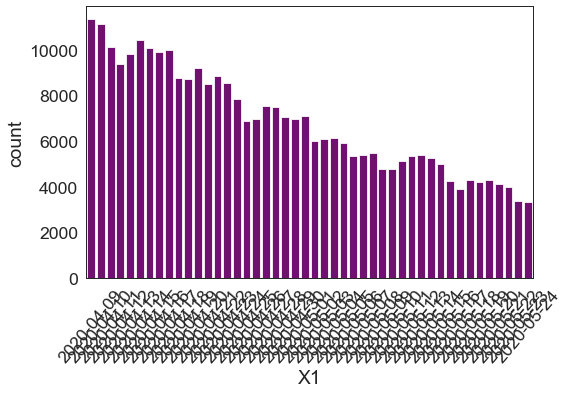

In [832]:
# Total Tweets by Day
plt.figure(figsize=(8, 5))
ax = sns.countplot(x="X1", data=merged, color="purple")
plt.setp(ax.get_xticklabels(), rotation=50);

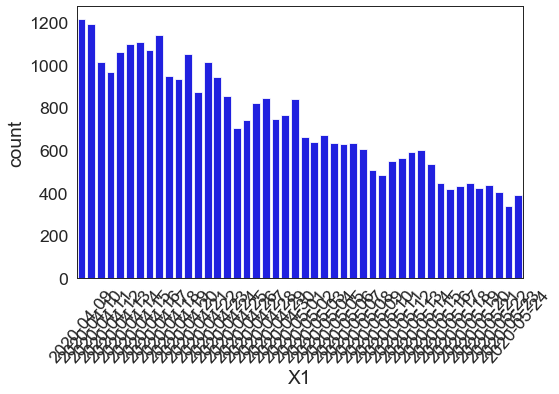

In [833]:
# VA Tweets by Day
plt.figure(figsize=(8, 5))
ax = sns.countplot(x="X1", data=merged3, color="b")
plt.setp(ax.get_xticklabels(), rotation=50);

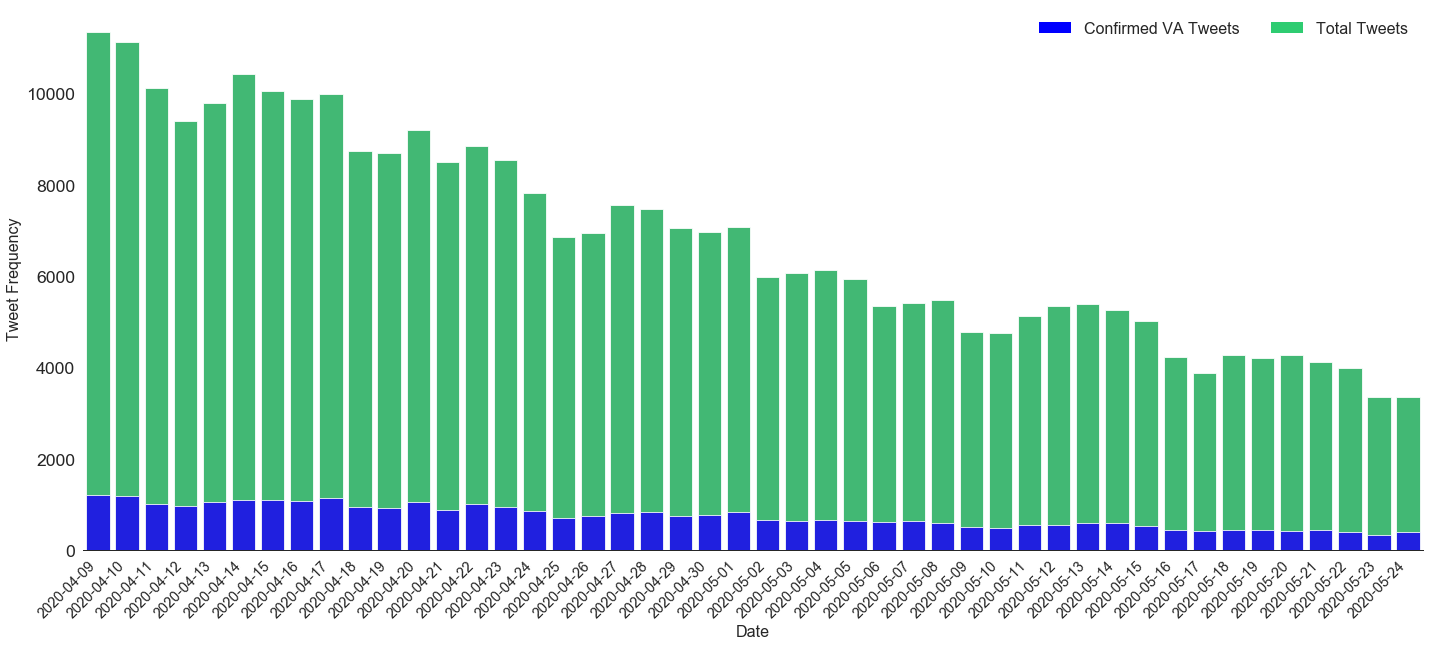

In [834]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.countplot(x="X1", data=merged, color="#2ecc71")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.countplot(x="X1", data=merged3, color="b")

topbar = plt.Rectangle((0,0),1,1,fc="#2ecc71", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='b',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Confirmed VA Tweets', 'Total Tweets'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Tweet Frequency", size=16)
bottom_plot.set_xlabel("Date", size=16)

#Set fonts to consistent 16pt size

bottom_plot.set_xticklabels(
    bottom_plot.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large');

plt.savefig("Tweet Frequency Bar Chart-STAY", tight_layout=False)
# plt.figure(figsize=(8, 5))
# plt.setp(ax.get_xticklabels(), rotation=50);


# Additional Data Processing
 - Remove non-English Tweets
 - Remove news outlets and serial Tweeters


In [836]:
# Select date to review
data = merged3
# Language distribution by daily data
print(data.lang.value_counts)

#Drop non-english tweets
data = data[data['lang'] == 'en']
#data.X1.value_counts()

<bound method IndexOpsMixin.value_counts of 54321    en
54355    en
54550    en
54645    en
54784    en
         ..
5986     en
5992     en
6003     en
6010     en
6019     en
Name: lang, Length: 33928, dtype: object>


## Twitter Account Stats

There are many accounts that belong to news outlets or folks that simply tweet news articles from thier account. The objective of this analysis is to surveil the VA general population's social media reactioss re:COVID and Stay-at-home measures, I am deleting accounts with large numbers of tweets per day.


In [837]:
# Show the frequency of users tweets
data.screen_name.value_counts()
#4060 unique usernames out of 8357 tweets
#Issue with accounts like @Ahighervision - just tweets out news articles - seems like his tweet text is 
# exactly the same as the title of article - 3% of all tweets for this data set!

whatifisaidit    109
LucyAppa         80 
LifeBeyondD      64 
ChuckeEChaves    49 
LucasFritz       48 
                 .. 
kaiisobomb       1  
MrAleoSays       1  
robertjhansen    1  
_hella_della_    1  
Lexie7898        1  
Name: screen_name, Length: 16715, dtype: int64

In [838]:
# Create username frequency dataframe
account_freq_df = pd.DataFrame(data.screen_name.value_counts())
account_freq_df
print(account_freq_df.describe())

# #Histogram of tweets per user
# plt.figure(figsize=(10, 7.5))
# ax = sns.distplot(account_freq_df.screen_name)

        screen_name
count  16715.000000
mean   1.969907    
std    2.776225    
min    1.000000    
25%    1.000000    
50%    1.000000    
75%    2.000000    
max    109.000000  


In [839]:
pd.set_option('display.max_rows', 500)
account_freq_df.head(10)

screen_name
whatifisaidit  109        
LucyAppa       80         
LifeBeyondD    64         
ChuckeEChaves  49         
LucasFritz     48         
seantubbs      46         
Festevents     45         
Dsquared75     44         
KTownStriders  44         
thewxobserver  43

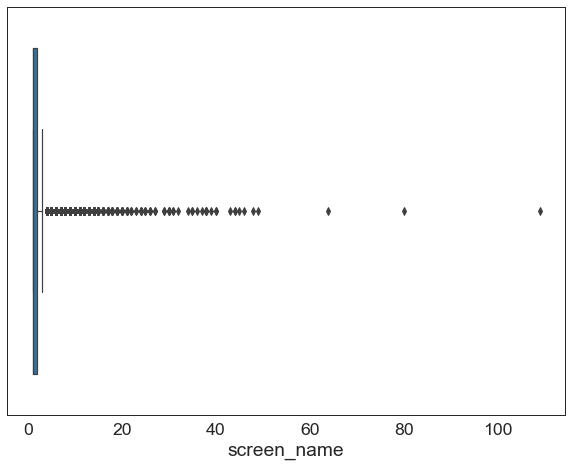

In [840]:
#Boxplot of tweets per user
plt.figure(figsize=(10, 7.5))
ax = sns.boxplot(account_freq_df.screen_name)

In [841]:
from scipy import stats
import numpy as np
account_freq_df['zscore'] = np.abs(stats.zscore(account_freq_df.screen_name))
account_freq_df.head(10)

screen_name     zscore
whatifisaidit  109          38.553544
LucyAppa       80           28.107390
LifeBeyondD    64           22.343995
ChuckeEChaves  49           16.940813
LucasFritz     48           16.580600
seantubbs      46           15.860176
Festevents     45           15.499964
Dsquared75     44           15.139752
KTownStriders  44           15.139752
thewxobserver  43           14.779539

In [842]:
# Removing outliers from data frame
top_accounts = account_freq_df[account_freq_df['zscore'] >3]
print(len(top_accounts))
top_accounts.reset_index(inplace=True)
top_accounts.head(10)

216


index  screen_name     zscore
0  whatifisaidit  109          38.553544
1  LucyAppa       80           28.107390
2  LifeBeyondD    64           22.343995
3  ChuckeEChaves  49           16.940813
4  LucasFritz     48           16.580600
5  seantubbs      46           15.860176
6  Festevents     45           15.499964
7  Dsquared75     44           15.139752
8  KTownStriders  44           15.139752
9  thewxobserver  43           14.779539

In [843]:
# Get names of outliers/frequent tweeters to delete
frequent_user_list = top_accounts['index'].tolist()
# Remove outliers/frequent tweeters from data
data = data[~data.screen_name.isin(frequent_user_list)]
len(data)

28791

## Duplicates

Even though there are no duplicate user ids, there are some tweets with the exact same content. I am deleting these for the analysis.

In [844]:
# check for duplicates
print(data.retweet_status_id.value_counts(dropna=False)) #no retweets
data.status_id.value_counts()

NaN    28791
Name: retweet_status_id, dtype: int64


x1248285123864342530    2
x1256550069236613120    1
x1258077817666965511    1
x1258131234544377861    1
x1258564855889645575    1
                       ..
x1251298749474918400    1
x1254362223687774208    1
x1248058473100779520    1
x1260180853885468673    1
x1252413840337166338    1
Name: status_id, Length: 28790, dtype: int64

In [845]:
# Select duplicate rows except first occurrence based on all columns
duplicateRowsDF = data[data.duplicated('text')]
duplicateRowsDF
dupes = pd.DataFrame(duplicateRowsDF.status_id)
dupe_list = dupes["status_id"].tolist()
len(dupe_list) #529 duplicate tweets to remove

18

In [846]:
# Remove duplicate tweets - these are not retweets - these are tweets by same user with same content
# 18 in first data set of ~8K
# 529 in data over 700K
data = data[~data.status_id.isin(dupe_list)]
len(data)

28772

In [94]:
merged_cleaned_data = data # Rename to avoid confusion
len(merged_cleaned_data)

28772

In [96]:
# # Save to file
merged_cleaned_data.to_pickle("merged_cleaned_data_final_STAY_200531.pkl")

In [332]:
merged_cleaned_data = pd.read_pickle("merged_cleaned_data_final_STAY_200531.pkl")
merged_cleaned_data.head()

user_id             status_id           created_at  \
54321  x174910916           x1248304027772891136  2020-04-09 17:37:27   
54355  x295761675           x1248290573980708864  2020-04-09 16:43:59   
54550  x136123969           x1248363319989329921  2020-04-09 21:33:03   
54645  x707817049880465408  x1248387330932523011  2020-04-09 23:08:28   
54784  x2375758213          x1248320847456153600  2020-04-09 18:44:17   

           screen_name  \
54321  JonMcLain78       
54355  engle_matthew     
54550  daniellelaundon   
54645  gwu_homo          
54784  ashxeigh          

                                                                                                                                                                                                                                                               text  \
54321  R Americans really stupid enough to think that if the curve is flattened, we can just go back to normal? C'mon! Disaster! We would be right back at square one. Let's do this until its GONE! #COVID19 #QuarantineLife #COVIDー19 #ThursdayThoughts #StayHome   
54355  Social Distancing Day 27: our 14-year old son has taken to riding his little brother’s hoverboard in circles around the house. He calls the threshold to the kitchen “The Boulder Problem.” @AlexHonnold #elcap #SocialDistancing https://t.co/EfE4qUPqSu      
54550  my number 1 quarantine position is replying to @mollyguild Instagram stories                                                                                                                                                                                   
54645  Has you mental health been negatively impacted by quarantine?                                                                                                                                                                                                  
54784  anyone in rva got ac*d i’m trying to transcend in quarantine                                                                                                                                                                                                   

                    source  display_text_width reply_to_status_id  \
54321  Twitter for Android  252                 NaN                 
54355  Twitter for iPhone   225                 NaN                 
54550  Twitter for iPhone   76                  NaN                 
54645  Twitter for iPhone   61                  NaN                 
54784  Twitter for iPhone   60                  NaN                 

      reply_to_user_id reply_to_screen_name  ...  account_lang  \
54321  NaN              NaN                  ... NaN             
54355  NaN              NaN                  ... NaN             
54550  NaN              NaN                  ... NaN             
54645  NaN              NaN                  ... NaN             
54784  NaN              NaN                  ... NaN             

                                                        profile_banner_url  \
54321  https://pbs.twimg.com/profile_banners/174910916/1585989472            
54355  https://pbs.twimg.com/profile_banners/295761675/1545686338            
54550  https://pbs.twimg.com/profile_banners/136123969/1566953178            
54645  https://pbs.twimg.com/profile_banners/707817049880465408/1584950310   
54784  https://pbs.twimg.com/profile_banners/2375758213/1586056278           

                                 profile_background_url  \
54321  http://abs.twimg.com/images/themes/theme1/bg.png   
54355  http://abs.twimg.com/images/themes/theme1/bg.png   
54550  http://abs.twimg.com/images/themes/theme1/bg.png   
54645  http://abs.twimg.com/images/themes/theme1/bg.png   
54784  http://abs.twimg.com/images/themes/theme1/bg.png   

                                                                 profile_image_url  \
54321  http://pbs.twimg.com/profile_images/1246708371220283394/XHZI5hhm_normal.jpg   
54355  http://pbs.twimg.com/profile_

# Frequency analysis

Compared to the COVID Twitter pull, the stay-at-home Twitter feed has been slowly declining since 4/9. At first glance, the Tweets seem to be coming disproportionalty from Richmond. Other cities (and FFX county) have highest frequency of tweets regarding the quarantine and social distancing. Makes sense from an urban/rural standpoint.

However, it could be affected by the number of locations I had to drop that were unknown - need to update my user provided location crosswalk. Could be missing a lot of users from lesser known locations.

Essex county is responsible for 32 times the percent of tweets compared to its population. (Essex is overrepresented in the COVID data set to a similar degree.) 

Richmond city is responsible for 18% of the entire data set, drastically overrepresenting the state’s capital.



In [5]:
df = merged_cleaned_data[['X1', 'county_name']]
a = pd.DataFrame(df.groupby(['X1', 'county_name']).size())
a.reset_index(inplace=True)
a.columns=['date', 'county_name', 'tweets_per_day']
a.head(10)

date           county_name  tweets_per_day
0  2020-04-09      albemarle county              54
1  2020-04-09       alexandria city              49
2  2020-04-09        amherst county               1
3  2020-04-09      arlington county              65
4  2020-04-09        augusta county               1
5  2020-04-09        bedford county               2
6  2020-04-09      botetourt county               2
7  2020-04-09          bristol city               2
8  2020-04-09   charles city county               1
9  2020-04-09  charlottesville city               1

In [98]:
# Stay At Home Tweet Frequency by County
import plotly.express as px 
fig = px.line(a, x="date", y="tweets_per_day", color='county_name', width=1400, height=800)
fig.update_layout(
    title=("Tweets per day by county"),
    xaxis_title="Date",
    yaxis_title="Tweets",
    font=dict(
        family="Courier New, monospace",
        size=15,
        color="#7f7f7f"))
fig.for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))
fig.show(filename='legend-names')

In [99]:
#Create a data frame with Twitter frequency by county
stay_freqs = pd.DataFrame(merged_cleaned_data.county_name.value_counts())

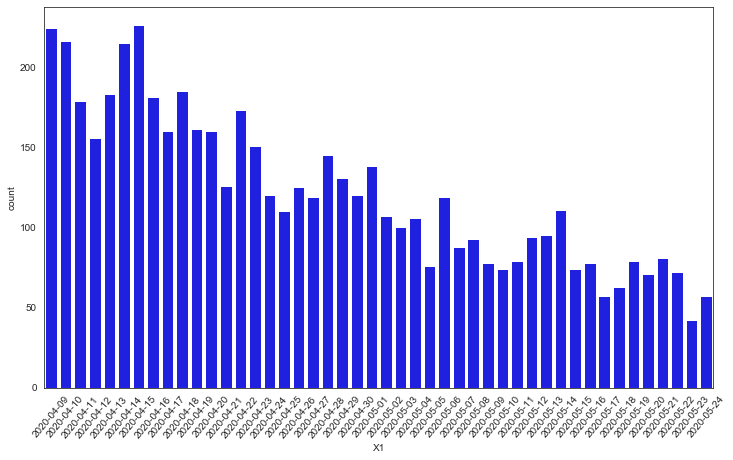

In [103]:
#Richmond only frequency
data_RVA = merged_cleaned_data[merged_cleaned_data["county_name"]=='richmond city']

plt.figure(figsize=(12, 7))
ax = sns.countplot(x="X1", data=data_RVA, color="b")
plt.setp(ax.get_xticklabels(), rotation=50);

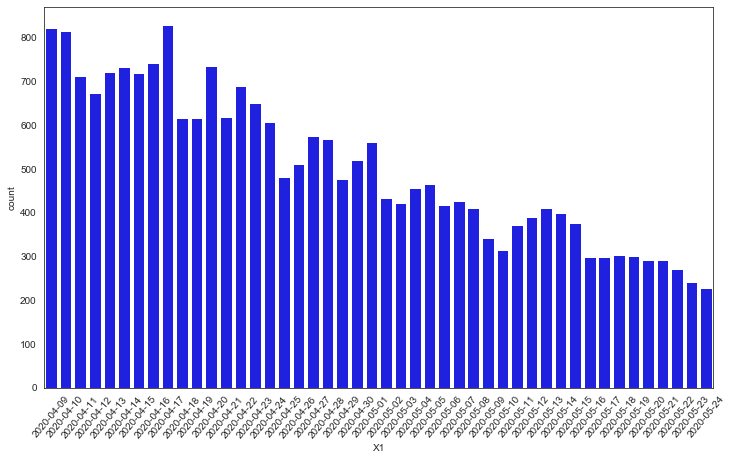

In [102]:
# Everything BUT Richmond
data_notRVA = merged_cleaned_data[merged_cleaned_data["county_name"]!='richmond city']

plt.figure(figsize=(12, 7))
ax = sns.countplot(x="X1", data=data_notRVA, color="b")
plt.setp(ax.get_xticklabels(), rotation=50);

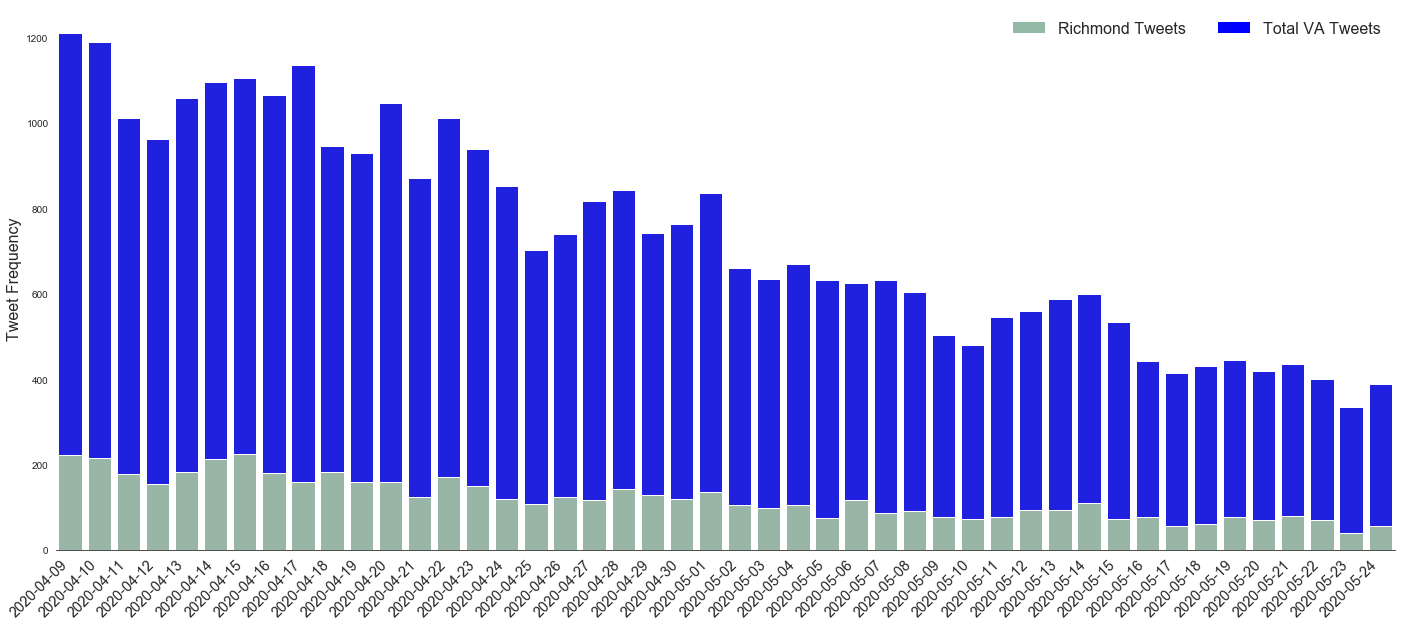

In [116]:
#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.countplot(x="X1", data=merged3, color="b")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.countplot(x="X1", data=data_RVA, color="#93baa4")

topbar = plt.Rectangle((0,0),1,1,fc="b", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#93baa4',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Richmond Tweets', 'Total VA Tweets'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Tweet Frequency", size=16)
bottom_plot.set_xlabel(" ", size=2)

#Set fonts to consistent 16pt size

bottom_plot.set_xticklabels(
    bottom_plot.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large');

plt.savefig("RVA - Tweet Frequency Bar Chart-STAY", tight_layout=False)
# plt.figure(figsize=(8, 5))
# plt.setp(ax.get_xticklabels(), rotation=50);

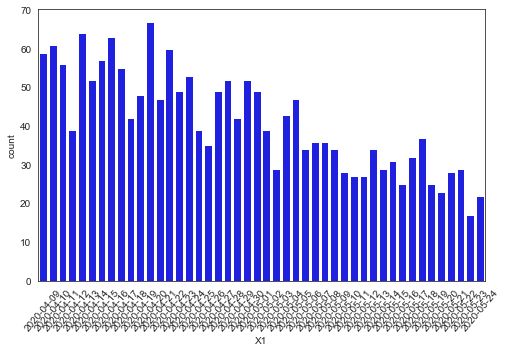

In [117]:
# Fairfax County - seems to have leveled off
data = merged_cleaned_data[merged_cleaned_data["county_name"]=='fairfax county']

plt.figure(figsize=(8, 5))
ax = sns.countplot(x="X1", data=data, color="b")
plt.setp(ax.get_xticklabels(), rotation=50);

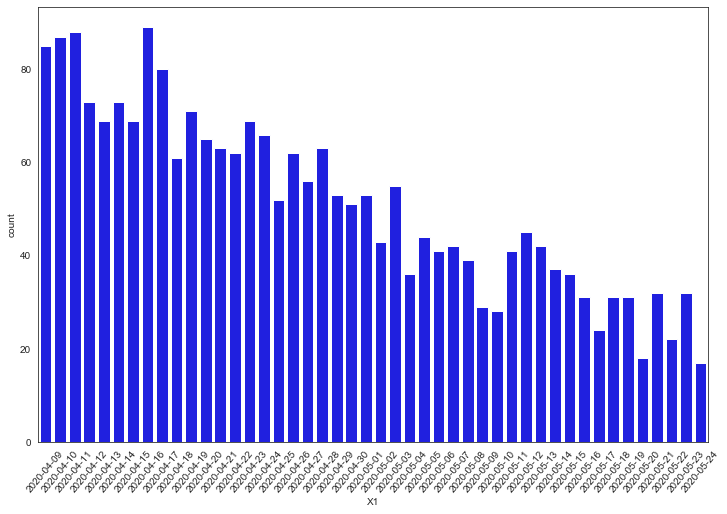

In [118]:
# Virginia Beach - seems to have leveled off
data = merged_cleaned_data[merged_cleaned_data["county_name"]=='virginia beach city']

plt.figure(figsize=(12, 8))
ax = sns.countplot(x="X1", data=data, color="b")
plt.setp(ax.get_xticklabels(), rotation=50);

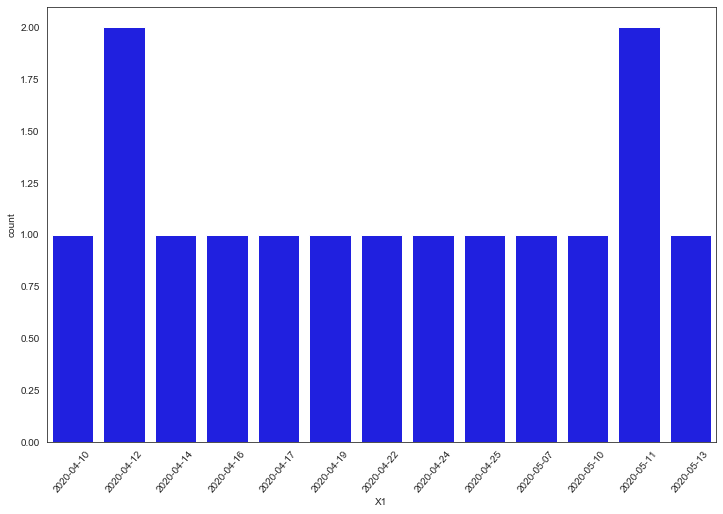

In [119]:
data = merged_cleaned_data[merged_cleaned_data["county_name"]=='essex county']

plt.figure(figsize=(12, 8))
ax = sns.countplot(x="X1", data=data, color="b")
plt.setp(ax.get_xticklabels(), rotation=50);

In [333]:
# Check to see where overall tweets are coming from compared to population distribution
g = pd.DataFrame(merged_cleaned_data.county_name.value_counts()/len(merged_cleaned_data)) # percent of total tweets
g.reset_index(inplace=True)
g.columns=['county_lower', 'percent_of_tweets']
g.head()

county_lower  percent_of_tweets
0  richmond city        0.194564         
1  virginia beach city  0.081885         
2  fairfax county       0.066106         
3  arlington county     0.060684         
4  norfolk city         0.059746

In [334]:
# Read in coutny population data
county_population = pd.read_pickle('/Users/rachelmartonik/covid/county_population.pkl')
g_population = pd.merge(county_population, g, on='county_lower')
g_population['ratio'] = g_population['percent_of_tweets']/g_population['percent_VA_pop']
g_population.to_csv('tweet to pop ratio_STAY.csv')
g_population.sort_values('percent_of_tweets', ascending=False)
g_population.rename({'county_lower': 'county_name'}, axis=1, inplace=True)

In [335]:
# Read on COVID TF by county for comparison
TotalTF_county= pd.read_pickle('TotalTF_county.pickle')
TotalTF_county.sort_values('percent', ascending=False)
TF_merged = pd.merge(TotalTF_county, g_population, on='county_name')
TF_merged.to_csv("TF_merged.csv")

# Calculate overall Sentiment Score

I did this first to create process and assess mean score by county. Later in script I get daily sentiment score by county and overall.

In [286]:
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json
import pandas as pd
import csv
import re #regular expression
from textblob import TextBlob
import string
import preprocessor as p
from nltk import sent_tokenize, word_tokenize

merged_cleaned_data.reset_index(inplace=True) # reset index so you can merge later
data = merged_cleaned_data

In [8]:
#create list of all texts for cleaning
text_body=[]
for i in range(0,len(data)):
    temp_text=data['text'].iloc[i]
    text_body.append(temp_text)
    
text_body[1:10]

TypeError: string indices must be integers

In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentences = text_body
sentences[1:10]

SyntaxError: invalid syntax (<ipython-input-9-66fd4efc1ce2>, line 3)

In [289]:
sentiment_score = []
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    sentiment_score.append(vs)

In [290]:
a = pd.DataFrame(sentiment_score)
len(a)

28772

In [291]:
# Check out a few examples
num = 65
print(text_body[num])
print(a.iloc[num])

Bruh this quarantine world ain’t that bad tbh
neg         0.3330
neu         0.6670
pos         0.0000
compound   -0.5423
Name: 65, dtype: float64


In [292]:
text_body_df = pd.DataFrame(text_body)
text_body_df.columns=['text']

In [293]:
df = pd.concat([a, text_body_df], axis=1)
df.head()

neg    neu    pos  compound  \
0  0.182  0.818  0.000 -0.8648     
1  0.000  1.000  0.000  0.0000     
2  0.000  0.885  0.115  0.0772     
3  0.000  1.000  0.000  0.0000     
4  0.000  1.000  0.000  0.0000     

                                                                                                                                                                                                                                                           text  
0  R Americans really stupid enough to think that if the curve is flattened, we can just go back to normal? C'mon! Disaster! We would be right back at square one. Let's do this until its GONE! #COVID19 #QuarantineLife #COVIDー19 #ThursdayThoughts #StayHome  
1  Social Distancing Day 27: our 14-year old son has taken to riding his little brother’s hoverboard in circles around the house. He calls the threshold to the kitchen “The Boulder Problem.” @AlexHonnold #elcap #SocialDistancing https://t.co/EfE4qUPqSu     
2  my number 1 quarantine position is replying to @mollyguild Instagram stories                                                                                                                                                                                  
3  Has you mental health been negatively impacted by quarantine?                                                                                                                                                                                                 
4  anyone in rva got ac*d i’m trying to transcend in quarantine

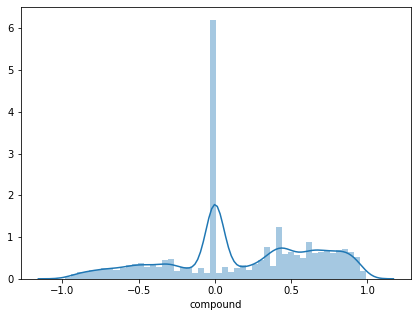

In [294]:
plt.figure(figsize=(7, 5))
ax = sns.distplot(df.compound)

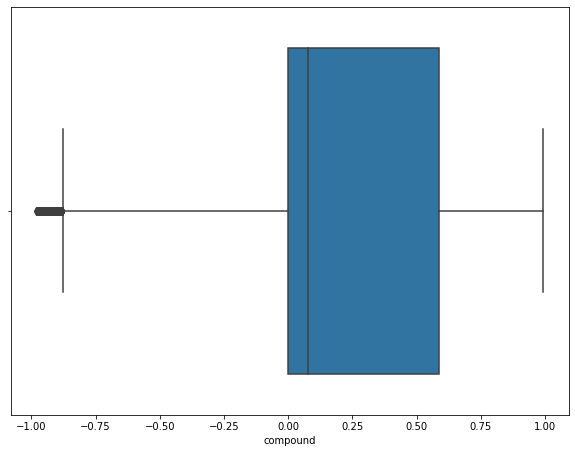

In [295]:
plt.figure(figsize=(10, 7.5))
ax = sns.boxplot(df.compound)

In [296]:
df.compound.describe()

count    28772.000000
mean     0.179102    
std      0.475835    
min     -0.981500    
25%      0.000000    
50%      0.078750    
75%      0.585900    
max      0.993800    
Name: compound, dtype: float64

In [297]:
overall_sent_STAY = pd.concat([data, df], axis=1)
overall_sent_STAY = overall_sent_STAY.loc[:,~overall_sent_STAY.columns.duplicated()]
overall_sent_STAY.to_pickle('overall_sentiment_STAY.pickle')

index               user_id             status_id           created_at  \
0      54321            x174910916  x1248304027772891136  2020-04-09 17:37:27   
1      54355            x295761675  x1248290573980708864  2020-04-09 16:43:59   
2      54550            x136123969  x1248363319989329921  2020-04-09 21:33:03   
3      54645   x707817049880465408  x1248387330932523011  2020-04-09 23:08:28   
4      54784           x2375758213  x1248320847456153600  2020-04-09 18:44:17   
...      ...                   ...                   ...                  ...   
28767   5986             x32935580  x1264349625907101697  2020-05-24 00:16:55   
28768   5992            x206283535  x1264349052755378177  2020-05-24 00:14:39   
28769   6003             x49790107  x1264347801640722442  2020-05-24 00:09:41   
28770   6010  x1221505468742410240  x1264347407757819910  2020-05-24 00:08:07   
28771   6019   x996093429246504960  x1264346786577223680  2020-05-24 00:05:39   

           screen_name                                               text  \
0          JonMcLain78  R Americans really stupid enough to think that...   
1        engle_matthew  Social Distancing Day 27: our 14-year old son ...   
2      daniellelaundon  my number 1 quarantine position is replying to...   
3             gwu_homo  Has you mental health been negatively impacted...   
4             ashxeigh  anyone in rva got ac*d i’m trying to transcend...   
...                ...                                                ...   
28767  ToraCarterMedia  One of the best parts of quarantine has been t...   
28768     waldojaquith  My kids saw both a female summer tanager and a...   
28769      AlexaMQuinn  @AmandaRafkin @evanbirnholz You need to get yo...   
28770       Nasterisk3  Nothin but Ls this quarantine season. https://...   
28771  ImpactChurchNVA  Join us for a new series with ICNOVA Online......   

                    source  display_text_width    reply_to_status_id  \
0      Twitter for Android                 252                   NaN   
1       Twitter for iPhone                 225                   NaN   
2       Twitter for iPhone                  76                   NaN   
3       Twitter for iPhone                  61                   NaN   
4       Twitter for iPhone                  60                   NaN   
...                    ...                 ...                   ...   
28767            Instagram                 240                   NaN   
28768     Tweetbot for iΟS                 199                   NaN   
28769   Twitter for iPhone                 133  x1264344151765561344   
28770  Twitter for Android                  37                   NaN   
28771            Instagram                 239                   NaN   

           reply_to_user_id  ...          X1        X2    location_cleaned  \
0                       NaN  ...  2020-04-09  17:37:27         staunton va   
1                       NaN  ...  2020-04-09  16:43:59  charlottesville va   
2                       NaN  ...  2020-04-09  21:33:03         richmond va   
3                       NaN  ...  2020-04-09  23:08:28          fairfax va   
4                       NaN  ...  2020-04-09  18:44:17         richmond va   
...                     ...  ...         ...       ...                 ...   
28767                   NaN  ...  2020-05-24  00:16:55   virginia beach va   
28768                   NaN  ...  2020-05-24  00:14:39  charlottesville va   
28769  x1123320455836852224  ...  2020-05-24  00:09:41  charlottesville va   
28770                   NaN  ...  2020-05-24  00:08:07         richmond va   
28771                   NaN  ...  2020-05-24  00:05:39          ashburn va   

               county_name  X1.1  X2.1    neg    neu    pos compound  
0            staunton city   NaN   NaN  0.182  0.818  0.000  -0.8648  
1         albemarle county   NaN   NaN  0.000  1.000  0.000   0.0000  
2            richmond city   NaN   NaN  0.000  0.885  0.115   0.0772  
3             fairfax c

In [178]:
# Check out the most negative tweets
pd.set_option('display.max_colwidth', -1)
df.sort_values('compound')[0:10]

/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


neg    neu    pos  compound  \
17299  0.633  0.367  0.000 -0.9815     
19630  0.492  0.508  0.000 -0.9801     
124    0.527  0.473  0.000 -0.9796     
15237  0.319  0.681  0.000 -0.9794     
13987  0.362  0.546  0.092 -0.9793     
13302  0.344  0.599  0.057 -0.9765     
25631  0.465  0.457  0.079 -0.9764     
28496  0.530  0.436  0.035 -0.9757     
24433  0.386  0.585  0.029 -0.9755     
22721  0.378  0.622  0.000 -0.9734     

                                                                                                                                                                                                                                                                                               text  
17299  my timeline:\n\n-rape\n-rape\n-niggas defending rapists\n-“what tf did i miss??”\n-rape\n-corona\n-quarantine \n-rape\n\n🙄💀                                                                                                                                                                   
19630  Pubg = Moba \nA lot of noobies player during this quarantine day 😭😭😭😭😭😭😭😭\nSick https://t.co/ZtV0pMPfzT                                                                                                                                                                                       
124    This quarantine is getting to meeeee omggggg 😭😭😭😭😭😭😭😭😭                                                                                                                                                                                                                                        
15237  O HELL NO! Bitches be crazy AF coming to the store with a 😷 talking she must have #coronavirus she’s so sick prolly couldn’t make it to the 🚗 😱🤬 Husband told everyone in line that she had #lupus and was a #hypochondriac that bitch tryn to get lynched #StayHome https://t.co/E0j5ndDJSv  
13987  no #Quarantine cant find a job anywhere , then #COVID19 happens and i loose my job cause there's no business , during the #Quarantine find 2 job both have to let me go cause of my criminal background, like bruh how does this shit even work 😂😂😭😭😭😭😭😭😭                                     
13302  I can’t believe I have to say this but quarantine DOES NOT = generations of your family being owned, forced to work all day, raped, tortured, murdered, &amp; generally abused every second of your life, just to have people build statues in honor of your captor in the name of “history”  
25631  I’ve been eating like shit this whole Quarantine and then got upset when the doctor weighed me today, like wtf did you think was gonna happen dumb bitch? 😭😭😭😭                                                                                                                                
28496  I coulda saved more but I spent a lot of money in quarantine too 😩😩😩😩😩😩😩😩😩😩😩                                                                                                                                                                                                                  
24433  I’ve moved on from the constantly sad part of quarantine to the straight up angry part. I am just SO angry that people are this fucking stupid. I’m angry that because of these idiots, the rest of my year will be cancelled. I’m just so angry.                                             
22721  @MilesGastonV I would send you a picture of mine, but being in Quarantine, you have no place to run awsybto, Screaming in Horror!!!!🤢🙈🙊😱😵🤤🌋🌩🦍🎃

In [179]:
# Check out the most positive tweets
pd.set_option('display.max_colwidth', -1)
df.sort_values('compound', ascending = False)[0:10]

/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


neg    neu    pos  compound  \
15365  0.000  0.353  0.647  0.9938     
5364   0.029  0.491  0.480  0.9908     
12585  0.023  0.470  0.507  0.9906     
18056  0.000  0.585  0.415  0.9887     
19946  0.000  0.550  0.450  0.9877     
26525  0.068  0.492  0.440  0.9872     
28746  0.024  0.478  0.498  0.9870     
16516  0.017  0.611  0.372  0.9855     
20685  0.000  0.569  0.431  0.9849     
23534  0.000  0.568  0.432  0.9848     

                                                                                                                                                                                                                                                                                                                 text  
15365  COMFORTABLE QUARANTINE IS A CLASS PRIVILEGE COMFORTABLE QUARANTINE IS A CLASS PRIVILEGE COMFORTABLE QUARANTINE IS A CLASS PRIVILEGE COMFORTABLE QUARANTINE IS A CLASS PRIVILEGE COMFORTABLE QUARANTINE IS A CLASS PRIVILEGE COMFORTABLE QUARANTINE IS A CLASS PRIVILEGE COMFORTABLE - https://t.co/DRbB6dItq3   
5364   week 5 of quarantine WFH has my coworkers just responding “ok” to my emails and at this point I’m not fucking responding 😊😊😊😊😊😊😊😊                                                                                                                                                                               
12585  Quarantine's got me doing crazy (but great) things, like becoming a patron of Welcome to Night Vale on @patreon!! First time supporting anyone on this platform!! I could only give that honor to the people giving me comfort and amazing stories since 2013 :) https://t.co/H7K5BKwKnJ                        
18056  Went out to some stores with my foster ma! So nice out! However, it was quite chilly! But it felt SO NICE! \n\nHow is everyone doing in quarantine? \n\nStaying safe? \n\nHow are you making the time fly by? \n\nI hope you all are staying safe and healthy! Love you all! ♥ https://t.co/H7FzFt6HBl          
19946  @kelsey_charles @megmurrrray Just finished listening to today’s pod and you guys are honestly so good at getting fun moments and tidbits out of your guests. Another great episode, I love you guys so much! Y’all are really brightening up these quarantine days 😊😊                                           
26525  PART 1 Want to be GREAT follow our great training regimen during these quarantine times. Stay ahead of next year’s competition grinding with our AVERETT WRESTLERS. ENJOY! SHARE! LIKE! COMMENT WHICH IS YOUR FAVORITE WORKOUT! 😂😂😂\n#4YearsInTheMaking #OurYearIs2021 #TeamUnit https://t.co/25zWkRTrkh        
28746  Eid Mubarak to you and your loved ones! This Ramadan in quarantine was like no other, but with generous supporters like you, @imanacares is blessed to be able to continue caring for those in need and gift them a better future. https://t.co/1NPtFitKBK                                                      
16516  Thx to all who wished me a Happy Birthday yesterday. Weird to have a bday during quarantine, but I had so many people text, call, DM and even some place orders, and that made it all so great. I love you and I appreciate you. ✌🏼🐓✌🏼\n\nhttps://t.co/olO1kBlFov                                               
20685  Good Morning Friends! Happy Tuesday! Let's play quarantine games! \n🤗\nPost a funny photo in the comments and tag someone to post one too! Whoever can make me LOL - you WIN A CASH PRIZE! 👇🏾 \n#havefun #smiletoday\n#boredinthehouse #quarantineTuesday #letshavefun #paidviacashapp https://t.co/7iL7WANWf1  
23534  How often are you laughing🤣? \n\nI'm pretty goofy so I'm laughing at myself everyday!  One of my favorite things about the quarantine is our Saturday nights comedy specials.  They say laughter is good for the soul.\n\nAre you laughing at least 5 minutes per day Beauties? https://t.co/JddhTqhYmP

In [216]:
# Merge county name
area = overall_sent_STAY[['neg', 'neu', 'pos', 'compound', 'text','county_name' ]]
area.head()

neg    neu    pos  compound  \
0  0.182  0.818  0.000 -0.8648     
1  0.000  1.000  0.000  0.0000     
2  0.000  0.885  0.115  0.0772     
3  0.000  1.000  0.000  0.0000     
4  0.000  1.000  0.000  0.0000     

                                                                                                                                                                                                                                                           text  \
0  R Americans really stupid enough to think that if the curve is flattened, we can just go back to normal? C'mon! Disaster! We would be right back at square one. Let's do this until its GONE! #COVID19 #QuarantineLife #COVIDー19 #ThursdayThoughts #StayHome   
1  Social Distancing Day 27: our 14-year old son has taken to riding his little brother’s hoverboard in circles around the house. He calls the threshold to the kitchen “The Boulder Problem.” @AlexHonnold #elcap #SocialDistancing https://t.co/EfE4qUPqSu      
2  my number 1 quarantine position is replying to @mollyguild Instagram stories                                                                                                                                                                                   
3  Has you mental health been negatively impacted by quarantine?                                                                                                                                                                                                  
4  anyone in rva got ac*d i’m trying to transcend in quarantine                                                                                                                                                                                                   

        county_name  
0  staunton city     
1  albemarle county  
2  richmond city     
3  fairfax city      
4  richmond city

In [217]:
area.county_name.value_counts()

richmond city            5598
virginia beach city      2356
fairfax county           1902
arlington county         1746
norfolk city             1719
                         ... 
bath county              4   
bland county             3   
buckingham county        3   
northumberland county    2   
james city county        1   
Name: county_name, Length: 127, dtype: int64

In [336]:
area = pd.concat([df, locations], axis=1)
area.to_pickle('overall_sentiment_STAY.pickle')
area.head()

neg    neu    pos  compound  \
0  0.182  0.818  0.000 -0.8648     
1  0.000  1.000  0.000  0.0000     
2  0.000  0.885  0.115  0.0772     
3  0.000  1.000  0.000  0.0000     
4  0.000  1.000  0.000  0.0000     

                                                                                                                                                                                                                                                           text  \
0  R Americans really stupid enough to think that if the curve is flattened, we can just go back to normal? C'mon! Disaster! We would be right back at square one. Let's do this until its GONE! #COVID19 #QuarantineLife #COVIDー19 #ThursdayThoughts #StayHome   
1  Social Distancing Day 27: our 14-year old son has taken to riding his little brother’s hoverboard in circles around the house. He calls the threshold to the kitchen “The Boulder Problem.” @AlexHonnold #elcap #SocialDistancing https://t.co/EfE4qUPqSu      
2  my number 1 quarantine position is replying to @mollyguild Instagram stories                                                                                                                                                                                   
3  Has you mental health been negatively impacted by quarantine?                                                                                                                                                                                                  
4  anyone in rva got ac*d i’m trying to transcend in quarantine                                                                                                                                                                                                   

   index       county_name  
0  0      staunton city     
1  1      albemarle county  
2  2      richmond city     
3  3      fairfax city      
4  4      richmond city

In [219]:
count = area.groupby('county_name').count()
count = pd.DataFrame(count['text'])
count.reset_index(inplace = True)
count

county_name  text
0    accomack county    19  
1    albemarle county   1419
2    alexandria city    1695
3    alleghany county   7   
4    amelia county      16  
..             ...      ..  
122  williamsburg city  364 
123  winchester city    190 
124  wise county        196 
125  wythe county       12  
126  york county        120 

[127 rows x 2 columns]

In [221]:
# To see difference between location_20 and overall_sentiment_stay
count_test = count[count['text'] > 20]
count_test.text.sum()

28196

In [222]:
# count.reset_index(drop=True, inplace = True)
# count.sort_values('text')

In [223]:
count.reset_index(drop=True, inplace = True)
count.sort_values('text')

# Map count of counties to dataframe
location_count_dict = dict(zip(count.county_name, count.text))
location_count_dict
area['count'] = area['county_name'].map(location_count_dict)

In [225]:
location = area.groupby('county_name')
print(location)

In [227]:
location = area.groupby('county_name').mean()
location.sort_values('compound', inplace=True)
location.reset_index(inplace=True)
location.head()

county_name       neg       neu       pos  compound         index  \
0  giles county        0.125250  0.850583  0.024167 -0.310958  11888.666667   
1  northampton county  0.129100  0.818500  0.052400 -0.244090  13592.000000   
2  buckingham county   0.160333  0.757667  0.082333 -0.230133  19816.000000   
3  madison county      0.105733  0.775667  0.118533 -0.052587  17451.133333   
4  roanoke county      0.121000  0.786462  0.092538 -0.051115  14283.846154   

   count  
0  12.0   
1  10.0   
2  3.0    
3  15.0   
4  13.0

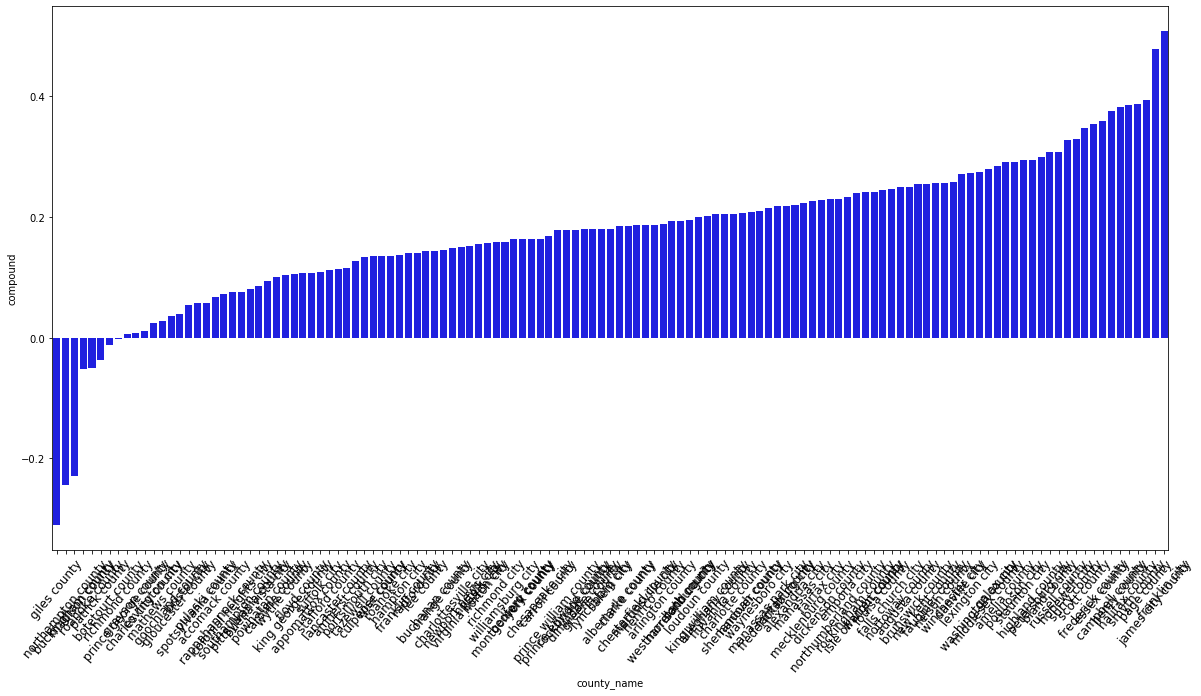

In [228]:
# Overall sentiment score by county - including all counties even with small sample sizes
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="county_name", y="compound", data=location, color="b")
plt.setp(ax.get_xticklabels(), size = 12, rotation=50);

In [229]:
location.sort_values('count', ascending=False)
location_GT20 = location[location['count']>20]
location_GT20.sort_values('compound', ascending=True)

county_name       neg       neu       pos  compound  \
8    prince george county  0.079800  0.823020  0.097260  0.005892   
14   gloucester county     0.085296  0.818185  0.096593  0.039578   
15   bristol city          0.067208  0.847188  0.085583  0.053579   
16   spotsylvania county   0.057595  0.855703  0.086784  0.057824   
22   pittsylvania county   0.071417  0.852292  0.076250  0.081221   
..                   ...        ...       ...       ...       ...   
118  frederick county      0.057524  0.760571  0.181952  0.353486   
121  henry county          0.029857  0.786381  0.183905  0.382776   
122  halifax county        0.051783  0.765565  0.182652  0.385561   
123  smyth county          0.033571  0.797524  0.168857  0.387038   
124  page county           0.046043  0.769696  0.184261  0.393309   

            index  count  
8    14052.300000  50.0   
14   11649.592593  27.0   
15   13242.500000  48.0   
16   11133.621622  37.0   
22   15398.875000  24.0   
..            ...   ...   
118  11950.333333  21.0   
121  12860.857143  21.0   
122  13527.782609  23.0   
123  12889.190476  21.0   
124  15147.608696  23.0   

[71 rows x 7 columns]

In [230]:
len(location_GT20)

71

In [231]:
location_GT20.reset_index(inplace = True) 
location_GT20.head()

level_0           county_name       neg       neu       pos  compound  \
0  8        prince george county  0.079800  0.823020  0.097260  0.005892   
1  14       gloucester county     0.085296  0.818185  0.096593  0.039578   
2  15       bristol city          0.067208  0.847188  0.085583  0.053579   
3  16       spotsylvania county   0.057595  0.855703  0.086784  0.057824   
4  22       pittsylvania county   0.071417  0.852292  0.076250  0.081221   

          index  count  
0  14052.300000  50.0   
1  11649.592593  27.0   
2  13242.500000  48.0   
3  11133.621622  37.0   
4  15398.875000  24.0

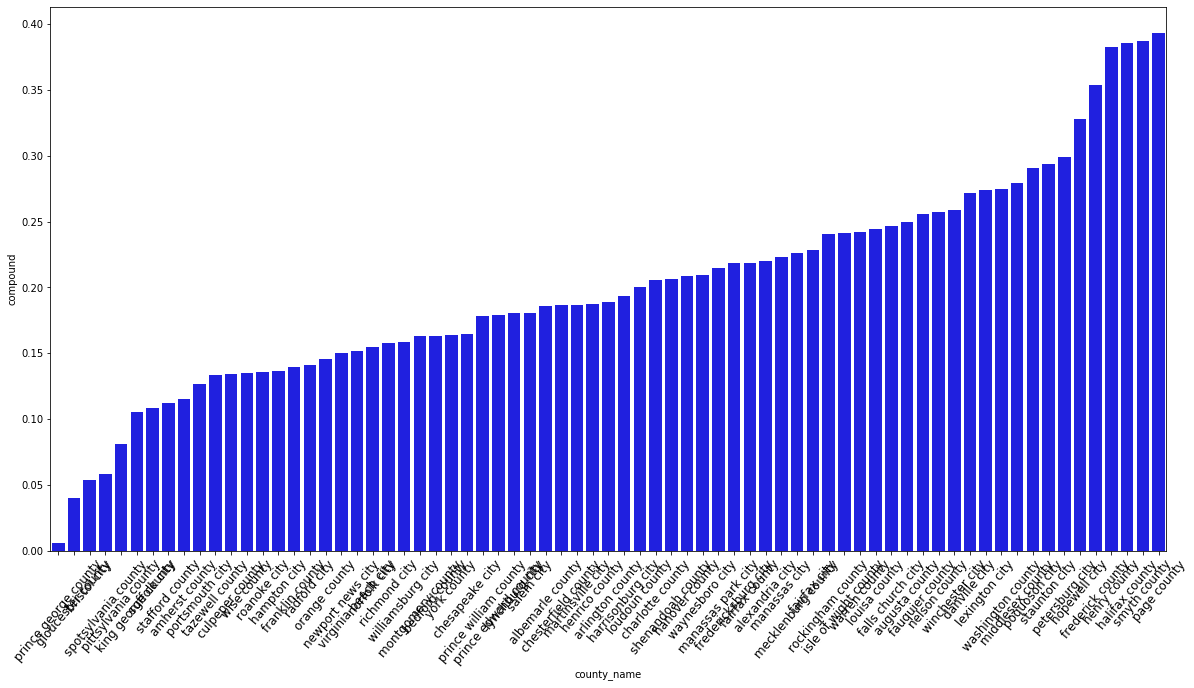

In [232]:
# Overall sentiment score by county - Removed counites with less than 20 tweets
plt.figure(figsize=(20, 10))
ax = sns.barplot(x="county_name", y="compound", data=location_GT20, color="b")
plt.setp(ax.get_xticklabels(), size=12, rotation=50);
plt.savefig("Sentiment by County - more than 20", tight_layout=False)

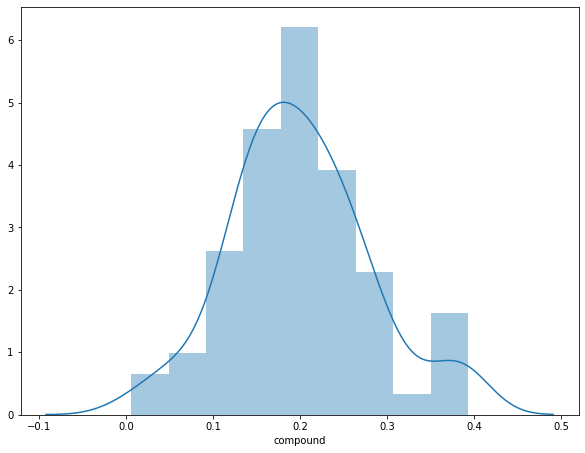

In [233]:
plt.figure(figsize=(10, 7.5))
ax = sns.distplot(location_GT20.compound)

In [234]:
location_GT20.compound.describe()

count    71.000000
mean     0.200074 
std      0.081147 
min      0.005892 
25%      0.147834 
50%      0.188614 
75%      0.245374 
max      0.393309 
Name: compound, dtype: float64

In [321]:
location_GT20 = location_GT20.sort_values('compound', ascending=False)
location_GT20.to_csv("location_GT20_STAY.csv")
location_GT20.to_pickle("location_GT20_STAY.pickle")

## Overall Sentiment by Urban vs Rural

In [322]:
# Urban and Rural areas
urban_rural = pd.read_excel('PctUrbanRural_County.xls')
urban_rural

STATE  COUNTY STATENAME      COUNTYNAME          county_name  POP_COU  \
0    51     1       Virginia  Accomack        accomack county      33164     
1    51     3       Virginia  Albemarle       albemarle county     98970     
2    51     5       Virginia  Alleghany       alleghany county     16250     
3    51     7       Virginia  Amelia          amelia county        12690     
4    51     9       Virginia  Amherst         amherst county       32353     
..   ..    ..            ...      ...                    ...         ...     
128  51     800     Virginia  Suffolk         suffolk city         84585     
129  51     810     Virginia  Virginia Beach  virginia beach city  437994    
130  51     820     Virginia  Waynesboro      waynesboro city      21006     
131  51     830     Virginia  Williamsburg    williamsburg city    14068     
132  51     840     Virginia  Winchester      winchester city      26203     

       AREA_COU  POP_URBAN  POPPCT_URBAN  AREA_URBAN  ...  POP_UC  POPPCT_UC  \
0    1164189289  0          0.00          0           ...  0       0.00        
1    1866599905  54411      54.98         72020020    ...  5527    5.58        
2    1153727336  7736       47.61         16530458    ...  7736    47.61       
3    920142596   0          0.00          0           ...  0       0.00        
4    1227484444  11756      36.34         38762867    ...  0       0.00        
..          ...    ...        ...              ...    ... ..        ...        
128  1036429624  66287      78.37         119032833   ...  0       0.00        
129  644948896   431273     98.47         349751692   ...  0       0.00        
130  38950817    20475      97.47         29112706    ...  0       0.00        
131  23366983    14068      100.00        23366983    ...  0       0.00        
132  23912611    26203      100.00        23912611    ...  0       0.00        

      AREA_UC  AREAPCT_UC  POPDEN_UC  POP_RURAL  POPPCT_RURAL  AREA_RURAL  \
0    0         0.00       NaN         33164      100.00        1164189289   
1    9035806   0.48        1584.2     44559      45.02         1794579885   
2    16530458  1.43        1212.1     8514       52.39         1137196878   
3    0         0.00       NaN         12690      100.00        920142596    
4    0         0.00       NaN         20597      63.66         1188721577   
..  ..          ...        ..           ...        ...                ...   
128  0         0.00       NaN         18298      21.63         917396791    
129  0         0.00       NaN         6721       1.53          295197204    
130  0         0.00       NaN         531        2.53          9838111      
131  0         0.00       NaN         0          0.00          0            
132  0         0.00       NaN         0          0.00          0            

     AREAPCT_RURAL  POPDEN_RURAL  
0    100.00         73.8          
1    96.14          64.3          
2    98.57          19.4          
3    100.00         35.7          
4    96.84          44.9          
..     ...           ...          
128  88.52          51.7          
129  45.77          59.0          
130  25.26          139.8         
131  0.00          NaN            
132  0.00          NaN            

[133 rows x 27 columns]

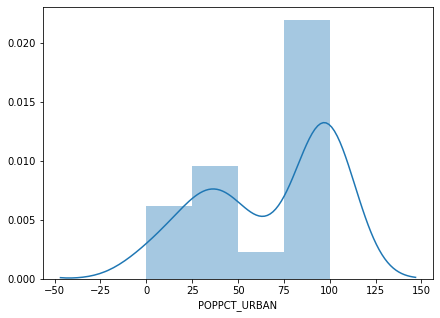

In [323]:
location_GT20_URB_RURAL = pd.merge(location_GT20, urban_rural, on='county_name')
plt.figure(figsize=(7, 5))
ax = sns.distplot(location_GT20_URB_RURAL.POPPCT_URBAN)

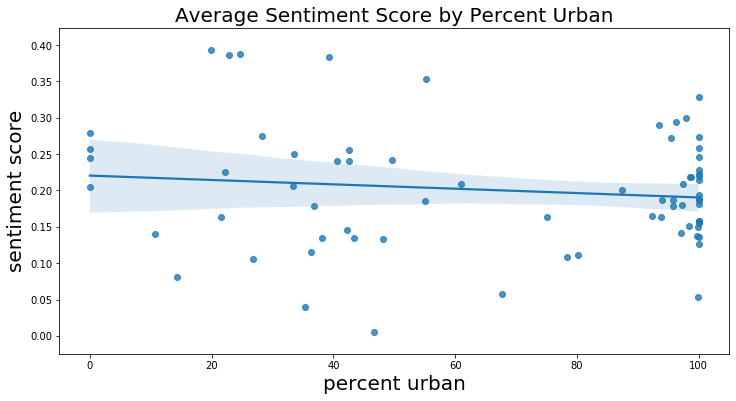

In [338]:
# Avg Weekly Sentiment Score by Percent Urban
plt.figure(figsize=(12, 6))
ax = sns.regplot(x="POPPCT_URBAN", y="compound",
                     data=location_GT20_URB_RURAL).set_title("Average Sentiment Score by Percent Urban",fontsize=20)
plt.savefig("Avg Sent by Per Urban", tight_layout=False)
plt.xlabel("percent urban", fontsize=20)
plt.ylabel("sentiment score", fontsize=20)
plt.show()

In [325]:
from scipy.stats import pearsonr
# calculate Pearson's correlation - Average overall sentiment by percent urban
corr, pvalue = pearsonr(location_GT20_URB_RURAL['compound'], location_GT20_URB_RURAL['POPPCT_URBAN'])
print(f"p-value: {pvalue}")
print('Pearsons correlation: %.3f' % corr)
# slight negative correlation but not significant

p-value: 0.2879382407340952
Pearsons correlation: -0.128


In [326]:
# Get only urban counties
location_GT20_URB_ONLY = location_GT20_URB_RURAL[location_GT20_URB_RURAL['POPPCT_URBAN'] >= 95]
# calculate Pearson's correlation - Average overall sentiment by pop density of urban areas
corr, pvalue = pearsonr(location_GT20_URB_ONLY['compound'], location_GT20_URB_ONLY['POPDEN_URBAN'])
print(f"p-value: {pvalue}")
print('Pearsons correlation: %.3f' % corr)
# slight negative correlation but not significant


p-value: 0.6611118310881055
Pearsons correlation: 0.082


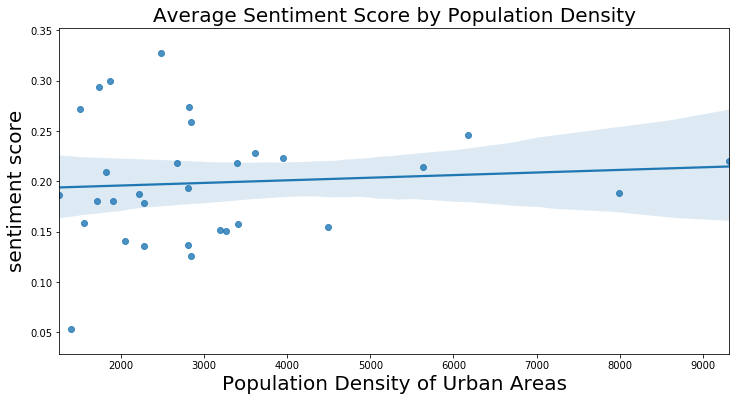

In [327]:
# Avg Weekly Sentiment Score by Percent Change
plt.figure(figsize=(12, 6))
ax = sns.regplot(x="POPDEN_URBAN", y="compound",
                     data=location_GT20_URB_ONLY).set_title("Average Sentiment Score by Population Density",fontsize=20)
#plt.savefig("Neutral Tweets", tight_layout=False)
plt.xlabel("Population Density of Urban Areas", fontsize=20)
plt.ylabel("sentiment score", fontsize=20)
plt.show()

## Overall Sentiment by March Unemployment Numbers

In [330]:
## Unemployement by County (Feb - March numbers only)
VA_employment = pd.read_excel("VA_employment_BLS_formatted.xlsx")
VA_employment.Feb_Mar_unRate_change.describe()

count    133.000000
mean     0.187242  
std      0.085341  
min      0.047619  
25%      0.140000  
50%      0.185185  
75%      0.222222  
max      0.852941  
Name: Feb_Mar_unRate_change, dtype: float64

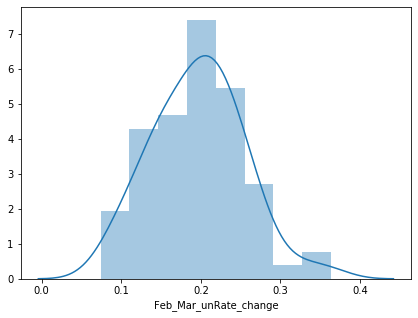

In [331]:
location_GT20_UNEMPLOYMENT = pd.merge(location_GT20, VA_employment, on='county_name')
plt.figure(figsize=(7, 5))
ax = sns.distplot(location_GT20_UNEMPLOYMENT.Feb_Mar_unRate_change)

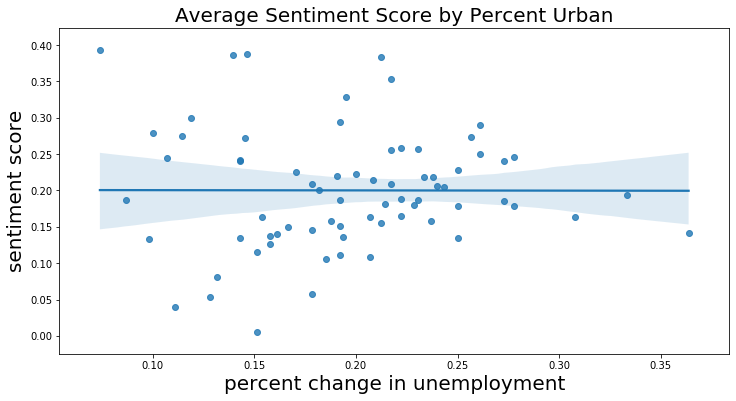

In [339]:
# Avg Weekly Sentiment Score by Percent Urban
plt.figure(figsize=(12, 6))
ax = sns.regplot(x="Feb_Mar_unRate_change", y="compound",
                     data=location_GT20_UNEMPLOYMENT).set_title("Average Sentiment Score by Change in Unemployment",fontsize=20)
plt.savefig("Avg Sent by Percent Change in Unemployment", tight_layout=False)
plt.xlabel("percent change in unemployment", fontsize=20)
plt.ylabel("sentiment score", fontsize=20)
plt.show()

In [340]:
from scipy.stats import pearsonr
corr, pvalue = pearsonr(location_GT20_UNEMPLOYMENT['Feb_Mar_unRate_change'], location_GT20_UNEMPLOYMENT['compound'])
print(f"Week 1: p-value: {pvalue} Pearsons correlation: %.3f" % corr)

Week 1: p-value: 0.9848923080450909 Pearsons correlation: -0.002


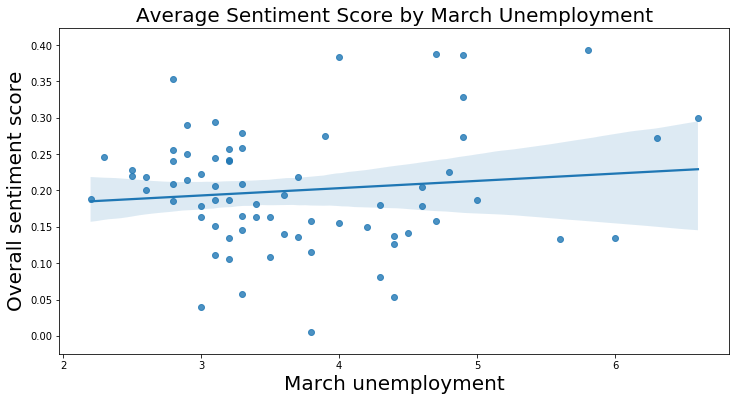

In [353]:
# Avg Weekly Sentiment Score by Percent Urban
plt.figure(figsize=(12, 6))
ax = sns.regplot(x="Mar_unRate", y="compound",
                     data=location_GT20_UNEMPLOYMENT).set_title("Average Sentiment Score by March Unemployment",fontsize=20)
plt.savefig("Avg Sent by Percent Change in Unemployment", tight_layout=False)
plt.xlabel("March unemployment", fontsize=20)
plt.ylabel("Overall sentiment score", fontsize=20)
plt.show()

In [361]:
corr, pvalue = pearsonr(location_GT20_UNEMPLOYMENT['Mar_unRate'], location_GT20_UNEMPLOYMENT['compound'])
print(f"Overall correlation: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(location_GT20_UNEMPLOYMENT['Feb_unRate'], location_GT20_UNEMPLOYMENT['compound'])
print(f"Overall correlation: p-value: {pvalue} Pearsons correlation: %.3f" % corr)

Overall correlation: p-value: 0.32280122757265484 Pearsons correlation: 0.119
Overall correlation: p-value: 0.2946652914534901 Pearsons correlation: 0.126


# Pull in COVID tracking data
Recorded cases per capita

In [202]:
##### SET DAY FOR ANALYSIS #####
day_per = '2020-05-24_per'

In [203]:
# County reported COVID cases per 1000 people
per_capita = pd.read_csv("cases_per_1000.csv") 
per_capita = per_capita[['county_lower',day_per]]#select just county_name and today's numbers
per_capita.columns=('county_name', day_per)
per_capita.head()

county_name  2020-05-24_per
0  accomack county   22.203897     
1  albemarle county  1.391566      
2  alexandria city   11.073129     
3  alleghany county  0.850451      
4  amelia county     1.633733

In [204]:
# Merge with Average Sentiment score as of today
per_capita_today = pd.merge(location_GT20, per_capita, on='county_name')
per_capita_today = per_capita_today[['county_name', 'compound', day_per]]
per_capita_today['State']="Virginia"
per_capita_today.rename(columns={'compound':'sentiment'}, inplace=True)

# Save Cases Per Capita Data set
per_capita_today.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/per_capita_today_STAY.csv")

In [205]:
per_capita_today.head()

county_name  sentiment  2020-05-24_per     State
0  page county       0.393309   7.916123        Virginia
1  smyth county      0.387038   0.482952        Virginia
2  halifax county    0.385561   0.833837        Virginia
3  henry county      0.382776   1.298752        Virginia
4  frederick county  0.353486   3.076815        Virginia

## Confirmed Cases (per 1000) as of Today & Mean Sentiment Score

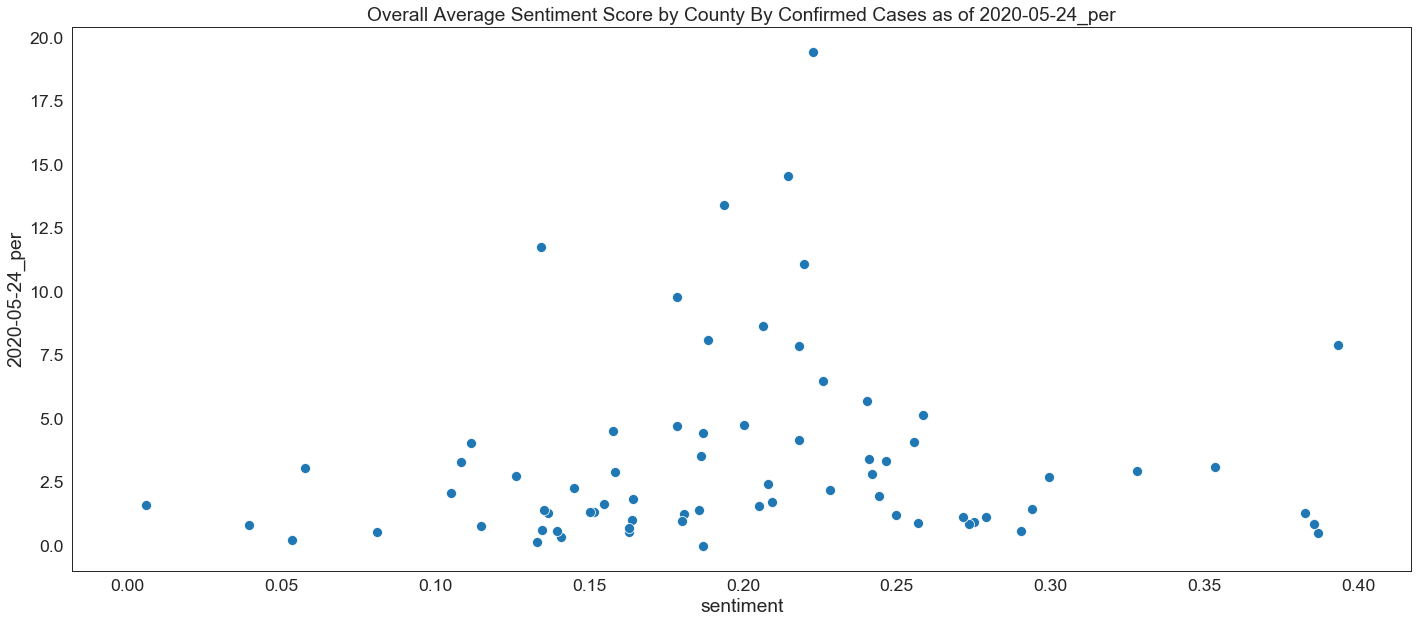

In [206]:
day = day_per
sns.set_context("paper", font_scale=2)  
ax = sns.scatterplot(x="sentiment", y=day, s=100,
                     data=per_capita_today).set_title(f'Overall Average Sentiment Score by County By Confirmed Cases as of {day}')

# Average sentiment score by confirmed COVID-19 cases as of today
# Does not seem to be relationship

In [207]:
from numpy import mean
from numpy import std
from numpy.random import randn
from numpy.random import seed
from matplotlib import pyplot
covariance = np.cov(per_capita_today[day], per_capita_today['sentiment'])
covariance

array([[1.41235003e+01, 2.59472099e-02],
       [2.59472099e-02, 6.58476415e-03]])

In [209]:
from scipy.stats import pearsonr

# calculate Pearson's correlation
corr, pvalue = pearsonr(per_capita_today[day], per_capita_today['sentiment'])
print(f"p-value: {pvalue}")
print('Pearsons correlation: %.3f' % corr)
# Low correlation between overall sentiment and daily covid cases

p-value: 0.48050643431085965
Pearsons correlation: 0.085


## Deaths as of Today & Mean Sentiment Score

In [210]:
per_capita_deaths = pd.read_csv("deaths_per_1000.csv") 
per_capita_deaths = per_capita_deaths[['county_lower', day]]#select just county_name and today's numbers
per_capita_deaths.columns=('county_name', day)
per_capita_deaths = per_capita_deaths[per_capita_deaths[day] >0]
per_capita_deaths

county_name  2020-05-24_per
0    accomack county        0.335960      
1    albemarle county       0.075220      
2    alexandria city        0.242804      
3    alleghany county       0.130839      
4    amelia county          0.077797      
7    arlington county       0.422773      
8    augusta county         0.013387      
9    bedford county         0.025671      
10   botetourt county       0.120402      
12   brunswick county       0.060006      
14   buckingham county      0.117619      
16   campbell county        0.018126      
17   caroline county        0.066260      
18   carroll county         0.033627      
19   charles city county    0.142959      
21   charlottesville city   0.063773      
22   chesapeake city        0.054663      
23   chesterfield county    0.085433      
25   colonial heights city  0.454726      
28   culpeper county        0.099108      
30   danville city          0.048179      
32   emporia city           0.557517      
34   fairfax county         0.285957      
35   fairfax city           0.125707      
36   falls church city      0.355442      
37   fauquier county        0.072343      
39   fluvanna county        0.228293      
40   franklin county        0.017783      
41   franklin city          0.121788      
42   frederick county       0.035231      
46   gloucester county      0.026910      
47   goochland county       0.222400      
49   greene county          0.051520      
50   greensville county     0.600395      
52   hampton city           0.022127      
53   hanover county         0.181907      
54   harrisonburg city      0.393325      
55   henrico county         0.362361      
56   henry county           0.038769      
59   isle of wight county   0.082481      
60   james city county      0.215770      
61   king george county     0.154500      
67   loudoun county         0.135015      
68   louisa county          0.028265      
70   lynchburg city         0.012480      
71   madison county         0.076109      
72   manassas park city     0.243561      
73   manassas city          0.168850      
75   mecklenburg county     0.648361      
77   montgomery county      0.010204      
79   new kent county        0.047387      
80   newport news city      0.055511      
81   norfolk city           0.024431      
82   northampton county     1.338128      
83   northumberland county  0.081813      
87   page county            0.884248      
89   petersburg city        0.062840      
90   pittsylvania county    0.016214      
92   portsmouth city        0.115412      
94   prince edward county   0.087123      
96   prince william county  0.183908      
100  richmond county        0.450552      
101  richmond city          0.084902      
102  roanoke county         0.053429      
103  roanoke city           0.090342      
105  rockingham county      0.075525      
107  salem city             0.117559      
108  scott county           0.090872      
109  shenandoah county      0.371704      
111  southampton county     0.111489      
112  spotsylvania county    0.038048      
113  stafford county        0.027775      
115  suffolk city           0.325258      
116  surry county           0.151515      
117  sussex county          0.087063      
119  virginia beach city    0.042210      
120  warren county          0.050698      
121  washington county      0.073521      
124  williamsburg city      0.202867      
125  winchester city        0.035985      
126  wise county            0.051249      
127  wythe county           0.034554      
128  york county            0.044387

In [211]:
per_capita_deaths_today = pd.merge(location_GT20, per_capita_deaths, on='county_name')
per_capita_deaths_today = per_capita_deaths_today[['county_name', 'compound', day]]
per_capita_deaths_today['State']="Virginia"
per_capita_deaths_today.rename(columns={'compound':'sentiment'}, inplace=True)
# Save Cases Per Capita Data set
per_capita_deaths_today.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/per_capita_deaths_today_STAY.csv")

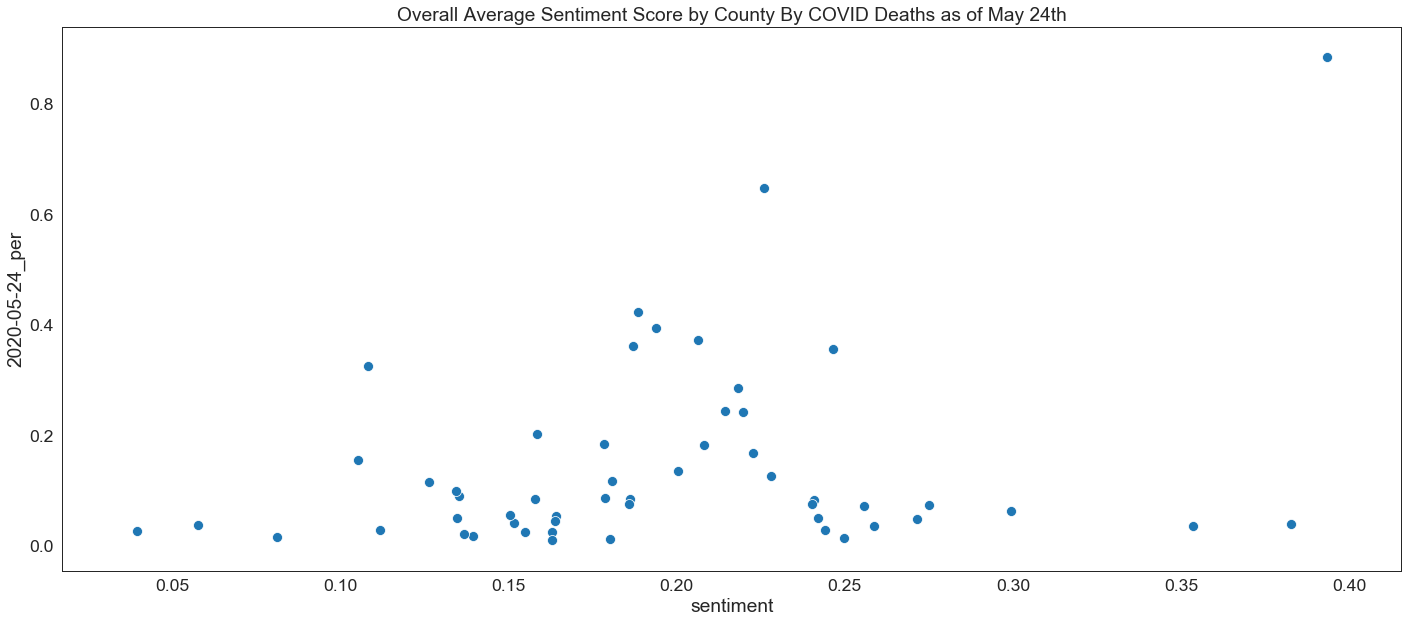

In [214]:
day = day_per
sns.set_context("paper", font_scale=2)  
ax = sns.scatterplot(x="sentiment", y=day, s=100,
                     data=per_capita_deaths_today).set_title(f'Overall Average Sentiment Score by County By COVID Deaths as of May 24th')

In [213]:
from scipy.stats import pearsonr

# calculate Pearson's correlation
corr, pvalue = pearsonr(per_capita_deaths_today[day], per_capita_deaths_today['sentiment'])
print(f"p-value: {pvalue}")
print('Pearsons correlation: %.3f' % corr)
# Sentiment towards Stay-at-home measures postively correlated with deaths as of 5/24
# Check to see if that holds on a daily basis

p-value: 0.030763905401273915
Pearsons correlation: 0.297


# Geographical Areas for Analysis

There is just not enough data to track sentiment in a meaninful way accross all counties. Lets look at regions instead:

    1 - Northern Virginia
    2 - Greater Richmond Area
    3 - Hampton Roads Area
    4 - Rest of State

In [42]:
# # Save to file
merged_cleaned_data = pd.read_pickle("merged_cleaned_data_final_STAY_200531.pkl")
len(merged_cleaned_data)

28772

In [43]:
# Geographical Definitions for Analysis
region_xwalk = pd.read_csv('county_names_region.csv')
region_xwalk.head()

county_name_lower  region
0   accomack county       4
1  albemarle county       4
2  alleghany county       4
3     amelia county       2
4    amherst county       4

In [44]:
# Create dictionary to map county names to cleaned locations
mydict = dict(zip(region_xwalk.county_name_lower, region_xwalk.region))
# Map region names to merged cleaned data
merged_cleaned_data['region']= merged_cleaned_data['county_name'].map(mydict) # Add county_name using mydict county crosswalk

In [40]:
# # Create separate regional data sets for DSS
# merged_cleaned_data = merged_cleaned_data[merged_cleaned_data['region']==1]
# merged_cleaned_data.region.value_counts()

## Frequency by Region

In [35]:
# merged_cleaned_data = merged_cleaned_data[merged_cleaned_data['region']==1]
# nova_freq = pd.DataFrame(merged_cleaned_data.groupby('X1').count())
# nova_freq = nova_freq['user_id']
# nova_freq.columns=('NoVa')
# nova_freq

In [36]:
merged_cleaned_data = merged_cleaned_data[merged_cleaned_data['region']==2]
rva_freq = pd.DataFrame(merged_cleaned_data.groupby('X1').count())
rva_freq = rva_freq['user_id']
rva_freq.columns=('RVA')
rva_freq

X1
2020-04-09    250
2020-04-10    251
2020-04-11    212
2020-04-12    183
2020-04-13    205
2020-04-14    241
2020-04-15    250
2020-04-16    216
2020-04-17    201
2020-04-18    222
2020-04-19    186
2020-04-20    196
2020-04-21    146
2020-04-22    198
2020-04-23    171
2020-04-24    139
2020-04-25    127
2020-04-26    152
2020-04-27    142
2020-04-28    161
2020-04-29    153
2020-04-30    139
2020-05-01    162
2020-05-02    126
2020-05-03    126
2020-05-04    132
2020-05-05    100
2020-05-06    138
2020-05-07    107
2020-05-08    116
2020-05-09     96
2020-05-10     92
2020-05-11     89
2020-05-12    115
2020-05-13    108
2020-05-14    132
2020-05-15     86
2020-05-16     95
2020-05-17     78
2020-05-18     81
2020-05-19     92
2020-05-20     79
2020-05-21     90
2020-05-22     82
2020-05-23     49
2020-05-24     62
Name: user_id, dtype: int64

In [41]:
merged_cleaned_data = merged_cleaned_data[merged_cleaned_data['region']==3]
Hampton_freq = pd.DataFrame(merged_cleaned_data.groupby('X1').count())
Hampton_freq = Hampton_freq['user_id']
Hampton_freq.columns=('HR')
Hampton_freq

X1
2020-04-09    250
2020-04-10    235
2020-04-11    222
2020-04-12    216
2020-04-13    209
2020-04-14    202
2020-04-15    196
2020-04-16    219
2020-04-17    217
2020-04-18    173
2020-04-19    189
2020-04-20    185
2020-04-21    163
2020-04-22    170
2020-04-23    190
2020-04-24    165
2020-04-25    135
2020-04-26    157
2020-04-27    147
2020-04-28    180
2020-04-29    123
2020-04-30    130
2020-05-01    138
2020-05-02    111
2020-05-03    126
2020-05-04    109
2020-05-05    118
2020-05-06    108
2020-05-07    113
2020-05-08    104
2020-05-09     87
2020-05-10     81
2020-05-11    113
2020-05-12     97
2020-05-13    101
2020-05-14     94
2020-05-15     85
2020-05-16     76
2020-05-17     78
2020-05-18     78
2020-05-19     78
2020-05-20     63
2020-05-21     83
2020-05-22     68
2020-05-23     73
2020-05-24     59
Name: user_id, dtype: int64

In [49]:
merged_cleaned_data = merged_cleaned_data[merged_cleaned_data['region']==4]
else_freq = pd.DataFrame(merged_cleaned_data.groupby('X1').count())
else_freq = else_freq['user_id']
else_freq.columns=('HR')
else_freq

X1
2020-04-09    264
2020-04-10    234
2020-04-11    219
2020-04-12    199
2020-04-13    223
2020-04-14    237
2020-04-15    218
2020-04-16    222
2020-04-17    252
2020-04-18    198
2020-04-19    198
2020-04-20    248
2020-04-21    206
2020-04-22    220
2020-04-23    198
2020-04-24    192
2020-04-25    143
2020-04-26    153
2020-04-27    177
2020-04-28    172
2020-04-29    135
2020-04-30    141
2020-05-01    169
2020-05-02    130
2020-05-03    124
2020-05-04    146
2020-05-05    156
2020-05-06    124
2020-05-07    120
2020-05-08    121
2020-05-09     89
2020-05-10    102
2020-05-11    112
2020-05-12    108
2020-05-13    118
2020-05-14    115
2020-05-15    113
2020-05-16     83
2020-05-17     71
2020-05-18     90
2020-05-19     86
2020-05-20     89
2020-05-21     91
2020-05-22     92
2020-05-23     55
2020-05-24     69
Name: user_id, dtype: int64

In [59]:
# nova_freq = nova_freq.to_frame()
# nova_freq.columns=["nova"]
rva_freq = rva_freq.to_frame()
rva_freq.columns=["rva"]
Hampton_freq = Hampton_freq.to_frame()
Hampton_freq.columns=["HR"]
else_freq = else_freq.to_frame()
else_freq.columns=["else"]

In [64]:
#Combine to one data set
region_freq = pd.concat([nova_freq,rva_freq], axis=1)
region_freq = pd.concat([region_freq,Hampton_freq], axis=1)
region_freq = pd.concat([region_freq,else_freq], axis=1)
region_freq.reset_index(inplace=True)
region_freq

X1  nova  rva   HR  else
0   2020-04-09   283  250  250   264
1   2020-04-10   312  251  235   234
2   2020-04-11   239  212  222   219
3   2020-04-12   232  183  216   199
4   2020-04-13   267  205  209   223
5   2020-04-14   269  241  202   237
6   2020-04-15   281  250  196   218
7   2020-04-16   266  216  219   222
8   2020-04-17   319  201  217   252
9   2020-04-18   209  222  173   198
10  2020-04-19   205  186  189   198
11  2020-04-20   266  196  185   248
12  2020-04-21   229  146  163   206
13  2020-04-22   276  198  170   220
14  2020-04-23   243  171  190   198
15  2020-04-24   231  139  165   192
16  2020-04-25   187  127  135   143
17  2020-04-26   175  152  157   153
18  2020-04-27   228  142  147   177
19  2020-04-28   200  161  180   172
20  2020-04-29   197  153  123   135
21  2020-04-30   230  139  130   141
22  2020-05-01   232  162  138   169
23  2020-05-02   173  126  111   130
24  2020-05-03   147  126  126   124
25  2020-05-04   175  132  109   146
26  2020-05-05   169  100  118   156
27  2020-05-06   167  138  108   124
28  2020-05-07   176  107  113   120
29  2020-05-08   163  116  104   121
30  2020-05-09   149   96   87    89
31  2020-05-10   113   92   81   102
32  2020-05-11   136   89  113   112
33  2020-05-12   165  115   97   108
34  2020-05-13   179  108  101   118
35  2020-05-14   169  132   94   115
36  2020-05-15   167   86   85   113
37  2020-05-16   122   95   76    83
38  2020-05-17   128   78   78    71
39  2020-05-18   118   81   78    90
40  2020-05-19   124   92   78    86
41  2020-05-20   132   79   63    89
42  2020-05-21   110   90   83    91
43  2020-05-22   102   82   68    92
44  2020-05-23   106   49   73    55
45  2020-05-24    96   62   59    69

In [70]:
name_change_dict = {"2020-04-07": "04-07",
                    "2020-04-08": "04-08",
                    "2020-04-09": "04-09",
                    "2020-04-10": "04-10",
                    "2020-04-11": "04-11",
                    "2020-04-12": "04-12",
                    "2020-04-13": "04-13",
                    "2020-04-14": "04-14",
                    "2020-04-15": "04-15",
                    "2020-04-16": "04-16",
                    "2020-04-17": "04-17",
                    "2020-04-18": "04-18",
                    "2020-04-19": "04-19",
                    "2020-04-20": "04-20",
                    "2020-04-21": "04-21",
                    "2020-04-22": "04-22",
                    "2020-04-23": "04-23",
                    "2020-04-24": "04-24",
                    "2020-04-25": "04-25",
                    "2020-04-26": "04-26",
                    "2020-04-27": "04-27",
                    "2020-04-28": "04-28",
                    "2020-04-29": "04-29",
                    "2020-04-30": "04-30",
                    "2020-05-01": "05-01",
                    "2020-05-02": "05-02",
                    "2020-05-03": "05-03",
                    "2020-05-04": "05-04",
                    "2020-05-05": "05-05",
                    "2020-05-06": "05-06",
                    "2020-05-07": "05-07",
                    "2020-05-08": "05-08", 
                    "2020-05-09": "05-09", 
                    "2020-05-10": "05-10", 
                    "2020-05-11": "05-11", 
                    "2020-05-12": "05-12", 
                    "2020-05-13": "05-13", 
                    "2020-05-14": "05-14",
                    "2020-05-15": "05-15", 
                    "2020-05-16": "05-16", 
                    "2020-05-17": "05-17", 
                    "2020-05-18": "05-18", 
                    "2020-05-19": "05-19", 
                    "2020-05-20": "05-20", 
                    "2020-05-21": "05-21", 
                    "2020-05-22": "05-22", 
                    "2020-05-23": "05-23", 
                    "2020-05-24": "05-24", 
                   }
              

region_freq['date'] = region_freq['X1'].map(name_change_dict)

In [72]:
region_freq.head()

X1  nova  rva   HR  else   date
0  2020-04-09   283  250  250   264  04-09
1  2020-04-10   312  251  235   234  04-10
2  2020-04-11   239  212  222   219  04-11
3  2020-04-12   232  183  216   199  04-12
4  2020-04-13   267  205  209   223  04-13

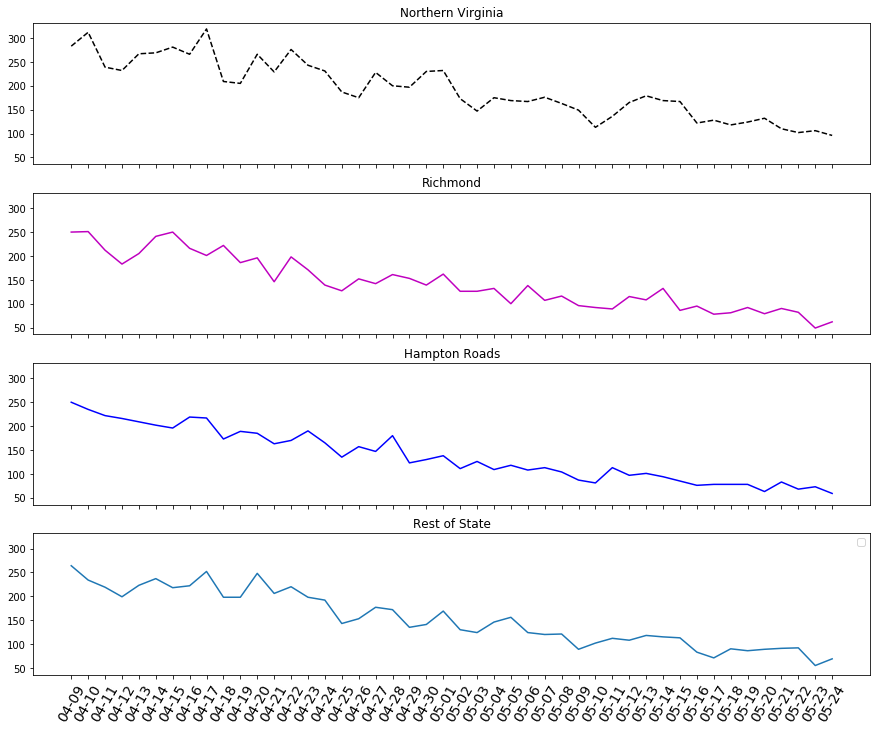

In [73]:
# Plot Regional DSS Overtime
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True, figsize=(15,12))
ax1.plot(region_freq['date'], region_freq['nova'], '--', color='black')
ax1.set_title('Northern Virginia')
ax2.plot(region_freq['date'], region_freq['rva'], 'm-')
ax2.set_title('Richmond')
ax3.plot(region_freq['date'], region_freq['HR'], 'b-')
ax3.set_title('Hampton Roads')
ax4.plot(region_freq['date'], region_freq['else'], '-')
ax4.set_title('Rest of State')
plt.xlabel(' '); plt.xticks(rotation=60, size=14)

plt.legend()
plt.savefig('Frequency by Region', tight_layout=False)


# Daily Sentiment Data

In [528]:
# Pull individual daily data sets from cleaned merged data
data_0409_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-09']
data_0410_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-10']
data_0411_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-11']
data_0412_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-12']
data_0413_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-13']
data_0414_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-14']
data_0415_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-15']
data_0416_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-16']
data_0417_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-17']
data_0418_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-18']
data_0419_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-19']
data_0420_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-20']
data_0421_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-21']
data_0422_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-22']
data_0423_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-23']
data_0424_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-24']
data_0425_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-25']
data_0426_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-26']
data_0427_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-27']
data_0428_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-28']
data_0429_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-29']
data_0430_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-30']
data_0501_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-01']
data_0502_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-02']
data_0503_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-03']
data_0504_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-04']
data_0505_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-05']
data_0506_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-06']
data_0507_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-07']
data_0508_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-08']
data_0509_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-09']
data_0510_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-10']
data_0511_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-11']
data_0512_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-12']
data_0513_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-13']
data_0514_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-14']
data_0515_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-15']
data_0516_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-16']
data_0517_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-17']
data_0518_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-18']
data_0519_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-19']
data_0520_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-20']
data_0521_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-21']
data_0522_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-22']
data_0523_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-23']
data_0524_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-24']

In [529]:
# LIST OF DAILY DATA SETS TO PROCESS
dates_cleaned = [data_0409_clean, data_0410_clean, data_0411_clean, data_0412_clean,
                data_0413_clean, data_0414_clean, data_0415_clean, data_0416_clean, data_0417_clean, data_0418_clean, 
                 data_0419_clean, data_0420_clean, data_0421_clean, data_0422_clean, data_0423_clean, data_0424_clean, 
                 data_0425_clean, data_0426_clean, data_0427_clean, data_0428_clean, data_0429_clean, data_0430_clean,
                data_0501_clean, data_0502_clean, data_0503_clean, data_0504_clean, data_0505_clean, data_0506_clean, 
                 data_0507_clean, data_0508_clean, data_0509_clean, data_0510_clean, data_0511_clean, data_0512_clean,
                data_0513_clean, data_0514_clean, data_0515_clean, data_0516_clean, data_0517_clean, data_0518_clean,
                 data_0519_clean, data_0520_clean, data_0521_clean, data_0522_clean, data_0523_clean, data_0524_clean]

In [530]:
# for i in dates_cleaned:
#     print(len(i))

In [531]:
#create list of all texts for cleaning
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
daily_score_list = [] # Create blank daily score list

# For each daily data set, process tweet sentiment
def process_daily_sentiment(data):
        
    text_body=[] #Loop through tweet to prepare for sentiment analysis
    for i in range(0,len(data)):
        temp_text=data['text'].iloc[i]
        text_body.append(temp_text)
    
    sentences = text_body # Sentiment analysis

    
    sentiment_score = [] # Append sentiment analysis results to a list
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        sentiment_score.append(vs)
    
    daily = pd.DataFrame(sentiment_score)
    score = daily.compound.mean() #prepare mean VA sentiment score
    daily_score_list.append(score)
    return daily_score_list   

In [532]:
for date in dates_cleaned:
    process_daily_sentiment(date)

In [533]:
#daily_score_list

In [534]:
date_labels = ['4/9', '4/10', '4/11', '4/12', '4/13', '4/14', '4/15', '4/16',
                       '4/17', '4/18', '4/19', '4/20', '4/21', '4/22', '4/23', '4/24', '4/25', '4/26', '4/27',
              '4/28', '4/29', '4/30', '5/1', '5/2', '5/3', '5/4', '5/5', '5/6', '5/7', '5/8', '5/9', '5/10',
              '5/11', '5/12', '5/13', '5/14', '5/15', '5/16', '5/17', '5/18', '5/19', '5/20', '5/21', '5/22',
              '5/23', '5/24']

In [535]:
daily_sentiment_STAYHOME = pd.DataFrame(list(zip(date_labels, daily_score_list)), 
               columns =['Date', 'Sentiment_Score']) 

# Save to file
#daily_sentiment_STAYHOME.to_pickle("daily_sentiment_STAYHOME.pickle")

In [11]:
daily_sentiment_STAYHOME = pd.read_pickle("daily_sentiment_STAYHOME.pickle")
daily_sentiment_STAYHOME

Date  Sentiment_Score
0    4/9         0.144032
1   4/10         0.194061
2   4/11         0.134525
3   4/12         0.216664
4   4/13         0.159334
5   4/14         0.181931
6   4/15         0.206674
7   4/16         0.156706
8   4/17         0.179988
9   4/18         0.167936
10  4/19         0.160195
11  4/20         0.136255
12  4/21         0.165507
13  4/22         0.174196
14  4/23         0.164421
15  4/24         0.173466
16  4/25         0.210907
17  4/26         0.169324
18  4/27         0.177626
19  4/28         0.160767
20  4/29         0.188674
21  4/30         0.216284
22   5/1         0.214415
23   5/2         0.221647
24   5/3         0.145851
25   5/4         0.188194
26   5/5         0.236661
27   5/6         0.195102
28   5/7         0.149463
29   5/8         0.220576
30   5/9         0.168425
31  5/10         0.156106
32  5/11         0.231066
33  5/12         0.192468
34  5/13         0.190642
35  5/14         0.188619
36  5/15         0.199197
37  5/16         0.163286
38  5/17         0.194807
39  5/18         0.162815
40  5/19         0.193500
41  5/20         0.178525
42  5/21         0.156045
43  5/22         0.194576
44  5/23         0.135653
45  5/24         0.187822

In [536]:
daily_sentiment_STAYHOME.Sentiment_Score.describe()

count    46.000000
mean     0.180542 
std      0.025982 
min      0.134525 
25%      0.161279 
50%      0.179256 
75%      0.194749 
max      0.236661 
Name: Sentiment_Score, dtype: float64

In [12]:
# # Save files
# daily_sentiment_STAYHOME_Regions.to_pickle('daily_sentiment_STAYHOME_Regions.pickle')
# daily_sentiment_STAYHOME_Regions.to_csv('daily_sentiment_STAYHOME_Regions.csv')

aily_sentiment_STAYHOME_Regions = pd.read_pickle('daily_sentiment_STAYHOME_Regions.pickle')
aily_sentiment_STAYHOME_Regions

Date      NOVA       RVA  Hampton Roads  Rest of State
0    4/9  0.185170  0.110796       0.087444       0.184995
1   4/10  0.247522  0.163901       0.169756       0.179541
2   4/11  0.113933  0.124291       0.096652       0.205296
3   4/12  0.254005  0.164384       0.204494       0.234418
4   4/13  0.183151  0.122112       0.134644       0.188177
5   4/14  0.233727  0.150745       0.146027       0.185456
6   4/15  0.214827  0.219540       0.165095       0.218794
7   4/16  0.163093  0.174284       0.121499       0.166681
8   4/17  0.203626  0.184748       0.150096       0.172007
9   4/18  0.204868  0.139868       0.177343       0.152202
10  4/19  0.201974  0.084119       0.194383       0.155772
11  4/20  0.164352  0.117800       0.106787       0.142688
12  4/21  0.178300  0.155484       0.169369       0.155334
13  4/22  0.220373  0.150725       0.090993       0.201682
14  4/23  0.149940  0.156221       0.163068       0.190576
15  4/24  0.155776  0.185858       0.149927       0.206005
16  4/25  0.213562  0.184114       0.172547       0.267442
17  4/26  0.166819  0.169105       0.175608       0.165959
18  4/27  0.186777  0.195356       0.154326       0.170964
19  4/28  0.172658  0.101784       0.183775       0.178072
20  4/29  0.242219  0.159157       0.155090       0.174588
21  4/30  0.207138  0.183931       0.237268       0.243749
22   5/1  0.253099  0.156359       0.233593       0.201301
23   5/2  0.281749  0.198362       0.161117       0.215917
24   5/3  0.168805  0.198051       0.095410       0.116852
25   5/4  0.256879  0.183406       0.125508       0.156994
26   5/5  0.312234  0.151979       0.195272       0.240381
27   5/6  0.189549  0.164553       0.213759       0.220331
28   5/7  0.221240  0.153892       0.089208       0.096981
29   5/8  0.226557  0.178738       0.291781       0.191427
30   5/9  0.140185  0.195164       0.189815       0.165953
31  5/10  0.188435  0.185365      -0.005698       0.222393
32  5/11  0.282822  0.231016       0.180162       0.219619
33  5/12  0.230819  0.174980       0.061119       0.270469
34  5/13  0.200661  0.218481       0.184260       0.155424
35  5/14  0.248327  0.151732       0.179733       0.150477
36  5/15  0.246568  0.203943       0.163787       0.152213
37  5/16  0.211016  0.191193       0.107328       0.112427
38  5/17  0.247660  0.210632       0.179328       0.099142
39  5/18  0.234933  0.153157       0.097335       0.133702
40  5/19  0.213168  0.181798       0.177385       0.192276
41  5/20  0.128963  0.246915       0.260733       0.133136
42  5/21  0.233634  0.146053       0.103665       0.119914
43  5/22  0.259837  0.174215       0.073003       0.230228
44  5/23  0.173549  0.123984       0.144236       0.061620
45  5/24  0.248060  0.101550       0.161458       0.204075

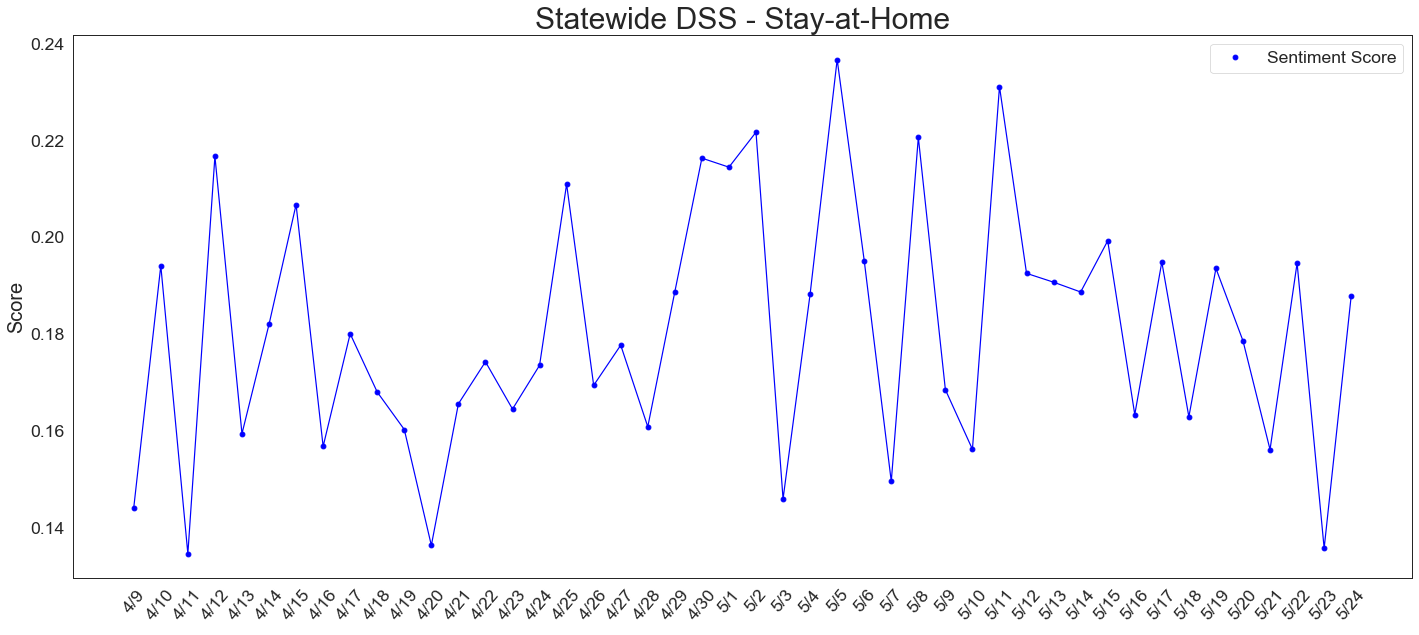

In [498]:
# Plot Statewide DSS Over Time
import matplotlib.pyplot as plt

Date = daily_sentiment_STAYHOME['Date']
Sentiment = daily_sentiment_STAYHOME['Sentiment_Score']

# "bo" is for "blue dot"
plt.plot(Date, Sentiment, 'bo', label='Sentiment Score')
plt.plot(Date, Sentiment, 'b')
# b is for "solid blue line"
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Statewide DSS - Stay-at-Home', size=30)
plt.xlabel(' ', size = 1)
plt.ylabel('Score', size = 20)
plt.xticks(rotation=50);
plt.legend()
plt.savefig("DSS-Overall-STAY", tight_layout=False)

plt.show()

In [10]:
daily_sentiment_STAYHOME_Regions

NameError: name 'daily_sentiment_STAYHOME_Regions' is not defined

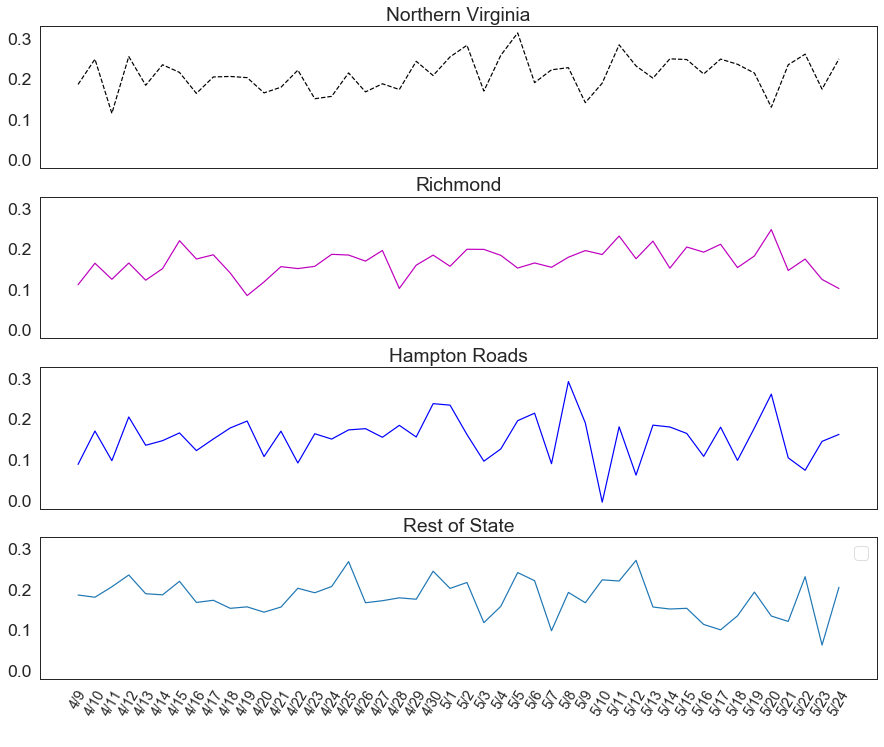

In [586]:
# Plot Regional DSS Overtime
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True, figsize=(15,12))
ax1.plot(daily_sentiment_STAYHOME_Regions['Date'], daily_sentiment_STAYHOME_Regions['NOVA'], '--', color='black')
ax1.set_title('Northern Virginia')
ax2.plot(daily_sentiment_STAYHOME_Regions['Date'], daily_sentiment_STAYHOME_Regions['RVA'], 'm-')
ax2.set_title('Richmond')
ax3.plot(daily_sentiment_STAYHOME_Regions['Date'], daily_sentiment_STAYHOME_Regions['Hampton Roads'], 'b-')
ax3.set_title('Hampton Roads')
ax4.plot(daily_sentiment_STAYHOME_Regions['Date'], daily_sentiment_STAYHOME_Regions['Rest of State'], '-')
ax4.set_title('Rest of State')
plt.xlabel(' '); plt.xticks(rotation=60, size=14)

plt.legend()
plt.savefig('DSS by Region', tight_layout=False)


In [592]:
daily_sentiment_STAYHOME_Regions.mean() # Mean average sentiment by region

NOVA             0.210056
RVA              0.166823
Hampton Roads    0.153685
Rest of State    0.178340
dtype: float64

## Additional Meta data variables are needed

Add day of week, type of day, day and week of data collection

In [242]:
len(daily_sentiment_STAYHOME)

46

In [243]:
daily_sentiment_STAYHOME['dow'] = ['Thurs', 'Fri', 'Sat', 'Sun', 
                             'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 
                             'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 
                             'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 
                             'Mon','Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun',
                            'Mon','Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun',
                            'Mon','Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun',]

daily_sentiment_STAYHOME['week'] = [ 1, 1, 1, 1, 
                              2, 2, 2, 2, 2, 2, 2, 
                              3, 3, 3, 3, 3, 3, 3, 
                              4, 4, 4, 4, 4, 4, 4,
                              5, 5, 5, 5, 5, 5, 5,
                             6, 6, 6, 6, 6, 6, 6,
                             7, 7, 7, 7, 7, 7, 7]

daily_sentiment_STAYHOME['day_type'] = [ 'Weekday', 'Weekday', 'Weekend', 'Weekend', 
                                  'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend', 
                                  'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend', 
                                  'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend', 
                                  'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend',
                                  'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend',
                                 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend',]

daily_sentiment_STAYHOME['day_type_num'] = [ '1', '1', '2', '2', 
                                  '1', '1', '1', '1', '1', '2', '2', 
                                  '1', '1', '1', '1', '1', '2', '2', 
                                 '1', '1', '1', '1', '1', '2', '2', 
                                  '1', '1', '1', '1', '1', '2', '2', 
                                '1', '1', '1', '1', '1', '2', '2', 
                                 '1', '1', '1', '1', '1', '2', '2' ]

daily_sentiment_STAYHOME.insert(0, 'Day_of_Collection', range(1, 1 + len(daily_sentiment_STAYHOME)))

In [244]:
# Append Tweet Frequency
daily_sentiment_STAYHOME =pd.concat([date_freq_df, daily_sentiment_STAYHOME], axis=1)
daily_sentiment_STAYHOME.drop(columns='date', inplace=True)
daily_sentiment_STAYHOME.sort_values('Sentiment_Score')

frequency  Day_of_Collection  Date  Sentiment_Score    dow  week day_type  \
2   10119      3                  4/11  0.134525         Sat    1     Weekend   
44  3353       45                 5/23  0.135653         Sat    7     Weekend   
11  9208       12                 4/20  0.136255         Mon    3     Weekday   
0   11343      1                  4/9   0.144032         Thurs  1     Weekday   
24  6081       25                 5/3   0.145851         Sun    4     Weekend   
28  5408       29                 5/7   0.149463         Thurs  5     Weekday   
42  4115       43                 5/21  0.156045         Thurs  7     Weekday   
31  4758       32                 5/10  0.156106         Sun    5     Weekend   
7   9891       8                  4/16  0.156706         Thurs  2     Weekday   
4   9804       5                  4/13  0.159334         Mon    2     Weekday   
10  8708       11                 4/19  0.160195         Sun    2     Weekend   
19  7482       20                 4/28  0.160767         Tues   4     Weekday   
39  4280       40                 5/18  0.162815         Mon    7     Weekday   
37  4236       38                 5/16  0.163286         Sat    6     Weekend   
14  8550       15                 4/23  0.164421         Thurs  3     Weekday   
12  8516       13                 4/21  0.165507         Tues   3     Weekday   
9   8751       10                 4/18  0.167936         Sat    2     Weekend   
30  4770       31                 5/9   0.168425         Sat    5     Weekend   
17  6956       18                 4/26  0.169324         Sun    3     Weekend   
15  7830       16                 4/24  0.173466         Fri    3     Weekday   
13  8849       14                 4/22  0.174196         Wed    3     Weekday   
18  7554       19                 4/27  0.177626         Mon    4     Weekday   
41  4275       42                 5/20  0.178525         Wed    7     Weekday   
8   9986       9                  4/17  0.179988         Fri    2     Weekday   
5   10424      6                  4/14  0.181931         Tues   2     Weekday   
45  3346       46                 5/24  0.187822         Sun    7     Weekend   
25  6130       26                 5/4   0.188194         Mon    5     Weekday   
35  5256       36                 5/14  0.188619         Thurs  6     Weekday   
20  7065       21                 4/29  0.188674         Wed    4     Weekday   
34  5401       35                 5/13  0.190642         Wed    6     Weekday   
33  5356       34                 5/12  0.192468         Tues   6     Weekday   
40  4205       41                 5/19  0.193500         Tues   7     Weekday   
1   11143      2                  4/10  0.194061         Fri    1     Weekday   
43  3994       44                 5/22  0.194576         Fri    7     Weekday   
38  3880       39                 5/17  0.194807         Sun    6     Weekend   
27  5360       28                 5/6   0.195102         Wed    5     Weekday   
36  5016       37                 5/15  0.199197         Fri    6     Weekday   
6   10066      7                  4/15  0.206674         Wed    2     Weekday   
16  6870       17                 4/25  0.210907         Sat    3     Weekend   
22  7086       23                 5/1   0.214415         Fri    4     Weekday   
21  6968       22                 4/30  0.216284         Thurs  4     Weekday   
3   9394       4                  4/12  0.216664         Sun    1     Weekend   
29  5480       30                 5/8   0.220576         Fri    5     Weekday   
23  5984       24                 5/2   0.221647         Sat    4     Weekend   
32  5130       33                 5/11  0.231066         Mon    6     Weekday   
26  5934       27                 5/5   0.236661         Tues   5     Weekday   

   day_type_num  
2   2            
44  2            
11  1            
0   1            
24  2            
28  1            
42  1            
31  2            
7   1            
4   1           

In [230]:
# Save daily_sentiment_VA to folder
daily_sentiment_STAYHOME.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/daily_sentiment_STAYHOME.csv")
daily_sentiment_STAYHOME.to_pickle("/Users/rachelmartonik/MSDS_498_Capstone/data/daily_sentiment_STAYHOME.pickle")

# Tweet Frequency and Sentiment Scores
Sentiment scores and Tweet frequency drop dramatically on the weekends.

Tweet frequency and sentiment score are postivly correlated. What does this mean? 

 - Is negativity up on the weekend? 
 - Or do only the more negative people tweet on the weekend? 
 - Or does this remove all those that tweet for work?
 
 To do:
  - Re-run sentiment score with only user names that tweet on the weekends
  - Compare those who tweet on Weekends and Weekdays - are they same people?

In [232]:
Weekends = daily_sentiment_STAYHOME[daily_sentiment_STAYHOME["day_type"]=="Weekend"]
Weekdays = daily_sentiment_STAYHOME[daily_sentiment_STAYHOME["day_type"]=="Weekday"]

corr, pvalue = pearsonr(Weekends['Day_of_Collection'], Weekends['Sentiment_Score'])
print(f"p-value: {pvalue}")
print('Correlation of week of data collection and Sentiment Score - WEEKENDS: %.3f' % corr)

corr, pvalue= pearsonr(Weekdays['Day_of_Collection'], Weekdays['Sentiment_Score'])
print(f"p-value: {pvalue}")
print('Correlation of week of data collection and Sentiment Score - WEEKDAYS: %.3f' % corr)

corr, pvalue = pearsonr(daily_sentiment_STAYHOME['Day_of_Collection'], daily_sentiment_STAYHOME['Sentiment_Score'])
print(f"p-value: {pvalue}")
print('Correlation of week of data collection and Sentiment Score - OVERALL: %.3f' % corr)

corr, pvalue = pearsonr(daily_sentiment_STAYHOME['week'], daily_sentiment_STAYHOME['Sentiment_Score'])
print(f"p-value: {pvalue}")
print('Pearsons correlation of week of data collection and Sentiment Score: %.3f' % corr)

p-value: 0.7345870962916509
Correlation of week of data collection and Sentiment Score - WEEKENDS: -0.100
p-value: 0.10274053005150353
Correlation of week of data collection and Sentiment Score - WEEKDAYS: 0.294
p-value: 0.33688016381179353
Correlation of week of data collection and Sentiment Score - OVERALL: 0.145
p-value: 0.3039551575397415
Pearsons correlation of week of data collection and Sentiment Score: 0.155


 Opposite of COVID data:
 Overall sentiment of weekday tweets is improving, while weekend sentiment is declining.

In [246]:

daily_sentiment_STAYHOME.head()

frequency  Day_of_Collection  Date  Sentiment_Score    dow  week day_type  \
0  11343      1                  4/9   0.144032         Thurs  1     Weekday   
1  11143      2                  4/10  0.194061         Fri    1     Weekday   
2  10119      3                  4/11  0.134525         Sat    1     Weekend   
3  9394       4                  4/12  0.216664         Sun    1     Weekend   
4  9804       5                  4/13  0.159334         Mon    2     Weekday   

  day_type_num  
0  1            
1  1            
2  2            
3  2            
4  1

In [245]:
# Correlations
corr, pvalue = pearsonr(daily_sentiment_STAYHOME['frequency'], daily_sentiment_STAYHOME['Sentiment_Score'])
print(f"p-value: {pvalue}")
print('Pearsons correlation of Tweet frequency and Sentiment Score: %.3f' % corr)

p-value: 0.25338601860599874
Pearsons correlation of Tweet frequency and Sentiment Score: -0.172


Unlike the COVID data, Tweet frequency is not strongly correlated with sentiment score.

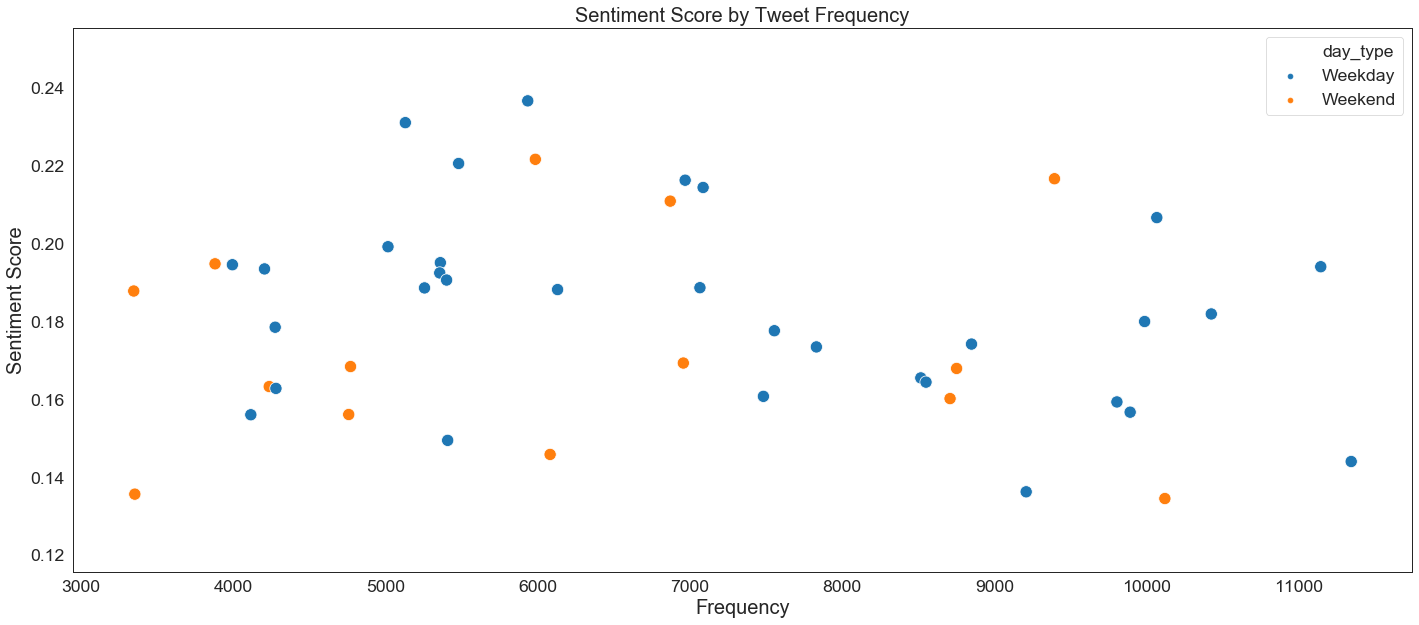

In [247]:
# Scatter plot of sentiment score by Tweet Frequency
ax = sns.scatterplot(x="frequency", y="Sentiment_Score", hue="day_type",
                     data=daily_sentiment_STAYHOME, s=150 ).set_title("Sentiment Score by Tweet Frequency",fontsize=20)
plt.xlabel("Frequency", fontsize=20)
plt.ylabel("Sentiment Score", fontsize=20)
plt.savefig("DSS-Overall by Tweet Frequency - STAY", tight_layout=False)
plt.show()

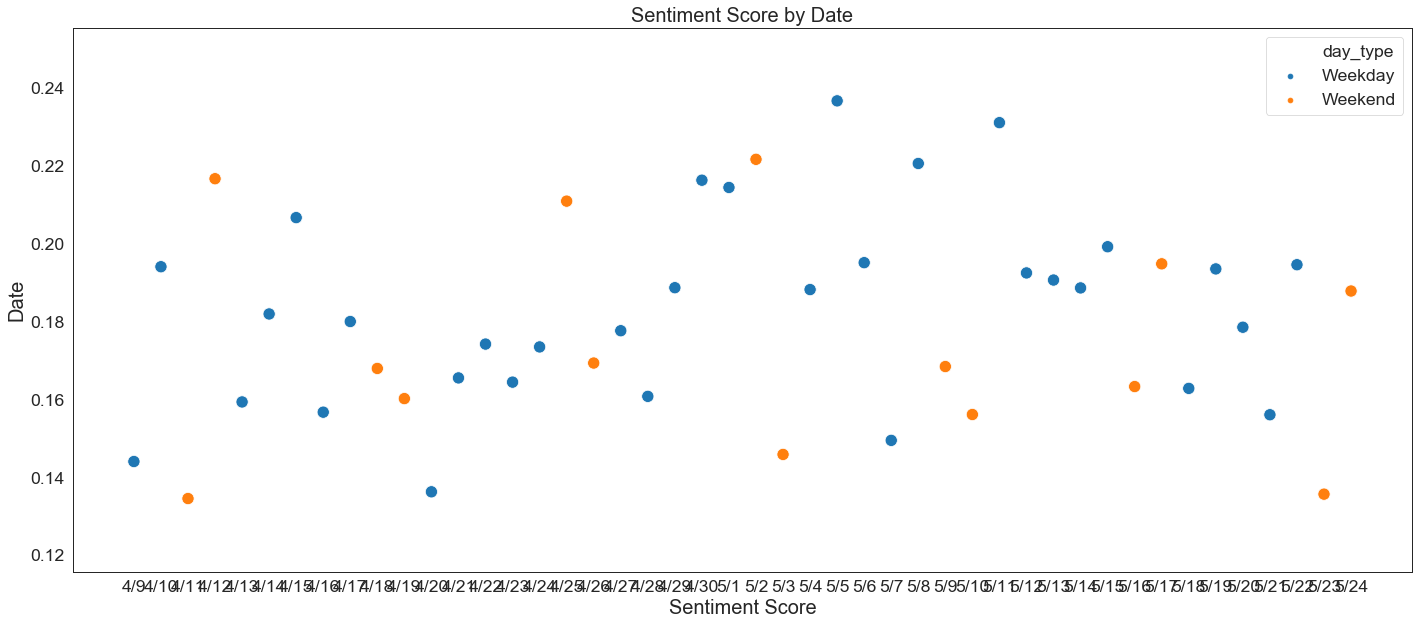

In [248]:
# Daily Sentiment Score by Date - Colored by day type
ax = sns.scatterplot(x="Date", y="Sentiment_Score", hue="day_type",
                     data=daily_sentiment_STAYHOME, s=150 ).set_title("Sentiment Score by Date",fontsize=20)
plt.xlabel("Sentiment Score", fontsize=20)
plt.ylabel("Date", fontsize=20)
plt.show()

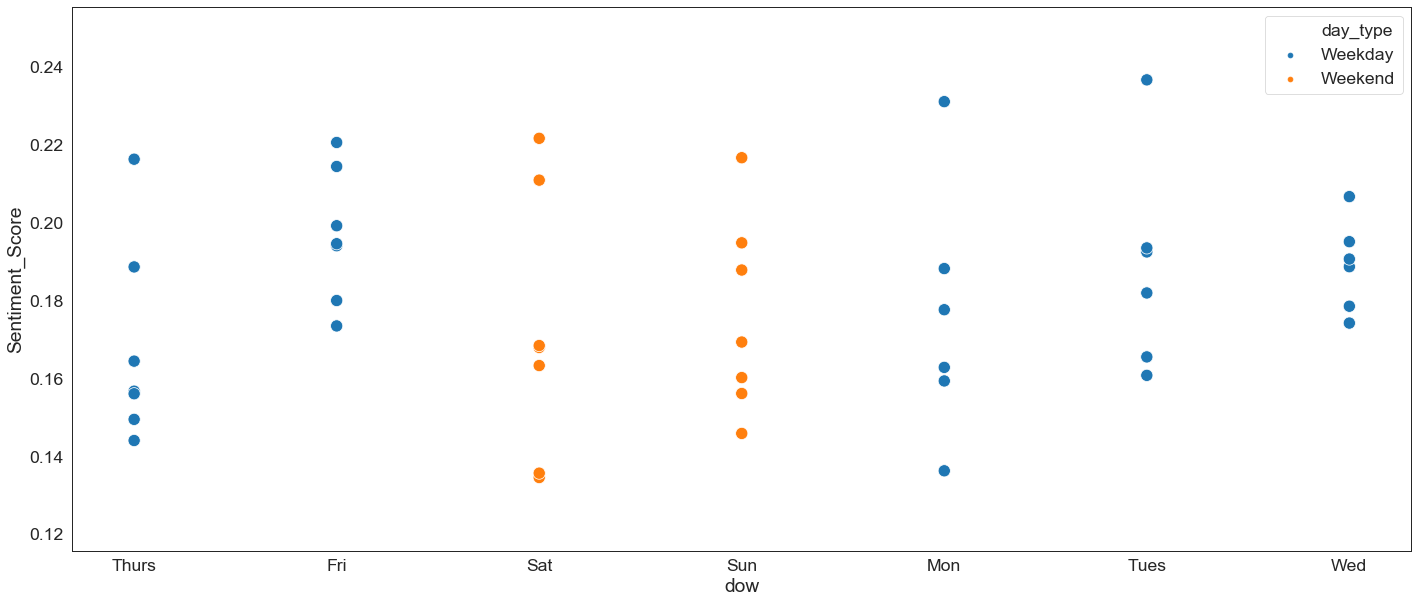

In [249]:
ax = sns.scatterplot(x="dow", y="Sentiment_Score", hue="day_type",
                     data=daily_sentiment_STAYHOME, s=150 )

In [250]:
daily_sentiment_STAYHOME

frequency  Day_of_Collection  Date  Sentiment_Score    dow  week day_type  \
0   11343      1                  4/9   0.144032         Thurs  1     Weekday   
1   11143      2                  4/10  0.194061         Fri    1     Weekday   
2   10119      3                  4/11  0.134525         Sat    1     Weekend   
3   9394       4                  4/12  0.216664         Sun    1     Weekend   
4   9804       5                  4/13  0.159334         Mon    2     Weekday   
5   10424      6                  4/14  0.181931         Tues   2     Weekday   
6   10066      7                  4/15  0.206674         Wed    2     Weekday   
7   9891       8                  4/16  0.156706         Thurs  2     Weekday   
8   9986       9                  4/17  0.179988         Fri    2     Weekday   
9   8751       10                 4/18  0.167936         Sat    2     Weekend   
10  8708       11                 4/19  0.160195         Sun    2     Weekend   
11  9208       12                 4/20  0.136255         Mon    3     Weekday   
12  8516       13                 4/21  0.165507         Tues   3     Weekday   
13  8849       14                 4/22  0.174196         Wed    3     Weekday   
14  8550       15                 4/23  0.164421         Thurs  3     Weekday   
15  7830       16                 4/24  0.173466         Fri    3     Weekday   
16  6870       17                 4/25  0.210907         Sat    3     Weekend   
17  6956       18                 4/26  0.169324         Sun    3     Weekend   
18  7554       19                 4/27  0.177626         Mon    4     Weekday   
19  7482       20                 4/28  0.160767         Tues   4     Weekday   
20  7065       21                 4/29  0.188674         Wed    4     Weekday   
21  6968       22                 4/30  0.216284         Thurs  4     Weekday   
22  7086       23                 5/1   0.214415         Fri    4     Weekday   
23  5984       24                 5/2   0.221647         Sat    4     Weekend   
24  6081       25                 5/3   0.145851         Sun    4     Weekend   
25  6130       26                 5/4   0.188194         Mon    5     Weekday   
26  5934       27                 5/5   0.236661         Tues   5     Weekday   
27  5360       28                 5/6   0.195102         Wed    5     Weekday   
28  5408       29                 5/7   0.149463         Thurs  5     Weekday   
29  5480       30                 5/8   0.220576         Fri    5     Weekday   
30  4770       31                 5/9   0.168425         Sat    5     Weekend   
31  4758       32                 5/10  0.156106         Sun    5     Weekend   
32  5130       33                 5/11  0.231066         Mon    6     Weekday   
33  5356       34                 5/12  0.192468         Tues   6     Weekday   
34  5401       35                 5/13  0.190642         Wed    6     Weekday   
35  5256       36                 5/14  0.188619         Thurs  6     Weekday   
36  5016       37                 5/15  0.199197         Fri    6     Weekday   
37  4236       38                 5/16  0.163286         Sat    6     Weekend   
38  3880       39                 5/17  0.194807         Sun    6     Weekend   
39  4280       40                 5/18  0.162815         Mon    7     Weekday   
40  4205       41                 5/19  0.193500         Tues   7     Weekday   
41  4275       42                 5/20  0.178525         Wed    7     Weekday   
42  4115       43                 5/21  0.156045         Thurs  7     Weekday   
43  3994       44                 5/22  0.194576         Fri    7     Weekday   
44  3353       45                 5/23  0.135653         Sat    7     Weekend   
45  3346       46                 5/24  0.187822         Sun    7     Weekend   

   day_type_num  
0   1            
1   1            
2   2            
3   2            
4   1            
5   1            
6   1            
7   1            
8   1            
9   2           

In [255]:
# Split data by weeks for analysis
Week1= daily_sentiment_STAYHOME[daily_sentiment_STAYHOME['week']==1]
Week2= daily_sentiment_STAYHOME[daily_sentiment_STAYHOME['week']==2]
Week3= daily_sentiment_STAYHOME[daily_sentiment_STAYHOME['week']==3]
Week4= daily_sentiment_STAYHOME[daily_sentiment_STAYHOME['week']==4]
Week5= daily_sentiment_STAYHOME[daily_sentiment_STAYHOME['week']==5]
Week6= daily_sentiment_STAYHOME[daily_sentiment_STAYHOME['week']==6]
Week7= daily_sentiment_STAYHOME[daily_sentiment_STAYHOME['week']==7]

# Weekly mean sentiment score
a = pd.DataFrame(daily_sentiment_STAYHOME.groupby('week')['Sentiment_Score'].mean())
a.reset_index(inplace=True)
a

week  Sentiment_Score
0  1     0.172321       
1  2     0.173252       
2  3     0.170582       
3  4     0.189323       
4  5     0.187790       
5  6     0.194298       
6  7     0.172705

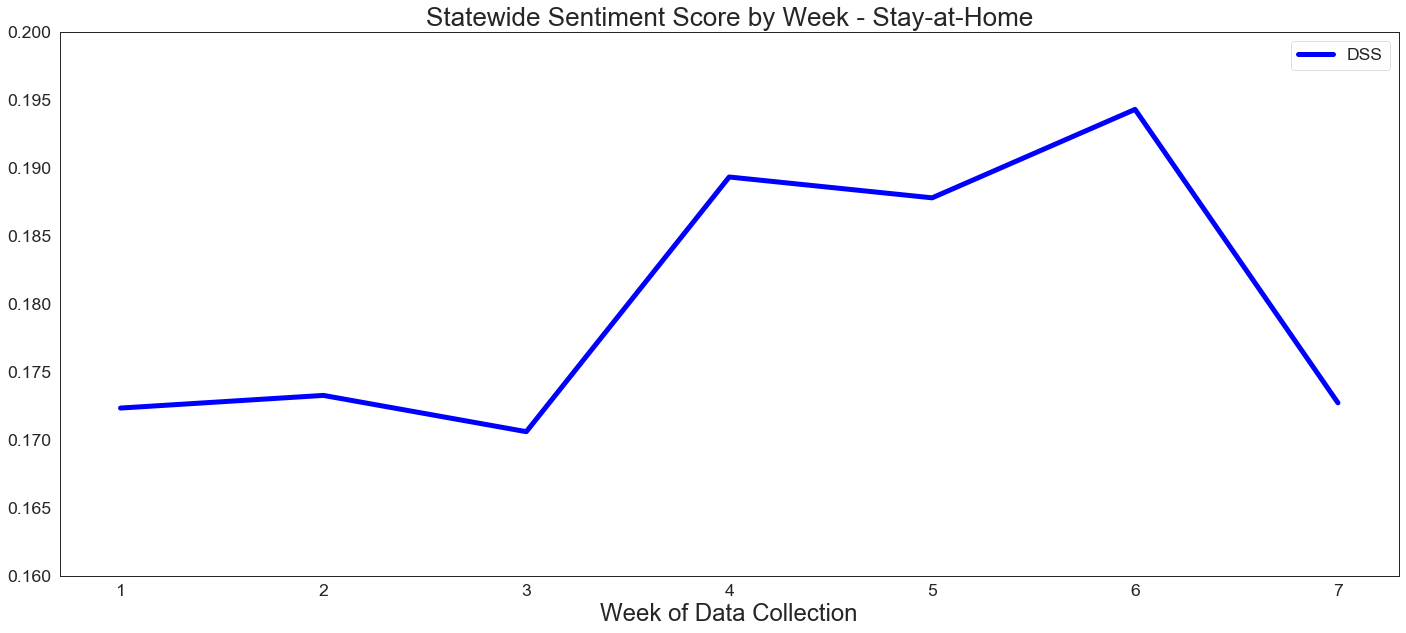

In [279]:
plt.plot('week', 'Sentiment_Score', 'b', linewidth=5.0,label='DSS', data=a)
plt.title('Statewide Sentiment Score by Week - Stay-at-Home', size=26)
plt.xlabel('Week of Data Collection', size = 24)
plt.ylim(top=.2)  # adjust the top leaving bottom unchanged
plt.ylim(bottom=.16) 
#plt.ylabel('Score', size = 20)
plt.legend()
plt.savefig("DSS-WEEKLY-STAY", tight_layout=False)
plt.show()


# Daily Sentiment Score By County

Use the code below to run through each cleaned daily data set (i.e data_0407_clean). The code takes the Tweet and provides a sentiment score. Then I appened county to each data set (not all counties have Tweets each day), and ran the mean sentiment score for that day by county. At the end, I compiled the daily scores into a data frame with all counties.

Code has been commented out because it only needs to be run once for each day of data.

In [183]:
# # Run through each data set separetly to get county level sentiment score
# data = data_0524_clean
# day = '05-24'

# text_body=[] #Loop through tweet to prepare for sentiment analysis
# sentiment_score = [] # Append sentiment analysis results to a list
# for i in range(0,len(data)):
#     temp_text=data['text'].iloc[i]
#     text_body.append(temp_text)
    
# sentences = text_body # Sentiment analysis
   
# for sentence in sentences:
#     vs = analyzer.polarity_scores(sentence)
#     sentiment_score.append(vs)

# # Create data frame of county names
locations = pd.DataFrame(data['county_name'])
locations.reset_index(inplace=True)
#locations

In [427]:
# a = pd.DataFrame(sentiment_score)
# b = pd.concat([a, locations], axis=1)
# print (len(a))
# print (len(b))
# print (len(data))

In [428]:
# c = pd.DataFrame(b.groupby('county_name')['compound'].mean())
# c.reset_index(inplace=True)
# c.columns=['county_name', day]
# stay_sent_0524 = c
# stay_sent_0524.to_pickle(f"stay_sent_{day}.pkl") # save the DataFrame to use in Part 2
# c

In [237]:
# Read in data from previous runs
sent_0409 = pd.read_pickle('stay_sent_04-09.pkl')
sent_0410 = pd.read_pickle('stay_sent_04-10.pkl')
sent_0411 = pd.read_pickle('stay_sent_04-11.pkl')
sent_0412 = pd.read_pickle('stay_sent_04-12.pkl')
sent_0413 = pd.read_pickle('stay_sent_04-13.pkl')
sent_0414 = pd.read_pickle('stay_sent_04-14.pkl')
sent_0415 = pd.read_pickle('stay_sent_04-15.pkl')
sent_0416 = pd.read_pickle('stay_sent_04-16.pkl')
sent_0417 = pd.read_pickle('stay_sent_04-17.pkl')
sent_0418 = pd.read_pickle('stay_sent_04-18.pkl')
sent_0419 = pd.read_pickle('stay_sent_04-19.pkl')
sent_0420 = pd.read_pickle('stay_sent_04-20.pkl')
sent_0421 = pd.read_pickle('stay_sent_04-21.pkl')
sent_0422 = pd.read_pickle('stay_sent_04-22.pkl')
sent_0423 = pd.read_pickle('stay_sent_04-23.pkl')
sent_0424 = pd.read_pickle('stay_sent_04-24.pkl')
sent_0425 = pd.read_pickle('stay_sent_04-25.pkl')
sent_0426 = pd.read_pickle('stay_sent_04-26.pkl')
sent_0427 = pd.read_pickle('stay_sent_04-27.pkl')
sent_0428 = pd.read_pickle('stay_sent_04-28.pkl')
sent_0429 = pd.read_pickle('stay_sent_04-29.pkl')
sent_0430 = pd.read_pickle('stay_sent_04-30.pkl')
sent_0501 = pd.read_pickle('stay_sent_05-01.pkl')
sent_0502 = pd.read_pickle('stay_sent_05-02.pkl')
sent_0503 = pd.read_pickle('stay_sent_05-03.pkl')
sent_0504 = pd.read_pickle('stay_sent_05-04.pkl')
sent_0505 = pd.read_pickle('stay_sent_05-05.pkl')
sent_0506 = pd.read_pickle('stay_sent_05-06.pkl')
sent_0507 = pd.read_pickle('stay_sent_05-07.pkl')
sent_0508 = pd.read_pickle('stay_sent_05-08.pkl')
sent_0509 = pd.read_pickle('stay_sent_05-09.pkl')
sent_0510 = pd.read_pickle('stay_sent_05-10.pkl')
sent_0511 = pd.read_pickle('stay_sent_05-11.pkl')
sent_0512 = pd.read_pickle('stay_sent_05-12.pkl')
sent_0513 = pd.read_pickle('stay_sent_05-13.pkl')
sent_0514 = pd.read_pickle('stay_sent_05-14.pkl')
sent_0515 = pd.read_pickle('stay_sent_05-15.pkl')
sent_0516 = pd.read_pickle('stay_sent_05-16.pkl')
sent_0517 = pd.read_pickle('stay_sent_05-17.pkl')
sent_0518 = pd.read_pickle('stay_sent_05-18.pkl')
sent_0519 = pd.read_pickle('stay_sent_05-19.pkl')
sent_0520 = pd.read_pickle('stay_sent_05-20.pkl')
sent_0521 = pd.read_pickle('stay_sent_05-21.pkl')
sent_0522 = pd.read_pickle('stay_sent_05-22.pkl')
sent_0523 = pd.read_pickle('stay_sent_05-23.pkl')
sent_0524 = pd.read_pickle('stay_sent_05-24.pkl')

# COVID Tracking Data

In a separate notebook, I pull daily Covid data for confirmed number of cases and deaths for Virginia. I added population data from ACS, normalizing the number of cases and deaths by every 1000 county/city resident.

In [10]:
cases = pd.read_csv("cases_per_1000.csv") 
cases.drop(columns=['Unnamed: 0'], inplace=True)
deaths = pd.read_csv("deaths_per_1000.csv") 
deaths.drop(columns=['Unnamed: 0'], inplace=True)
#cases.rename(columns={'county_lower':'county_name'}, inplace=True)
#deaths.rename(columns={'county_lower':'county_name'}, inplace=True)

In [11]:
name_change_dict = {"county_lower": "county_name",
                    "2020-04-07_per": "04-07",
                    "2020-04-08_per": "04-08",
                    "2020-04-09_per": "04-09",
                    "2020-04-10_per": "04-10",
                    "2020-04-11_per": "04-11",
                    "2020-04-12_per": "04-12",
                    "2020-04-13_per": "04-13",
                    "2020-04-14_per": "04-14",
                    "2020-04-15_per": "04-15",
                    "2020-04-16_per": "04-16",
                    "2020-04-17_per": "04-17",
                    "2020-04-18_per": "04-18",
                    "2020-04-19_per": "04-19",
                    "2020-04-20_per": "04-20",
                    "2020-04-21_per": "04-21",
                    "2020-04-22_per": "04-22",
                    "2020-04-23_per": "04-23",
                    "2020-04-24_per": "04-24",
                    "2020-04-25_per": "04-25",
                    "2020-04-26_per": "04-26",
                    "2020-04-27_per": "04-27",
                    "2020-04-28_per": "04-28",
                    "2020-04-29_per": "04-29",
                    "2020-04-30_per": "04-30",
                    "2020-05-01_per": "05-01",
                    "2020-05-02_per": "05-02",
                    "2020-05-03_per": "05-03",
                    "2020-05-04_per": "05-04",
                    "2020-05-05_per": "05-05",
                    "2020-05-06_per": "05-06",
                    "2020-05-07_per": "05-07",
                    "2020-05-08_per": "05-08", 
                    "2020-05-09_per": "05-09", 
                    "2020-05-10_per": "05-10", 
                    "2020-05-11_per": "05-11", 
                    "2020-05-12_per": "05-12", 
                    "2020-05-13_per": "05-13", 
                    "2020-05-14_per": "05-14",
                    "2020-05-15_per": "05-15", 
                    "2020-05-16_per": "05-16", 
                    "2020-05-17_per": "05-17", 
                    "2020-05-18_per": "05-18", 
                    "2020-05-19_per": "05-19", 
                    "2020-05-20_per": "05-20", 
                    "2020-05-21_per": "05-21", 
                    "2020-05-22_per": "05-22", 
                    "2020-05-23_per": "05-23", 
                    "2020-05-24_per": "05-24", 
                   }
              

cases.rename(columns=name_change_dict, inplace=True)
deaths.rename(columns=name_change_dict, inplace=True)

In [12]:
cases

county_name  percent_VA_pop     04-07     04-08     04-09  \
0      accomack county        0.003891  0.335960  0.335960  0.335960   
1     albemarle county        0.012641  0.357294  0.385501  0.404306   
2      alexandria city        0.018601  0.805086  0.913709  0.952046   
3     alleghany county        0.001817  0.130839  0.130839  0.130839   
4        amelia county        0.001528  0.544578  0.622374  0.622374   
..                 ...             ...       ...       ...       ...   
128        york county        0.008033  0.369894  0.369894  0.369894   
129  martinsville city        0.000000  0.000000  0.000000  0.000000   
130   dickenson county        0.000000  0.000000  0.000000  0.000000   
131       bland county        0.000000  0.000000  0.000000  0.000000   
132        bath county        0.000000  0.000000  0.000000  0.000000   

        04-10     04-11     04-12     04-13     04-14  ...      05-15  \
0    0.366502  0.458127  0.458127  0.458127  0.458127  ...  19.791094   
1    0.404306  0.432514  0.432514  0.460721  0.470124  ...   1.250529   
2    1.111786  1.201240  1.265135  1.501549  1.578224  ...   8.919843   
3    0.130839  0.261677  0.261677  0.261677  0.261677  ...   0.392516   
4    0.700171  0.700171  0.700171  0.700171  0.700171  ...   1.322546   
..        ...       ...       ...       ...       ...  ...        ...   
128  0.369894  0.399485  0.429077  0.488260  0.517851  ...   0.917336   
129  0.000000  0.000000  0.000000  0.000000  0.000000  ...   0.000000   
130  0.000000  0.000000  0.000000  0.000000  0.000000  ...   0.000000   
131  0.000000  0.000000  0.000000  0.000000  0.000000  ...   0.000000   
132  0.000000  0.000000  0.000000  0.000000  0.000000  ...   0.000000   

         05-16      05-17      05-18      05-19      05-20      05-21  \
0    20.401930  21.012766  21.073850  21.409810  21.654145  21.654145   
1     1.278736   1.297541   1.306944   1.325749   1.335151   1.335151   
2     9.328775   9.431009   9.648254   9.865500  10.076355  10.395834   
3     0.392516   0.457935   0.588774   0.588774   0.654193   0.588774   
4     1.400342   1.400342   1.555936   1.555936   1.633733   1.711529   
..         ...        ...        ...        ...        ...        ...   
128   0.917336   0.917336   0.932132   0.932132   0.932132   0.961723   
129   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
130   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
131   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
132   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   

         05-22      05-23      05-24  
0    21.715228  22.051188  22.203897  
1     1.335151   1.344554   1.391566  
2    10.587521  10.881441  11.073129  
3     0.654193   0.850451   0.850451  
4     1.711529   1.711529   1.633733  
..         ...        ...        ...  
128   0.991315   0.991315   1.006111  
129   0.000000   0.000000   0.000000  
130   0.000000   0.000000   0.000000  
131   0.000000   0.000000   0.000000  
132   0.000000   0.000000   0.000000  

[133 rows x 50 columns]

In [13]:
VA_Population = cases[["county_name", "percent_VA_pop"]]
VA_Population.head()

county_name  percent_VA_pop
0   accomack county        0.003891
1  albemarle county        0.012641
2   alexandria city        0.018601
3  alleghany county        0.001817
4     amelia county        0.001528

In [14]:
# Create wide COVID cases and deaths data
cases_wide = pd.melt(cases, id_vars=['county_name'])
deaths_wide = pd.melt(deaths, id_vars=['county_name'])

In [342]:
county_check = pd.merge(covid_counties, Twitter_counties, on='county_name')
#county_check

NameError: name 'covid_counties' is not defined

In [341]:
# Save wide COVID case to file
# cases_wide.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/cases_wide.csv")
# deaths_wide.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/deaths_wide.csv")

## County/City Checks

VA has 133 total counties/cities included in ACS data. As of 5/2 (Data as of 4/30), the following discrepancies exist:

Counties in Twitter data but not COVID data:
 - charlottsville city
 - henry countye
 - wake county
 - bath county

Counites in Covid data but not in Twitter data:
 - Buena Vista city
 - Fairfax city
 - Covington city
 - Greensville county
 - lunenburg county
 - sussex county
 - Martinsville city 
 - Dickenson 
 - Bland 
 - Bath 

In [438]:
# How many unique county/cities do we have in entire merged data?
county_list = merged_cleaned_data['county_name'].value_counts()
Twitter_counties = pd.DataFrame(county_list)
Twitter_counties.reset_index(inplace=True)
Twitter_counties= Twitter_counties['index']
Twitter_counties = pd.DataFrame(Twitter_counties)
Twitter_counties.columns=['county_name']
Twitter_counties.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/Twitter_counties.csv")
covid_counties = pd.DataFrame(cases.county_name)
covid_counties.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/covid_counties.csv")

In [439]:
covid_count = len(covid_counties)
twitter_count = len(Twitter_counties)

print(f"There are {covid_count} counties in the COVID data set")
print(f"There are {twitter_count} counties in the Twitter data set")

There are 133 counties in the COVID data set
There are 127 counties in the Twitter data set


In [440]:
# Create lists of county names in each data set
twitter_list = Twitter_counties['county_name'].to_list()
covid_list = covid_counties['county_name'].to_list()

In [441]:
covid_list

['accomack county',
 'albemarle county',
 'alexandria city',
 'alleghany county',
 'amelia county',
 'amherst county',
 'appomattox county',
 'arlington county',
 'augusta county',
 'bedford county',
 'botetourt county',
 'bristol city',
 'brunswick county',
 'buchanan county',
 'buckingham county',
 'buena vista city',
 'campbell county',
 'caroline county',
 'carroll county',
 'charles city county',
 'charlotte county',
 'charlottesville city',
 'chesapeake city',
 'chesterfield county',
 'clarke county',
 'colonial heights city',
 'covington city',
 'craig county',
 'culpeper county',
 'cumberland county',
 'danville city',
 'dinwiddie county',
 'emporia city',
 'essex county',
 'fairfax county',
 'fairfax city',
 'falls church city',
 'fauquier county',
 'floyd county',
 'fluvanna county',
 'franklin county',
 'franklin city',
 'frederick county',
 'fredericksburg city',
 'galax city',
 'giles county',
 'gloucester county',
 'goochland county',
 'grayson county',
 'greene county',


In [442]:
# Check to see what COVID counties are not in TWitter
for i in twitter_list:
    if i in covid_list :
        print(f"YES")
    else:
        print(f"{i} NOT is covid_list")

YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES


In [443]:
# Check to see what COVID counties are not in TWitter
for i in covid_list:
    if i in twitter_list :
        print(f"YES")
    else:
        print(f"{i} NOT is twitter_list")

YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
craig county NOT is twitter_list
YES
cumberland county NOT is twitter_list
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
greensville county NOT is twitter_list
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
king and queen county NOT is twitter_list
YES
YES
YES
YES
YES
lunenburg county NOT is twitter_list
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
sussex county NOT is twitter_list
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES


## Daily Sentiment Score Data Frame

For now, we will include counites/cities included in both the Twitter data and the COVID data as we are trying to compare the two. Will reassess later on in course.

In [239]:
sent_0409

county_name     04-09
0   albemarle county   0.208548
1   alexandria city    0.247984
2   amherst county     0.000000
3   arlington county   0.188792
4   augusta county     0.886000
..             ...          ...
71  waynesboro city    0.124300
72  williamsburg city  0.040121
73  winchester city    0.224767
74  wise county        0.120260
75  york county        0.022000

[76 rows x 2 columns]

In [446]:
# Create blank DSS Daily Sentiment Score data frame
DSS = county_check
DSS.columns=['county_name']
DSS.head()

county_name
0  accomack county 
1  albemarle county
2  alexandria city 
3  alleghany county
4  amelia county

In [450]:
date_list = [stay_sent_0409, stay_sent_0410, stay_sent_0411, stay_sent_0412, stay_sent_0413, stay_sent_0414, 
             stay_sent_0415, 
             stay_sent_0416, stay_sent_0417, stay_sent_0418, stay_sent_0419, stay_sent_0420, stay_sent_0421, 
             stay_sent_0422, stay_sent_0423, stay_sent_0424, 
             stay_sent_0425, stay_sent_0426, stay_sent_0427, stay_sent_0428, stay_sent_0429, stay_sent_0430, 
             stay_sent_0501, stay_sent_0502, stay_sent_0503,
             stay_sent_0504, stay_sent_0505, stay_sent_0506, stay_sent_0507, stay_sent_0508, stay_sent_0509, 
             stay_sent_0510, stay_sent_0511, stay_sent_0512,
            stay_sent_0513, stay_sent_0514, stay_sent_0515, stay_sent_0516, stay_sent_0517, stay_sent_0518, 
             stay_sent_0519, stay_sent_0520, stay_sent_0521,
            stay_sent_0522, stay_sent_0523, stay_sent_0524]


In [451]:
for i in date_list:
    DSS = pd.merge(DSS, i, on='county_name', how="left")

In [452]:
DSS

county_name     04-09     04-10     04-11     04-12     04-13  \
0    accomack county       NaN        0.051600 NaN       NaN       NaN         
1    albemarle county       0.208548  0.218934  0.096576  0.435859  0.181924   
2    alexandria city        0.247984  0.157452  0.067400  0.265487  0.156942   
3    alleghany county      NaN        0.316250 NaN       NaN       NaN         
4    amelia county         NaN       NaN       NaN       NaN        0.698800   
5    amherst county         0.000000 NaN       NaN       NaN        0.340000   
6    appomattox county     NaN       NaN       NaN       NaN        0.700300   
7    arlington county       0.188792  0.221108  0.108607  0.188327  0.042931   
8    augusta county         0.886000  0.527375  0.349633 NaN       -0.057750   
9    bedford county         0.200950 -0.359600 NaN        0.000000 NaN         
10   botetourt county      -0.064000 -0.766100 NaN        0.000000 NaN         
11   bristol city          -0.088950  0.000000  0.000000  0.867900  0.110625   
12   brunswick county      NaN       NaN       NaN       NaN       NaN         
13   buchanan county       NaN       NaN       NaN       NaN        0.000000   
14   buckingham county     NaN       NaN       NaN       NaN       NaN         
15   buena vista city      NaN       NaN       NaN       NaN       NaN         
16   campbell county       NaN       NaN        0.380200 NaN       NaN         
17   caroline county       NaN       NaN       -0.758400 NaN        0.718400   
18   carroll county        NaN       NaN        0.765000  0.771700  0.361200   
19   charles city county   -0.979600 NaN       -0.476700  0.000000 NaN         
20   charlotte county      NaN       NaN        0.868200  0.000000  0.599400   
21   charlottesville city   0.077200  0.318200 -0.484100  0.744000 NaN         
22   chesapeake city       -0.029179  0.085125  0.036553  0.167712  0.101784   
23   chesterfield county   -0.109560  0.271742 -0.055208  0.163550  0.228413   
24   clarke county          0.000000 -0.133833 NaN       NaN       -0.505350   
25   colonial heights city NaN       NaN       NaN       -0.700300 -0.316700   
26   covington city        NaN       NaN       -0.510600 NaN       NaN         
27   culpeper county        0.270550  0.081400 -0.732700 -0.311900  0.654550   
28   danville city          0.159250  0.000000  0.475900  0.352017 NaN         
29   dinwiddie county      NaN       NaN       NaN       -0.307100 NaN         
30   emporia city           0.510600 NaN       NaN       NaN       NaN         
31   essex county          NaN        0.904800 NaN        0.732650 NaN         
32   fairfax county         0.175361  0.321613  0.111521  0.374118  0.212706   
33   fairfax city           0.213409  0.095216  0.136672  0.182550  0.126819   
34   falls church city      0.295400  0.306554  0.005286  0.345243  0.272056   
35   fauquier county        0.204133  0.412286  0.299336 -0.176050 -0.023867   
36   floyd county          NaN       NaN       NaN       NaN       NaN         
37   fluvanna county       NaN        0.000000  0.382900 NaN       NaN         
38   franklin county        0.077200 NaN        0.357800  0.671050 NaN         
39   franklin city         NaN       NaN       NaN       NaN        0.822300   
40   frederick county       0.636900  0.875000  0.440400  0.000000 NaN         
41   fredericksburg city    0.284950  0.207784  0.070559  0.313692  0.077791   
42   galax city            NaN       NaN        0.000000 NaN        0.438700   
43   giles county           0.000000 NaN       NaN       NaN       NaN         
44   gloucester county     -0.143200  0.000000 -0.726850  0.510600  0.681350   
45   goochland county       0.000000 NaN       NaN       NaN       NaN         
46   grayson county        NaN       NaN       NaN       NaN       NaN         
47   greene county         NaN       NaN       NaN       NaN       NaN         
48   halifax county         0.677600  0.613950  0.177900 NaN       -0.401900   
49   hampton ci

## Adding statistics to DSS

In [453]:
# Add total number of tweets per county for reference
freqs = pd.DataFrame(merged_cleaned_data.county_name.value_counts())
freqs.reset_index(inplace=True)
freqs.columns=['county_name','NumOfTweets']


In [454]:
DSS = pd.merge(DSS, freqs, on='county_name', how="left")
DSS

county_name     04-09     04-10     04-11     04-12     04-13  \
0    accomack county       NaN        0.051600 NaN       NaN       NaN         
1    albemarle county       0.208548  0.218934  0.096576  0.435859  0.181924   
2    alexandria city        0.247984  0.157452  0.067400  0.265487  0.156942   
3    alleghany county      NaN        0.316250 NaN       NaN       NaN         
4    amelia county         NaN       NaN       NaN       NaN        0.698800   
5    amherst county         0.000000 NaN       NaN       NaN        0.340000   
6    appomattox county     NaN       NaN       NaN       NaN        0.700300   
7    arlington county       0.188792  0.221108  0.108607  0.188327  0.042931   
8    augusta county         0.886000  0.527375  0.349633 NaN       -0.057750   
9    bedford county         0.200950 -0.359600 NaN        0.000000 NaN         
10   botetourt county      -0.064000 -0.766100 NaN        0.000000 NaN         
11   bristol city          -0.088950  0.000000  0.000000  0.867900  0.110625   
12   brunswick county      NaN       NaN       NaN       NaN       NaN         
13   buchanan county       NaN       NaN       NaN       NaN        0.000000   
14   buckingham county     NaN       NaN       NaN       NaN       NaN         
15   buena vista city      NaN       NaN       NaN       NaN       NaN         
16   campbell county       NaN       NaN        0.380200 NaN       NaN         
17   caroline county       NaN       NaN       -0.758400 NaN        0.718400   
18   carroll county        NaN       NaN        0.765000  0.771700  0.361200   
19   charles city county   -0.979600 NaN       -0.476700  0.000000 NaN         
20   charlotte county      NaN       NaN        0.868200  0.000000  0.599400   
21   charlottesville city   0.077200  0.318200 -0.484100  0.744000 NaN         
22   chesapeake city       -0.029179  0.085125  0.036553  0.167712  0.101784   
23   chesterfield county   -0.109560  0.271742 -0.055208  0.163550  0.228413   
24   clarke county          0.000000 -0.133833 NaN       NaN       -0.505350   
25   colonial heights city NaN       NaN       NaN       -0.700300 -0.316700   
26   covington city        NaN       NaN       -0.510600 NaN       NaN         
27   culpeper county        0.270550  0.081400 -0.732700 -0.311900  0.654550   
28   danville city          0.159250  0.000000  0.475900  0.352017 NaN         
29   dinwiddie county      NaN       NaN       NaN       -0.307100 NaN         
30   emporia city           0.510600 NaN       NaN       NaN       NaN         
31   essex county          NaN        0.904800 NaN        0.732650 NaN         
32   fairfax county         0.175361  0.321613  0.111521  0.374118  0.212706   
33   fairfax city           0.213409  0.095216  0.136672  0.182550  0.126819   
34   falls church city      0.295400  0.306554  0.005286  0.345243  0.272056   
35   fauquier county        0.204133  0.412286  0.299336 -0.176050 -0.023867   
36   floyd county          NaN       NaN       NaN       NaN       NaN         
37   fluvanna county       NaN        0.000000  0.382900 NaN       NaN         
38   franklin county        0.077200 NaN        0.357800  0.671050 NaN         
39   franklin city         NaN       NaN       NaN       NaN        0.822300   
40   frederick county       0.636900  0.875000  0.440400  0.000000 NaN         
41   fredericksburg city    0.284950  0.207784  0.070559  0.313692  0.077791   
42   galax city            NaN       NaN        0.000000 NaN        0.438700   
43   giles county           0.000000 NaN       NaN       NaN       NaN         
44   gloucester county     -0.143200  0.000000 -0.726850  0.510600  0.681350   
45   goochland county       0.000000 NaN       NaN       NaN       NaN         
46   grayson county        NaN       NaN       NaN       NaN       NaN         
47   greene county         NaN       NaN       NaN       NaN       NaN         
48   halifax county         0.677600  0.613950  0.177900 NaN       -0.401900   
49   hampton ci

In [603]:
# Drop all rows that don't have more than 11 sentiment scores (out of 23)
DSS.dropna(inplace=True)
len(DSS) # ugh! only 22 counties with enough data to really analyze

22

In [457]:
# Save DSS to folder
DSS.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/DSS_STAY.csv")
DSS.to_pickle("/Users/rachelmartonik/MSDS_498_Capstone/data/DSS_STAY.pickle")
len(DSS)

# Create wide data
DSS_wide = pd.melt(DSS, id_vars=['county_name', 'NumOfTweets'])
DSS_wide.columns=['county_name', 'NumOfTweets','date', 'sent_score']
DSS_wide.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/DSS_STAY_wide.csv")
DSS_wide.to_pickle("/Users/rachelmartonik/MSDS_498_Capstone/data/DSS_STAY_wide.pickle")

## Create weekly DSS County Files


In [258]:
import pandas as pd
DSS = pd.read_pickle("DSS_STAY.pickle")
DSS.head()

county_name     04-09     04-10     04-11     04-12     04-13  \
1   albemarle county  0.208548  0.218934  0.096576  0.435859  0.181924   
2   alexandria city   0.247984  0.157452  0.067400  0.265487  0.156942   
7   arlington county  0.188792  0.221108  0.108607  0.188327  0.042931   
22  chesapeake city  -0.029179  0.085125  0.036553  0.167712  0.101784   
32  fairfax county    0.175361  0.321613  0.111521  0.374118  0.212706   

       04-14     04-15     04-16     04-17  ...     05-16     05-17     05-18  \
1   0.208052  0.240794  0.136757  0.282396  ...  0.169247  0.160211  0.080565   
2   0.171026  0.174680  0.146280  0.244980  ...  0.213204  0.369181  0.067927   
7   0.246063  0.161408  0.060736  0.154576  ...  0.153052  0.532816  0.286538   
22  0.225708  0.235862  0.167833  0.242148  ...  0.122177  0.448582  0.409600   
32  0.305508  0.291184  0.178503  0.256258  ...  0.092648  0.039928  0.196235   

       05-19     05-20     05-21     05-22     05-23     05-24  NumOfTweets  
1   0.130743  0.093045  0.044236  0.234874  0.227718  0.297057  1419         
2   0.332256  0.234461  0.312479  0.418479  0.318287  0.363478  1695         
7   0.187889  0.107577  0.099600  0.181563  0.015121  0.305045  1746         
22  0.039114  0.230767 -0.124780 -0.025657  0.023200 -0.065643  650          
32  0.222276  0.105030  0.210032  0.246745  0.198971  0.128768  1902         

[5 rows x 48 columns]

In [259]:
# Weekly DSS Files - I averaged the DSS scores. I probably should go back and run the weelky scores separately. 
# Keep this for now, but go back and redo if find correlation.

Week1_DSS =DSS[['county_name','04-09', '04-10', '04-11', '04-12']]
Week2_DSS =DSS[['county_name','04-13', '04-14', '04-15', '04-16', '04-17', '04-18', '04-19']]
Week3_DSS =DSS[['county_name','04-20', '04-21', '04-22', '04-23', '04-24', '04-25', '04-26']]
Week4_DSS =DSS[['county_name','04-27', '04-28', '04-29', '04-30', '05-01', '05-02', '05-03']]
Week5_DSS =DSS[['county_name','05-04', '05-05', '05-06', '05-07', '05-08', '05-09', '05-10']]
Week6_DSS =DSS[['county_name','05-11', '05-12', '05-13', '05-14', '05-15', '05-16', '05-17']]
Week7_DSS =DSS[['county_name','05-18', '05-19', '05-20', '05-21', '05-22', '05-23', '05-24']]


In [260]:
# Take average DSS for weekly average DSS
Week1_DSS['W1_DSS'] = Week1_DSS.iloc[:, [1, 2, 3, 4]].mean(axis=1)
Week2_DSS['W2_DSS'] = Week2_DSS.iloc[:, [1, 2, 3, 4, 5, 6, 7]].mean(axis=1)
Week3_DSS['W3_DSS'] = Week3_DSS.iloc[:, [1, 2, 3, 4, 5, 6, 7]].mean(axis=1)
Week4_DSS['W4_DSS'] = Week4_DSS.iloc[:, [1, 2, 3, 4, 5, 6, 7]].mean(axis=1)
Week5_DSS['W5_DSS'] = Week5_DSS.iloc[:, [1, 2, 3, 4, 5, 6, 7]].mean(axis=1)
Week6_DSS['W6_DSS'] = Week6_DSS.iloc[:, [1, 2, 3, 4, 5, 6, 7]].mean(axis=1)
Week7_DSS['W7_DSS'] = Week7_DSS.iloc[:, [1, 2, 3, 4, 5, 6, 7]].mean(axis=1)


/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [261]:
Week2_DSS

county_name     04-13     04-14     04-15     04-16     04-17  \
1    albemarle county       0.181924  0.208052  0.240794  0.136757  0.282396   
2    alexandria city        0.156942  0.171026  0.174680  0.146280  0.244980   
7    arlington county       0.042931  0.246063  0.161408  0.060736  0.154576   
22   chesapeake city        0.101784  0.225708  0.235862  0.167833  0.242148   
32   fairfax county         0.212706  0.305508  0.291184  0.178503  0.256258   
33   fairfax city           0.126819  0.197944  0.166674  0.212624  0.288577   
34   falls church city      0.272056  0.421120  0.418880  0.234200  0.052143   
35   fauquier county       -0.023867  0.433875  0.231338  0.481033  0.086429   
41   fredericksburg city    0.077791  0.209187  0.319508  0.177047  0.328829   
49   hampton city           0.117238  0.028365  0.372333  0.152319  0.011013   
50   hanover county         0.244250  0.000000 -0.028020  0.463667  0.240633   
63   loudoun county         0.245268  0.184953  0.255644  0.221255  0.169288   
68   manassas city          0.222700  0.448477  0.184373  0.130700  0.056067   
72   montgomery county      0.160933  0.276911  0.199246  0.180361  0.325883   
75   newport news city      0.116713 -0.037681  0.298775  0.216228  0.146070   
76   norfolk city           0.105397  0.241055  0.089094  0.026036  0.142457   
91   prince william county  0.317462  0.181948  0.187111  0.203010  0.073920   
96   richmond city          0.124154  0.151000  0.226049  0.171821  0.169189   
98   roanoke city           0.270293  0.299872  0.129744  0.188455  0.076450   
113  virginia beach city    0.100901  0.140660  0.134003  0.100639  0.135189   
118  williamsburg city      0.391269  0.117307  0.633900  0.279319  0.128700   
120  wise county            0.055210  0.281671 -0.086300 -0.012686  0.287886   

        04-18     04-19    W2_DSS  
1    0.125352  0.032618  0.172556  
2    0.350492  0.258254  0.214665  
7    0.110639  0.101434  0.125398  
22   0.028440  0.344570  0.192335  
32   0.210031  0.303858  0.251150  
33   0.245994  0.103062  0.191670  
34  -0.004520  0.106067  0.214278  
35   0.480200  0.222988  0.273142  
41   0.338716  0.211594  0.237525  
49  -0.095500  0.323378  0.129878  
50  -0.000700  0.590367  0.215742  
63   0.172184  0.142065  0.198665  
68   0.342364 -0.020133  0.194935  
72   0.115413  0.098562  0.193901  
75  -0.182242  0.261237  0.117014  
76   0.206315  0.261711  0.153152  
91   0.156006  0.302481  0.203134  
96   0.135405  0.048238  0.146551  
98   0.189927  0.205425  0.194310  
113  0.242133  0.103124  0.136664  
118  0.262209  0.047622  0.265761  
120  0.136425 -0.041367  0.088691

In [262]:
Week1_DSS = Week1_DSS[['W1_DSS']]
Week2_DSS = Week2_DSS[['W2_DSS']]
Week3_DSS = Week3_DSS[['W3_DSS']]
Week4_DSS = Week4_DSS[['W4_DSS']]
Week5_DSS = Week5_DSS[['W5_DSS']]
Week6_DSS = Week6_DSS[['W6_DSS']]
Week7_DSS = Week7_DSS[['county_name', 'W7_DSS']]


In [263]:
# Weekly Covid Cases data - use last day in week for cases count
Week1_cases =cases[['county_name', '04-12']]
Week2_cases =cases[['county_name', '04-19']]
Week3_cases =cases[['county_name', '04-26']]
Week4_cases =cases[['county_name', '05-03']]
Week5_cases =cases[['county_name', '05-10']]
Week6_cases =cases[['county_name', '05-17']]
Week7_cases =cases[['county_name', '05-24']]
Week1_cases.columns=['county_name', 'W1_cases']
Week2_cases.columns=['county_name', 'W2_cases']
Week3_cases.columns=['county_name', 'W3_cases']
Week4_cases.columns=['county_name', 'W4_cases']
Week5_cases.columns=['county_name', 'W5_cases']
Week6_cases.columns=['county_name', 'W6_cases']
Week7_cases.columns=['county_name', 'W7_cases']
Week1_cases

county_name  W1_cases
0    accomack county    0.458127
1    albemarle county   0.432514
2    alexandria city    1.265135
3    alleghany county   0.261677
4    amelia county      0.700171
..             ...           ...
128  york county        0.429077
129  martinsville city  0.000000
130  dickenson county   0.000000
131  bland county       0.000000
132  bath county        0.000000

[133 rows x 2 columns]

In [264]:
# Weekly Covid Deaths data - use last day in week for death count
Week1_deaths =deaths[['county_name', '04-12']]
Week2_deaths =deaths[['county_name', '04-19']]
Week3_deaths =deaths[['county_name', '04-26']]
Week4_deaths =deaths[['county_name', '05-03']]
Week5_deaths =deaths[['county_name', '05-10']]
Week6_deaths =deaths[['county_name', '05-17']]
Week7_deaths =deaths[['county_name', '05-24']]
Week1_deaths.columns=['county_name', 'W1_deaths']
Week2_deaths.columns=['county_name', 'W2_deaths']
Week3_deaths.columns=['county_name', 'W3_deaths']
Week4_deaths.columns=['county_name', 'W4_deaths']
Week5_deaths.columns=['county_name', 'W5_deaths']
Week6_deaths.columns=['county_name', 'W6_deaths']
Week7_deaths.columns=['county_name', 'W7_deaths']
Week1_deaths

county_name  W1_deaths
0    accomack county    0.000000 
1    albemarle county   0.000000 
2    alexandria city    0.006390 
3    alleghany county   0.000000 
4    amelia county      0.000000 
..             ...           ... 
124  williamsburg city  0.067622 
125  winchester city    0.000000 
126  wise county        0.025625 
127  wythe county       0.000000 
128  york county        0.014796 

[129 rows x 2 columns]

In [265]:
weekly_deaths = pd.concat([Week1_deaths, Week2_deaths, Week3_deaths, Week4_deaths, Week5_deaths, Week6_deaths, Week7_deaths], axis=1)
weekly_deaths = weekly_deaths.loc[:,~weekly_deaths.columns.duplicated()]
weekly_deaths

weekly_cases = pd.concat([Week1_cases, Week2_cases, Week3_cases, Week4_cases, Week5_cases, Week6_cases, Week7_cases], axis=1)
weekly_cases = weekly_cases.loc[:,~weekly_cases.columns.duplicated()]
weekly_cases


county_name  W1_cases  W2_cases  W3_cases   W4_cases   W5_cases  \
0    accomack county    0.458127  1.282756  5.711319  12.216725  15.515240   
1    albemarle county   0.432514  0.535941  0.714588  1.015467   1.128297    
2    alexandria city    1.265135  2.447206  3.776237  5.744225   7.622760    
3    alleghany county   0.261677  0.327097  0.327097  0.392516   0.392516    
4    amelia county      0.700171  1.089155  1.166952  1.244749   1.322546    
..             ...           ...       ...       ...       ...        ...    
128  york county        0.429077  0.651013  0.651013  0.695400   0.828562    
129  martinsville city  0.000000  0.000000  0.000000  0.000000   0.000000    
130  dickenson county   0.000000  0.000000  0.000000  0.000000   0.000000    
131  bland county       0.000000  0.000000  0.000000  0.000000   0.000000    
132  bath county        0.000000  0.000000  0.000000  0.000000   0.000000    

      W6_cases   W7_cases  
0    21.012766  22.203897  
1    1.297541   1.391566   
2    9.431009   11.073129  
3    0.457935   0.850451   
4    1.400342   1.633733   
..        ...        ...   
128  0.917336   1.006111   
129  0.000000   0.000000   
130  0.000000   0.000000   
131  0.000000   0.000000   
132  0.000000   0.000000   

[133 rows x 8 columns]

In [266]:
urban_rural = pd.read_excel('PctUrbanRural_County.xls')
urban_rural

STATE  COUNTY STATENAME      COUNTYNAME          county_name  POP_COU  \
0    51     1       Virginia  Accomack        accomack county      33164     
1    51     3       Virginia  Albemarle       albemarle county     98970     
2    51     5       Virginia  Alleghany       alleghany county     16250     
3    51     7       Virginia  Amelia          amelia county        12690     
4    51     9       Virginia  Amherst         amherst county       32353     
..   ..    ..            ...      ...                    ...         ...     
128  51     800     Virginia  Suffolk         suffolk city         84585     
129  51     810     Virginia  Virginia Beach  virginia beach city  437994    
130  51     820     Virginia  Waynesboro      waynesboro city      21006     
131  51     830     Virginia  Williamsburg    williamsburg city    14068     
132  51     840     Virginia  Winchester      winchester city      26203     

       AREA_COU  POP_URBAN  POPPCT_URBAN  AREA_URBAN  ...  POP_UC  POPPCT_UC  \
0    1164189289  0          0.00          0           ...  0       0.00        
1    1866599905  54411      54.98         72020020    ...  5527    5.58        
2    1153727336  7736       47.61         16530458    ...  7736    47.61       
3    920142596   0          0.00          0           ...  0       0.00        
4    1227484444  11756      36.34         38762867    ...  0       0.00        
..          ...    ...        ...              ...    ... ..        ...        
128  1036429624  66287      78.37         119032833   ...  0       0.00        
129  644948896   431273     98.47         349751692   ...  0       0.00        
130  38950817    20475      97.47         29112706    ...  0       0.00        
131  23366983    14068      100.00        23366983    ...  0       0.00        
132  23912611    26203      100.00        23912611    ...  0       0.00        

      AREA_UC  AREAPCT_UC  POPDEN_UC  POP_RURAL  POPPCT_RURAL  AREA_RURAL  \
0    0         0.00       NaN         33164      100.00        1164189289   
1    9035806   0.48        1584.2     44559      45.02         1794579885   
2    16530458  1.43        1212.1     8514       52.39         1137196878   
3    0         0.00       NaN         12690      100.00        920142596    
4    0         0.00       NaN         20597      63.66         1188721577   
..  ..          ...        ..           ...        ...                ...   
128  0         0.00       NaN         18298      21.63         917396791    
129  0         0.00       NaN         6721       1.53          295197204    
130  0         0.00       NaN         531        2.53          9838111      
131  0         0.00       NaN         0          0.00          0            
132  0         0.00       NaN         0          0.00          0            

     AREAPCT_RURAL  POPDEN_RURAL  
0    100.00         73.8          
1    96.14          64.3          
2    98.57          19.4          
3    100.00         35.7          
4    96.84          44.9          
..     ...           ...          
128  88.52          51.7          
129  45.77          59.0          
130  25.26          139.8         
131  0.00          NaN            
132  0.00          NaN            

[133 rows x 27 columns]

In [343]:
weekly_DSS_stay = pd.concat([Week7_DSS, Week1_DSS, Week2_DSS, Week3_DSS, Week4_DSS, Week5_DSS, Week6_DSS], axis=1)
weekly_DSS_stay

county_name    W7_DSS    W1_DSS    W2_DSS    W3_DSS    W4_DSS  \
1    albemarle county       0.158320  0.239980  0.172556  0.212073  0.176660   
2    alexandria city        0.292481  0.184581  0.214665  0.187225  0.220633   
7    arlington county       0.169048  0.176709  0.125398  0.166903  0.196298   
22   chesapeake city        0.069514  0.065053  0.192335  0.112001  0.213533   
32   fairfax county         0.186865  0.245653  0.251150  0.190559  0.230255   
33   fairfax city           0.150347  0.156962  0.191670  0.231495  0.216481   
34   falls church city      0.239687  0.238121  0.214278  0.199776  0.280038   
35   fauquier county        0.245421  0.184926  0.273142  0.284980  0.303124   
41   fredericksburg city    0.191330  0.219246  0.237525  0.157712  0.186348   
49   hampton city           0.151216  0.138874  0.129878  0.165934  0.181261   
50   hanover county         0.426545  0.241682  0.215742  0.188849  0.161042   
63   loudoun county         0.256162  0.227548  0.198665  0.159406  0.205950   
68   manassas city          0.263953  0.264645  0.194935  0.208301  0.228373   
72   montgomery county      0.117327  0.100483  0.193901  0.180794  0.149283   
75   newport news city      0.212851  0.105962  0.117014  0.109949  0.239214   
76   norfolk city           0.109445  0.151025  0.153152  0.180544  0.153574   
91   prince william county  0.151760  0.152419  0.203134  0.151211  0.195930   
96   richmond city          0.159545  0.137883  0.146551  0.159119  0.172148   
98   roanoke city           0.020428  0.223176  0.194310  0.145141  0.118544   
113  virginia beach city    0.185288  0.171108  0.136664  0.147058  0.173550   
118  williamsburg city      0.187243  0.120487  0.265761  0.107921  0.149188   
120  wise county           -0.070396  0.189888  0.088691  0.184883  0.401878   

       W5_DSS    W6_DSS  
1    0.225976  0.131174  
2    0.212896  0.293465  
7    0.248345  0.282729  
22   0.146652  0.292714  
32   0.239227  0.150832  
33   0.232262  0.263233  
34   0.327445  0.235752  
35   0.517657  0.111736  
41   0.217022  0.290040  
49   0.153805  0.034631  
50   0.241726  0.116366  
63   0.166217  0.241603  
68   0.181908  0.157676  
72   0.160479  0.052033  
75   0.196003  0.077957  
76   0.150349  0.153785  
91   0.144675  0.248211  
96   0.157791  0.190395  
98   0.101611  0.090942  
113  0.143480  0.136219  
118 -0.004577  0.128094  
120  0.200157  0.107093

In [268]:
Week_DSS_stay_cases = pd.merge(weekly_DSS_stay, weekly_cases, on='county_name', how="left")
Week_DSS_stay_cases.fillna(0, inplace=True)
#Week_DSS_stay_cases.to_csv('Week_DSS_stay_cases.csv')
Week_DSS_stay_cases.head()

Week_DSS_stay_deaths = pd.merge(weekly_DSS_stay, weekly_deaths, on='county_name', how="left")
Week_DSS_stay_deaths.fillna(0, inplace=True)
#Week_DSS_stay_deaths.to_csv('Week_DSS_stay_deaths.csv')
Week_DSS_stay_deaths.head()

county_name    W7_DSS    W1_DSS    W2_DSS    W3_DSS    W4_DSS  \
0  albemarle county  0.158320  0.239980  0.172556  0.212073  0.176660   
1  alexandria city   0.292481  0.184581  0.214665  0.187225  0.220633   
2  arlington county  0.169048  0.176709  0.125398  0.166903  0.196298   
3  chesapeake city   0.069514  0.065053  0.192335  0.112001  0.213533   
4  fairfax county    0.186865  0.245653  0.251150  0.190559  0.230255   

     W5_DSS    W6_DSS  W1_deaths  W2_deaths  W3_deaths  W4_deaths  W5_deaths  \
0  0.225976  0.131174  0.000000   0.000000   0.028207   0.037610   0.037610    
1  0.212896  0.293465  0.006390   0.038337   0.121402   0.166129   0.191687    
2  0.248345  0.282729  0.008628   0.086280   0.138048   0.198444   0.263154    
3  0.146652  0.292714  0.004205   0.021024   0.025229   0.037844   0.037844    
4  0.239227  0.150832  0.013992   0.032356   0.083076   0.160905   0.209002    

   W6_deaths  W7_deaths  
0  0.037610   0.075220   
1  0.217245   0.242804   
2  0.323551   0.422773   
3  0.042049   0.054663   
4  0.246605   0.285957

In [347]:
## Unemployement by County (Feb - March numbers only)
VA_employment = pd.read_excel("VA_employment_BLS_formatted.xlsx")
Week_DSS_unemployment = pd.merge(Week_DSS_stay_cases, VA_employment, on='county_name')
Week_DSS_unemployment

county_name    W7_DSS    W1_DSS    W2_DSS    W3_DSS    W4_DSS  \
0   albemarle county       0.158320  0.239980  0.172556  0.212073  0.176660   
1   alexandria city        0.292481  0.184581  0.214665  0.187225  0.220633   
2   arlington county       0.169048  0.176709  0.125398  0.166903  0.196298   
3   chesapeake city        0.069514  0.065053  0.192335  0.112001  0.213533   
4   fairfax county         0.186865  0.245653  0.251150  0.190559  0.230255   
5   fairfax city           0.150347  0.156962  0.191670  0.231495  0.216481   
6   falls church city      0.239687  0.238121  0.214278  0.199776  0.280038   
7   fauquier county        0.245421  0.184926  0.273142  0.284980  0.303124   
8   fredericksburg city    0.191330  0.219246  0.237525  0.157712  0.186348   
9   hampton city           0.151216  0.138874  0.129878  0.165934  0.181261   
10  hanover county         0.426545  0.241682  0.215742  0.188849  0.161042   
11  loudoun county         0.256162  0.227548  0.198665  0.159406  0.205950   
12  manassas city          0.263953  0.264645  0.194935  0.208301  0.228373   
13  montgomery county      0.117327  0.100483  0.193901  0.180794  0.149283   
14  newport news city      0.212851  0.105962  0.117014  0.109949  0.239214   
15  norfolk city           0.109445  0.151025  0.153152  0.180544  0.153574   
16  prince william county  0.151760  0.152419  0.203134  0.151211  0.195930   
17  richmond city          0.159545  0.137883  0.146551  0.159119  0.172148   
18  roanoke city           0.020428  0.223176  0.194310  0.145141  0.118544   
19  virginia beach city    0.185288  0.171108  0.136664  0.147058  0.173550   
20  williamsburg city      0.187243  0.120487  0.265761  0.107921  0.149188   
21  wise county           -0.070396  0.189888  0.088691  0.184883  0.401878   

      W5_DSS    W6_DSS  W1_cases  W2_cases  ...  POPDEN_UC  POP_RURAL  \
0   0.225976  0.131174  0.432514  0.535941  ...  1584.2     44559       
1   0.212896  0.293465  1.265135  2.447206  ... NaN         0           
2   0.248345  0.282729  1.578927  2.480555  ... NaN         0           
3   0.146652  0.292714  0.508788  0.681187  ... NaN         16948       
4   0.239227  0.150832  0.881482  1.581945  ... NaN         15079       
5   0.232262  0.263233  0.041902  0.460926  ... NaN         0           
6   0.327445  0.235752  0.000000  0.142177  ... NaN         0           
7   0.517657  0.111736  0.361716  0.564277  ...  1796.8     37489       
8   0.217022  0.290040  0.421511  0.597141  ... NaN         283         
9   0.153805  0.034631  0.479411  0.612171  ... NaN         342         
10  0.241726  0.116366  0.363814  0.804220  ... NaN         39032       
11  0.166217  0.241603  0.802299  1.103486  ...  1651.3     39354       
12  0.181908  0.157676  0.820127  2.243288  ... NaN         0           
13  0.160479  0.052033  0.326541  0.428585  ... NaN         23528       
14  0.196003  0.077957  0.432985  0.560659  ... NaN         51          
15  0.150349  0.153785  0.366461  0.451969  ... NaN         0           
16  0.144675  0.248211  0.851671  1.624525  ... NaN         16748       
17  0.157791  0.190395  0.688154  1.032232  ... NaN         0           
18  0.101611  0.090942  0.200761  0.240913  ... NaN         6           
19  0.143480  0.136219  0.539838  0.606485  ... NaN         6721        
20 -0.004577  0.128094  1.149581  1.284826  ... NaN         0           
21  0.200157  0.107093  0.204997  0.461243  ...  1142.3     23491       

    POPPCT_RURAL  AREA_RURAL  AREAPCT_RURAL  POPDEN_RURAL  \
0   45.02         1794579885  96.14          64.3           
1   0.00          0           0.00          NaN             
2   0.00          0           0.00          NaN             
3   7.63          653325466   74.02          67.2           
4   1.39          199716063   19.72          195.5          
5   0.00          0           0.00          NaN             
6   0.00          0           0.00          NaN             
7   57.50         1620979480

In [349]:
# Check weekly DSS average by unemployment
from scipy.stats import pearsonr
corr, pvalue = pearsonr(Week_DSS_unemployment['W1_DSS'], Week_DSS_unemployment['Mar_unRate'])
print(f"Week 1: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_unemployment['W2_DSS'], Week_DSS_unemployment['Mar_unRate'])
print(f"Week 2: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_unemployment['W3_DSS'], Week_DSS_unemployment['Mar_unRate'])
print(f"Week 3: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_unemployment['W4_DSS'], Week_DSS_unemployment['Mar_unRate'])
print(f"Week 4: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_unemployment['W5_DSS'], Week_DSS_unemployment['Mar_unRate'])
print(f"Week 5: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_unemployment['W6_DSS'], Week_DSS_unemployment['Mar_unRate'])
print(f"Week 6: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_unemployment['W7_DSS'], Week_DSS_unemployment['Mar_unRate'])
print(f"Week 7: p-value: {pvalue} Pearsons correlation: %.3f" % corr)

Week 1: p-value: 0.0969372144166009 Pearsons correlation: -0.363
Week 2: p-value: 0.058738739326761394 Pearsons correlation: -0.409
Week 3: p-value: 0.07421411290753638 Pearsons correlation: -0.388
Week 4: p-value: 0.3653778045502781 Pearsons correlation: 0.203
Week 5: p-value: 0.042451223427405226 Pearsons correlation: -0.436
Week 6: p-value: 0.018555174620881257 Pearsons correlation: -0.497
Week 7: p-value: 0.004190047056694165 Pearsons correlation: -0.586


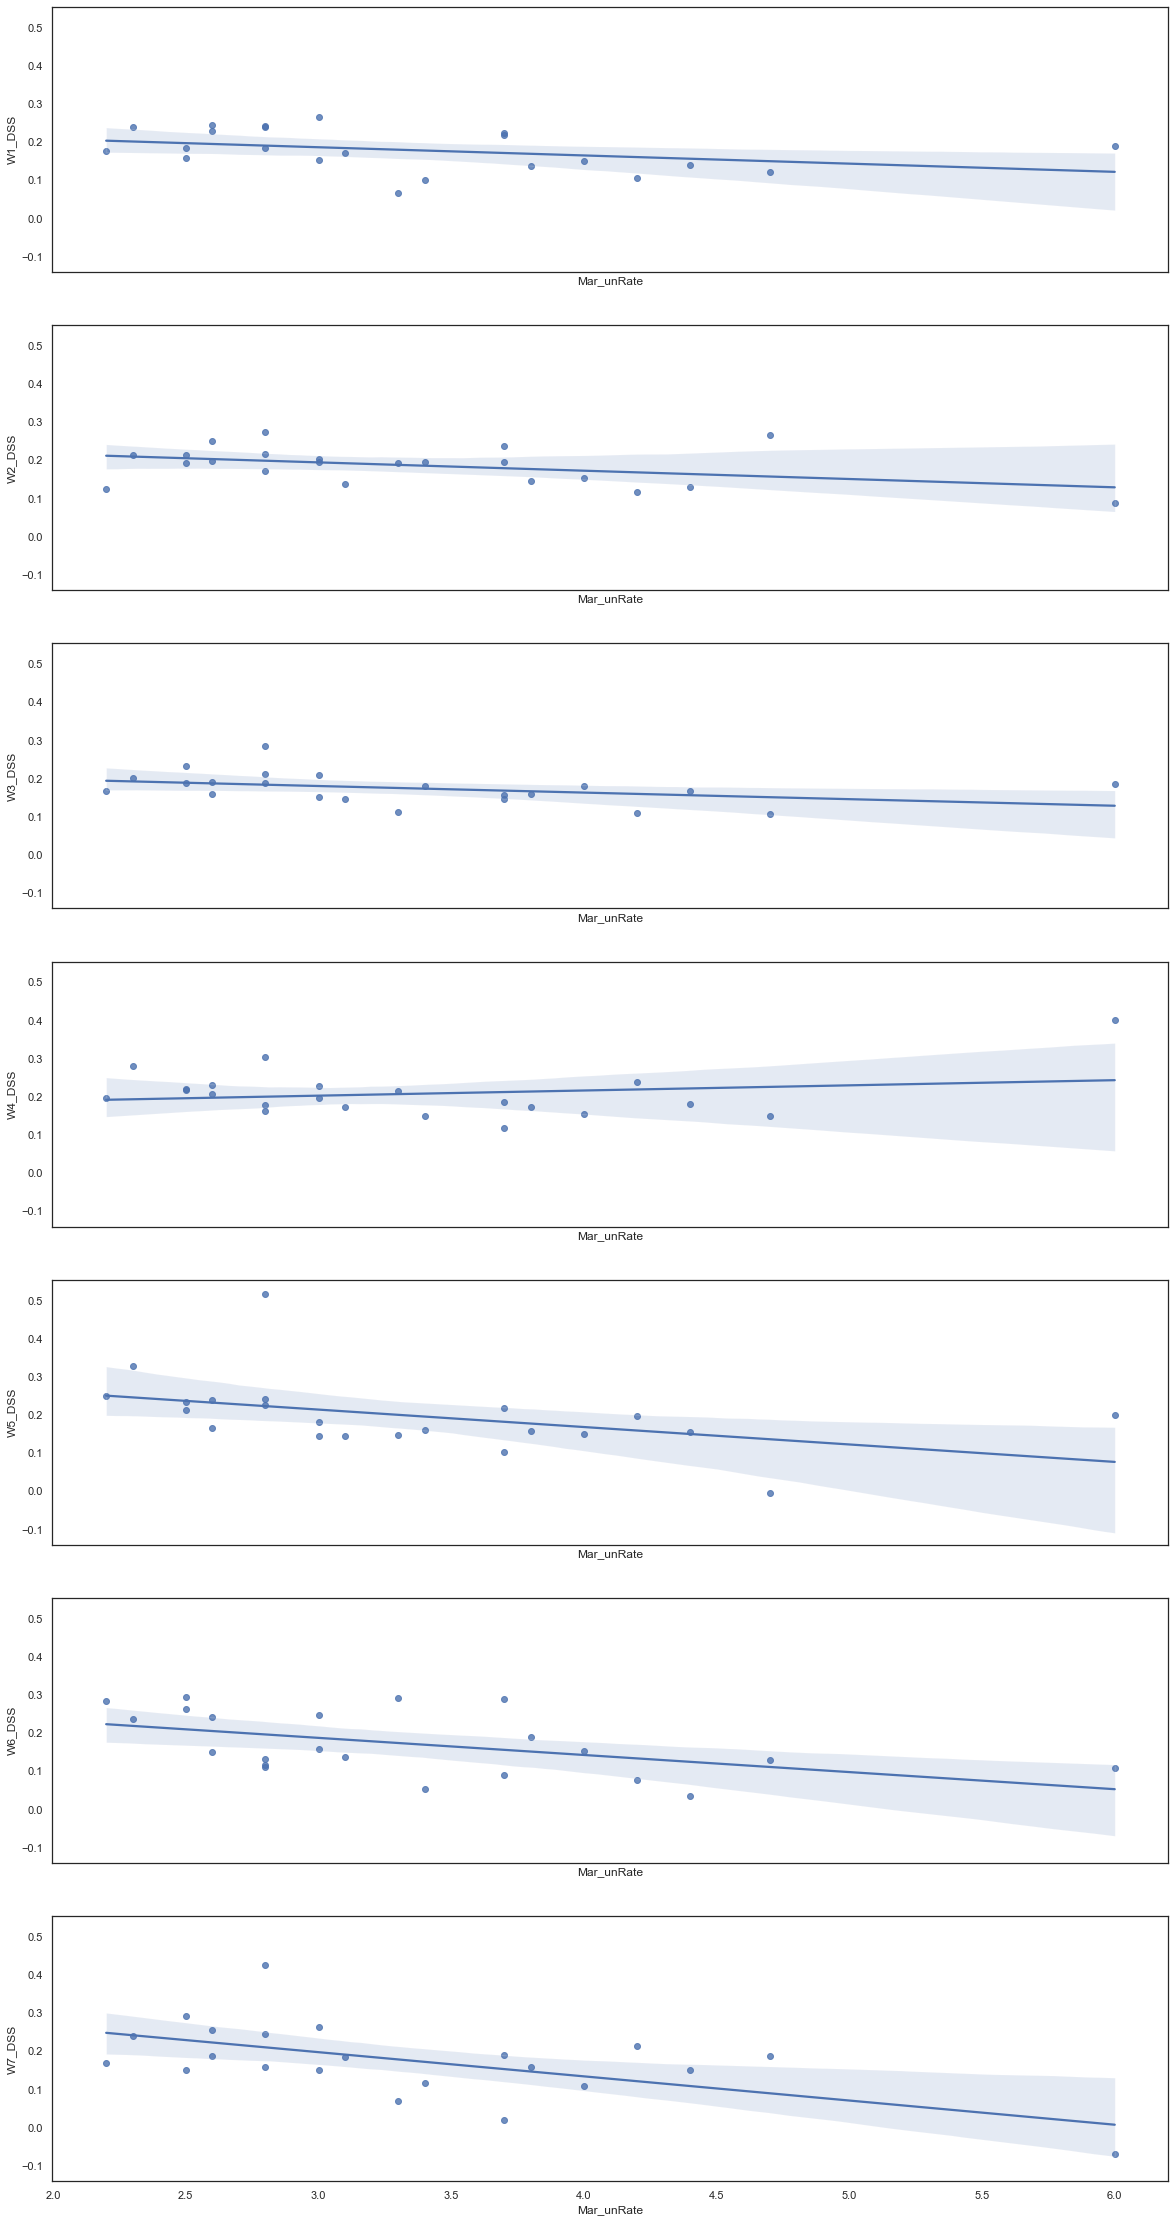

In [363]:
f, axes = plt.subplots(7, 1, figsize=(20, 40),  sharey=True, sharex=True)
ax = sns.regplot(x="Mar_unRate", y="W1_DSS", data=Week_DSS_unemployment, ax=axes[0])
sns.regplot(x="Mar_unRate", y="W2_DSS", data=Week_DSS_unemployment, ax=axes[1])
sns.regplot(x="Mar_unRate", y="W3_DSS", data=Week_DSS_unemployment, ax=axes[2])
sns.regplot(x="Mar_unRate", y="W4_DSS", data=Week_DSS_unemployment, ax=axes[3])
sns.regplot(x="Mar_unRate", y="W5_DSS", data=Week_DSS_unemployment, ax=axes[4])
sns.regplot(x="Mar_unRate", y="W6_DSS", data=Week_DSS_unemployment, ax=axes[5])
sns.regplot(x="Mar_unRate", y="W7_DSS", data=Week_DSS_unemployment, ax=axes[6])
plt.savefig("DSSbyMarchUnemploymentWeekly", tight_layout=False)

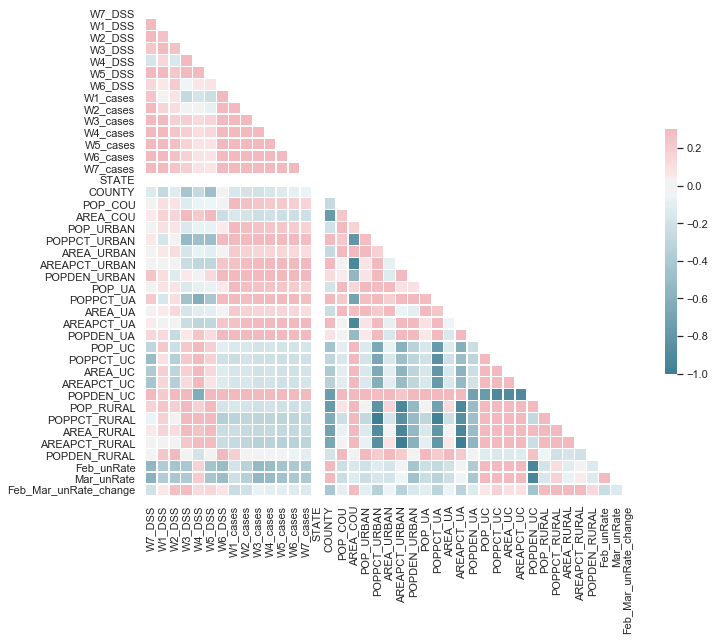

In [355]:
## Correlation plot
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = Week_DSS_unemployment

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [269]:
# Urban and Rural areas
urban_rural = pd.read_excel('PctUrbanRural_County.xls')
Week_DSS_stay_cases = pd.merge(Week_DSS_stay_cases, urban_rural, on='county_name')
Week_DSS_stay_deaths = pd.merge(Week_DSS_stay_deaths, urban_rural, on='county_name')

In [270]:
Week_DSS_stay_cases

county_name    W7_DSS    W1_DSS    W2_DSS    W3_DSS    W4_DSS  \
0   albemarle county       0.158320  0.239980  0.172556  0.212073  0.176660   
1   alexandria city        0.292481  0.184581  0.214665  0.187225  0.220633   
2   arlington county       0.169048  0.176709  0.125398  0.166903  0.196298   
3   chesapeake city        0.069514  0.065053  0.192335  0.112001  0.213533   
4   fairfax county         0.186865  0.245653  0.251150  0.190559  0.230255   
5   fairfax city           0.150347  0.156962  0.191670  0.231495  0.216481   
6   falls church city      0.239687  0.238121  0.214278  0.199776  0.280038   
7   fauquier county        0.245421  0.184926  0.273142  0.284980  0.303124   
8   fredericksburg city    0.191330  0.219246  0.237525  0.157712  0.186348   
9   hampton city           0.151216  0.138874  0.129878  0.165934  0.181261   
10  hanover county         0.426545  0.241682  0.215742  0.188849  0.161042   
11  loudoun county         0.256162  0.227548  0.198665  0.159406  0.205950   
12  manassas city          0.263953  0.264645  0.194935  0.208301  0.228373   
13  montgomery county      0.117327  0.100483  0.193901  0.180794  0.149283   
14  newport news city      0.212851  0.105962  0.117014  0.109949  0.239214   
15  norfolk city           0.109445  0.151025  0.153152  0.180544  0.153574   
16  prince william county  0.151760  0.152419  0.203134  0.151211  0.195930   
17  richmond city          0.159545  0.137883  0.146551  0.159119  0.172148   
18  roanoke city           0.020428  0.223176  0.194310  0.145141  0.118544   
19  virginia beach city    0.185288  0.171108  0.136664  0.147058  0.173550   
20  williamsburg city      0.187243  0.120487  0.265761  0.107921  0.149188   
21  wise county           -0.070396  0.189888  0.088691  0.184883  0.401878   

      W5_DSS    W6_DSS  W1_cases  W2_cases  ...  POP_UC  POPPCT_UC   AREA_UC  \
0   0.225976  0.131174  0.432514  0.535941  ...  5527    5.58       9035806    
1   0.212896  0.293465  1.265135  2.447206  ...  0       0.00       0          
2   0.248345  0.282729  1.578927  2.480555  ...  0       0.00       0          
3   0.146652  0.292714  0.508788  0.681187  ...  0       0.00       0          
4   0.239227  0.150832  0.881482  1.581945  ...  0       0.00       0          
5   0.232262  0.263233  0.041902  0.460926  ...  0       0.00       0          
6   0.327445  0.235752  0.000000  0.142177  ...  0       0.00       0          
7   0.517657  0.111736  0.361716  0.564277  ...  6625    10.16      9549672    
8   0.217022  0.290040  0.421511  0.597141  ...  0       0.00       0          
9   0.153805  0.034631  0.479411  0.612171  ...  0       0.00       0          
10  0.241726  0.116366  0.363814  0.804220  ...  0       0.00       0          
11  0.166217  0.241603  0.802299  1.103486  ...  13726   4.39       21529241   
12  0.181908  0.157676  0.820127  2.243288  ...  0       0.00       0          
13  0.160479  0.052033  0.326541  0.428585  ...  0       0.00       0          
14  0.196003  0.077957  0.432985  0.560659  ...  0       0.00       0          
15  0.150349  0.153785  0.366461  0.451969  ...  0       0.00       0          
16  0.144675  0.248211  0.851671  1.624525  ...  0       0.00       0          
17  0.157791  0.190395  0.688154  1.032232  ...  0       0.00       0          
18  0.101611  0.090942  0.200761  0.240913  ...  0       0.00       0          
19  0.143480  0.136219  0.539838  0.606485  ...  0       0.00       0          
20 -0.004577  0.128094  1.149581  1.284826  ...  0       0.00       0          
21  0.200157  0.107093  0.204997  0.461243  ...  17961   43.33      40723096   

    AREAPCT_UC  POPDEN_UC  POP_RURAL  POPPCT_RURAL  AREA_RURAL AREAPCT_RURAL  \
0   0.48        1584.2     44559      45.02         1794579885  96.14          
1   0.00       NaN         0          0.00          0           0.00           
2   0.00       NaN         0          0.00          0           0.00           
3   0.00       NaN         16948   

In [271]:
# Check weekly DSS average by urban/rural percentage
from scipy.stats import pearsonr
corr, pvalue = pearsonr(Week_DSS_stay_cases['W1_DSS'], Week_DSS_stay_cases['POPPCT_URBAN'])
print(f"Week 1: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W2_DSS'], Week_DSS_stay_cases['POPPCT_URBAN'])
print(f"Week 2: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W3_DSS'], Week_DSS_stay_cases['POPPCT_URBAN'])
print(f"Week 3: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W4_DSS'], Week_DSS_stay_cases['POPPCT_URBAN'])
print(f"Week 4: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W5_DSS'], Week_DSS_stay_cases['POPPCT_URBAN'])
print(f"Week 5: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W6_DSS'], Week_DSS_stay_cases['POPPCT_URBAN'])
print(f"Week 6: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W7_DSS'], Week_DSS_stay_cases['POPPCT_URBAN'])
print(f"Week 7: p-value: {pvalue} Pearsons correlation: %.3f" % corr)


Week 1: p-value: 0.4308602022983963 Pearsons correlation: -0.177
Week 2: p-value: 0.9352623131286635 Pearsons correlation: -0.018
Week 3: p-value: 0.014419118685256197 Pearsons correlation: -0.514
Week 4: p-value: 0.026260671748271205 Pearsons correlation: -0.473
Week 5: p-value: 0.02032324818757219 Pearsons correlation: -0.491
Week 6: p-value: 0.10667135829187485 Pearsons correlation: 0.353
Week 7: p-value: 0.8014984676357598 Pearsons correlation: 0.057


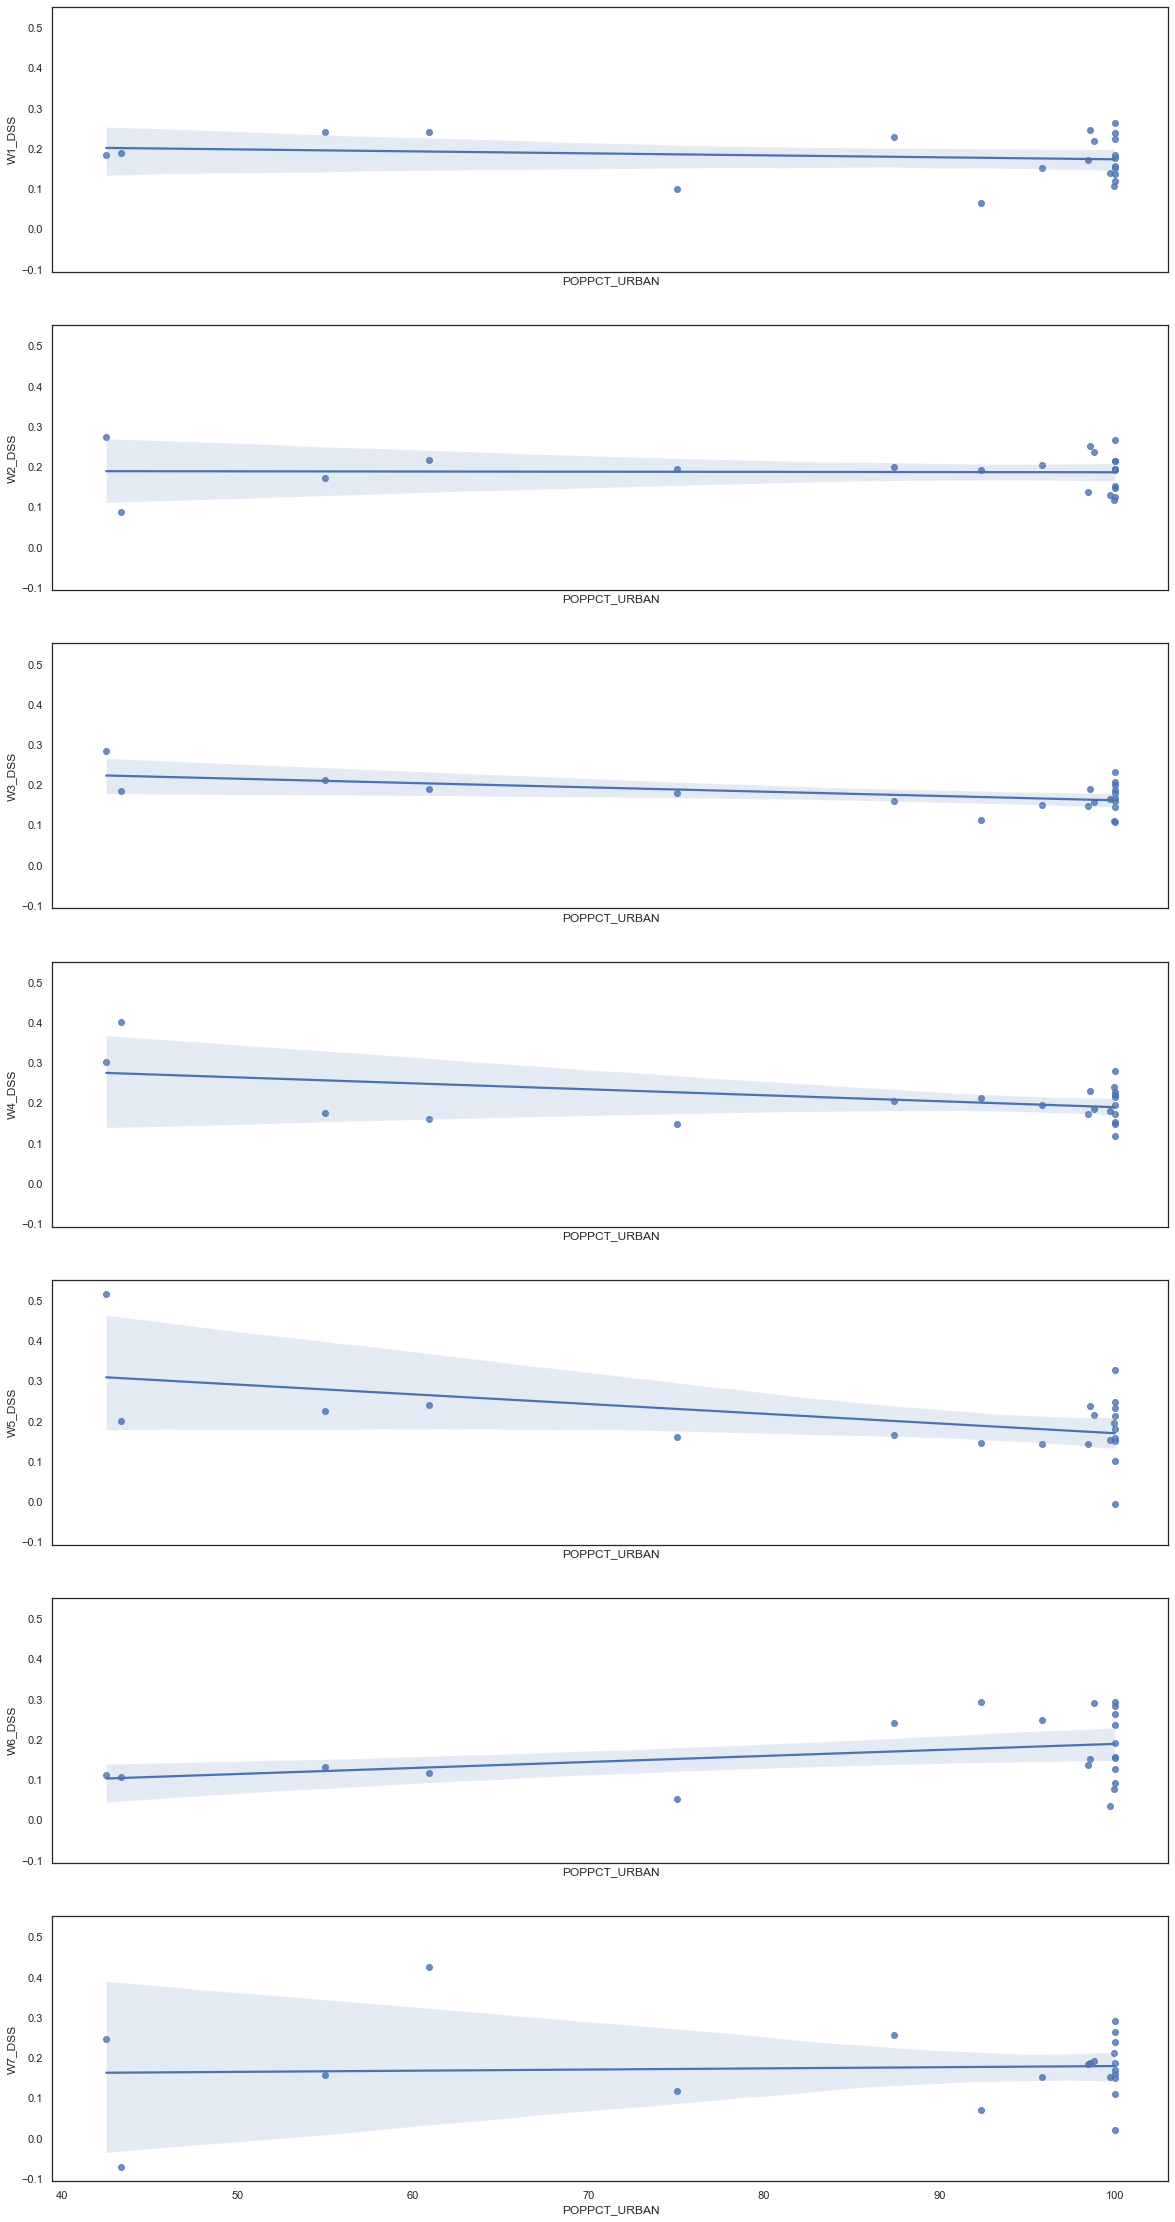

In [365]:
f, axes = plt.subplots(7, 1, figsize=(20, 40),  sharey=True, sharex=True)
ax = sns.regplot(x="POPPCT_URBAN", y="W1_DSS", data=Week_DSS_stay_cases, ax=axes[0])
sns.regplot(x="POPPCT_URBAN", y="W2_DSS", data=Week_DSS_stay_cases, ax=axes[1])
sns.regplot(x="POPPCT_URBAN", y="W3_DSS", data=Week_DSS_stay_cases, ax=axes[2])
sns.regplot(x="POPPCT_URBAN", y="W4_DSS", data=Week_DSS_stay_cases, ax=axes[3])
sns.regplot(x="POPPCT_URBAN", y="W5_DSS", data=Week_DSS_stay_cases, ax=axes[4])
sns.regplot(x="POPPCT_URBAN", y="W6_DSS", data=Week_DSS_stay_cases, ax=axes[5])
sns.regplot(x="POPPCT_URBAN", y="W7_DSS", data=Week_DSS_stay_cases, ax=axes[6])
plt.savefig("DSSbyPopUrbanWeekly", tight_layout=False)

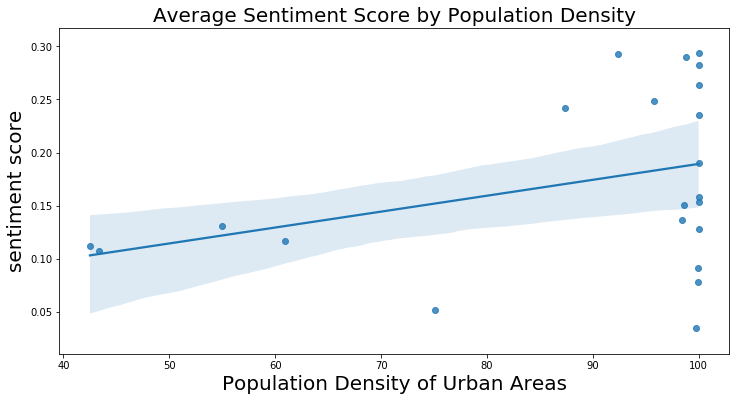

In [272]:
# Avg Weekly Sentiment Score by Percent Change
plt.figure(figsize=(12, 6))
ax = sns.regplot(x="POPPCT_URBAN", y="W6_DSS",
                     data=Week_DSS_stay_cases).set_title("Average Sentiment Score by Population Density",fontsize=20)
#plt.savefig("Neutral Tweets", tight_layout=False)
plt.xlabel("Population Density of Urban Areas", fontsize=20)
plt.ylabel("sentiment score", fontsize=20)
plt.show()

In [360]:
# Check weekly DSS average by cum cases per 1000
corr, pvalue = pearsonr(Week_DSS_stay_cases['W1_DSS'], Week_DSS_stay_cases['W1_cases'])
print(f"Week 1: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W2_DSS'], Week_DSS_stay_cases['W2_cases'])
print(f"Week 2: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W3_DSS'], Week_DSS_stay_cases['W3_cases'])
print(f"Week 3: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W4_DSS'], Week_DSS_stay_cases['W4_cases'])
print(f"Week 4: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W5_DSS'], Week_DSS_stay_cases['W5_cases'])
print(f"Week 5: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W6_DSS'], Week_DSS_stay_cases['W6_cases'])
print(f"Week 6: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_cases['W7_DSS'], Week_DSS_stay_cases['W7_cases'])
print(f"Week 7: p-value: {pvalue} Pearsons correlation: %.3f" % corr)



Week 1: p-value: 0.8724182701562583 Pearsons correlation: -0.036
Week 2: p-value: 0.6293142430676524 Pearsons correlation: 0.109
Week 3: p-value: 0.3824175597272452 Pearsons correlation: 0.196
Week 4: p-value: 0.6282106083563508 Pearsons correlation: 0.109
Week 5: p-value: 0.7178985284541776 Pearsons correlation: 0.082
Week 6: p-value: 0.06432520332728876 Pearsons correlation: 0.401
Week 7: p-value: 0.08687011843124699 Pearsons correlation: 0.373


In [274]:
# Check weekly DSS average by cum cases per 1000
corr, pvalue = pearsonr(Week_DSS_stay_deaths['W1_DSS'], Week_DSS_stay_deaths['W1_deaths'])
print(f"Week 1: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_deaths['W2_DSS'], Week_DSS_stay_deaths['W2_deaths'])
print(f"Week 2: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_deaths['W3_DSS'], Week_DSS_stay_deaths['W3_deaths'])
print(f"Week 3: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_deaths['W4_DSS'], Week_DSS_stay_deaths['W4_deaths'])
print(f"Week 4: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_deaths['W5_DSS'], Week_DSS_stay_deaths['W5_deaths'])
print(f"Week 5: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_deaths['W6_DSS'], Week_DSS_stay_deaths['W6_deaths'])
print(f"Week 6: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(Week_DSS_stay_deaths['W7_DSS'], Week_DSS_stay_deaths['W7_deaths'])
print(f"Week 7: p-value: {pvalue} Pearsons correlation: %.3f" % corr)


Week 1: p-value: 0.23824576208925405 Pearsons correlation: -0.262
Week 2: p-value: 0.6406370717132637 Pearsons correlation: -0.105
Week 3: p-value: 0.42359922751716067 Pearsons correlation: 0.180
Week 4: p-value: 0.5955159705172186 Pearsons correlation: 0.120
Week 5: p-value: 0.23358818884680993 Pearsons correlation: 0.265
Week 6: p-value: 0.06444216728154147 Pearsons correlation: 0.401
Week 7: p-value: 0.0999140948791483 Pearsons correlation: 0.360


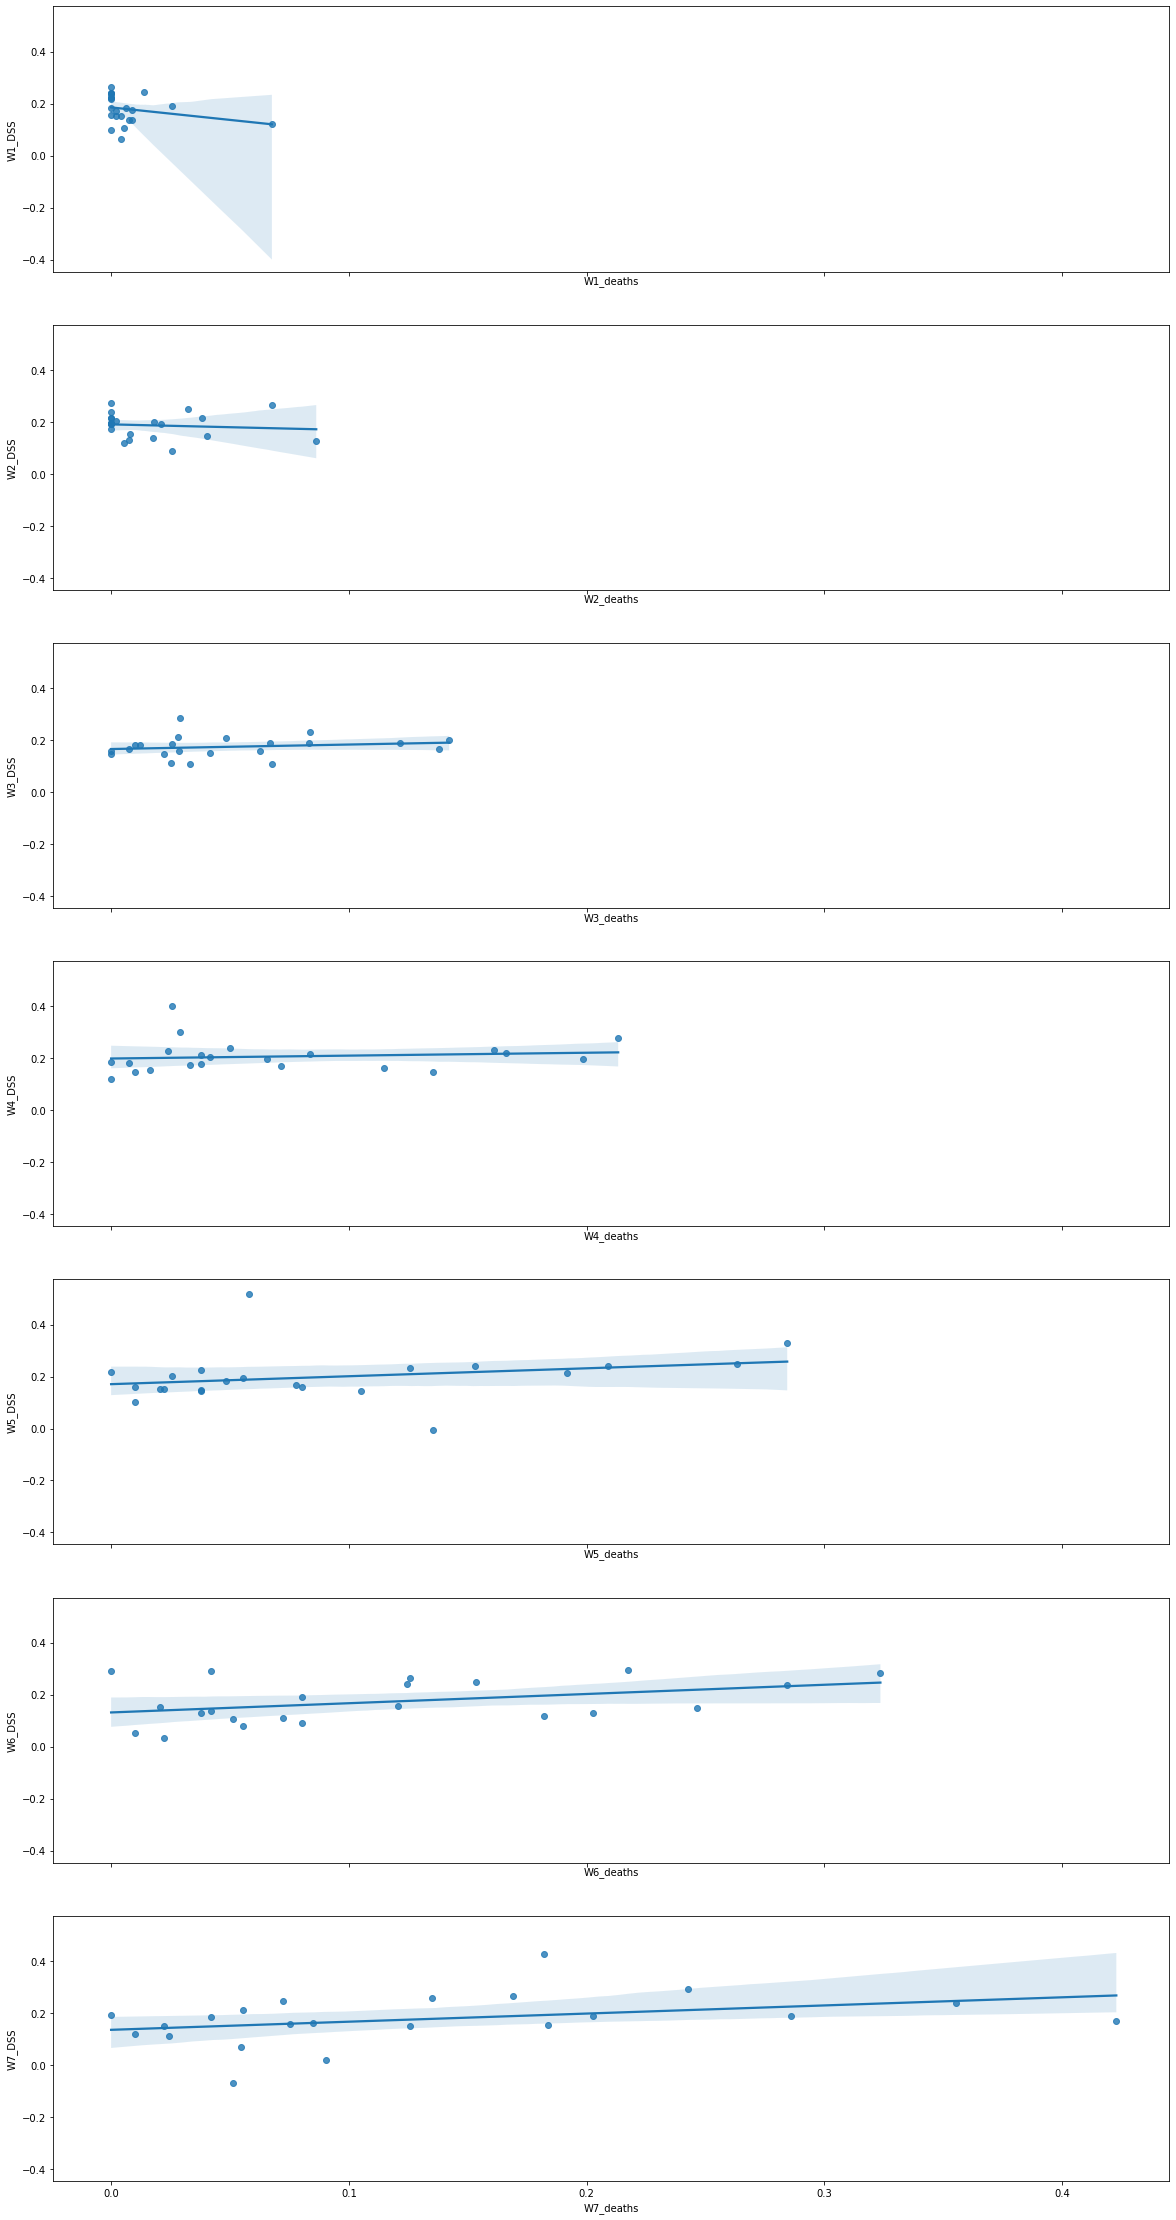

In [275]:
f, axes = plt.subplots(7, 1, figsize=(20, 40),  sharey=True, sharex=True)
ax = sns.regplot(x="W1_deaths", y="W1_DSS", data=Week_DSS_stay_deaths, ax=axes[0])
sns.regplot(x="W2_deaths", y="W2_DSS", data=Week_DSS_stay_deaths, ax=axes[1])
sns.regplot(x="W3_deaths", y="W3_DSS", data=Week_DSS_stay_deaths, ax=axes[2])
sns.regplot(x="W4_deaths", y="W4_DSS", data=Week_DSS_stay_deaths, ax=axes[3])
sns.regplot(x="W5_deaths", y="W5_DSS", data=Week_DSS_stay_deaths, ax=axes[4])
sns.regplot(x="W6_deaths", y="W6_DSS", data=Week_DSS_stay_deaths, ax=axes[5])
sns.regplot(x="W7_deaths", y="W7_DSS", data=Week_DSS_stay_deaths, ax=axes[6])
plt.savefig("DSSbyDeathsWeekly", tight_layout=False)



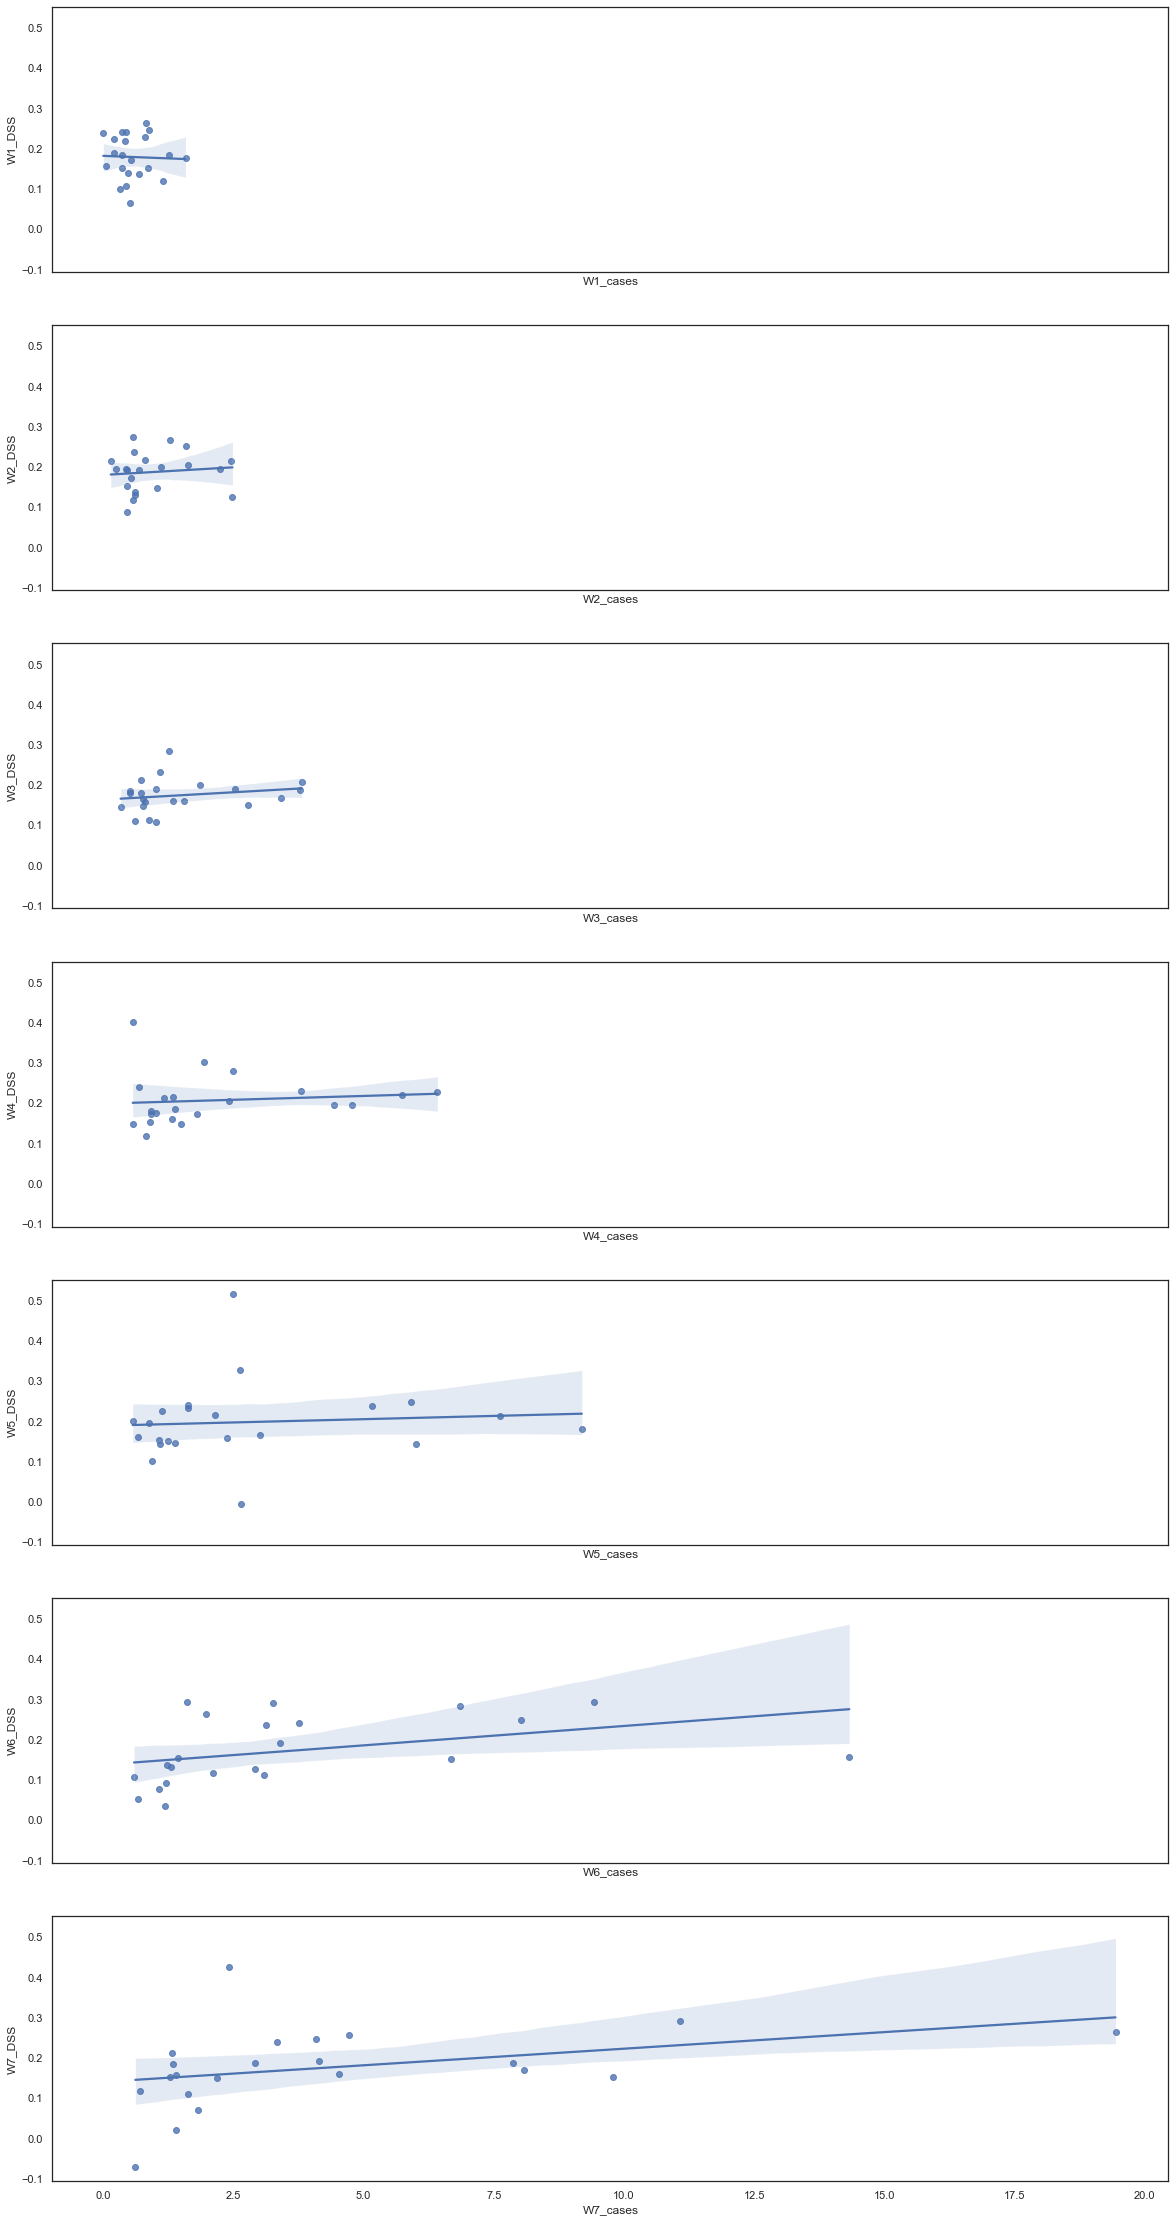

In [359]:
f, axes = plt.subplots(7, 1, figsize=(20, 40),  sharey=True, sharex=True)
ax = sns.regplot(x="W1_cases", y="W1_DSS", data=Week_DSS_stay_cases, ax=axes[0])
sns.regplot(x="W2_cases", y="W2_DSS", data=Week_DSS_stay_cases, ax=axes[1])
sns.regplot(x="W3_cases", y="W3_DSS", data=Week_DSS_stay_cases, ax=axes[2])
sns.regplot(x="W4_cases", y="W4_DSS", data=Week_DSS_stay_cases, ax=axes[3])
sns.regplot(x="W5_cases", y="W5_DSS", data=Week_DSS_stay_cases, ax=axes[4])
sns.regplot(x="W6_cases", y="W6_DSS", data=Week_DSS_stay_cases, ax=axes[5])
sns.regplot(x="W7_cases", y="W7_DSS", data=Week_DSS_stay_cases, ax=axes[6])
plt.savefig("DSSbyCasesWeekly", tight_layout=False)


In [298]:
# Do this whole analysis over again using overall_sent_STAY
overall_sent_STAY = pd.read_pickle('overall_sentiment_STAY.pickle')
overall_sent_STAY

index               user_id             status_id           created_at  \
0      54321  x174910916            x1248304027772891136  2020-04-09 17:37:27   
1      54355  x295761675            x1248290573980708864  2020-04-09 16:43:59   
2      54550  x136123969            x1248363319989329921  2020-04-09 21:33:03   
3      54645  x707817049880465408   x1248387330932523011  2020-04-09 23:08:28   
4      54784  x2375758213           x1248320847456153600  2020-04-09 18:44:17   
...      ...          ...                            ...                  ...   
28767  5986   x32935580             x1264349625907101697  2020-05-24 00:16:55   
28768  5992   x206283535            x1264349052755378177  2020-05-24 00:14:39   
28769  6003   x49790107             x1264347801640722442  2020-05-24 00:09:41   
28770  6010   x1221505468742410240  x1264347407757819910  2020-05-24 00:08:07   
28771  6019   x996093429246504960   x1264346786577223680  2020-05-24 00:05:39   

           screen_name  \
0      JonMcLain78       
1      engle_matthew     
2      daniellelaundon   
3      gwu_homo          
4      ashxeigh          
...         ...          
28767  ToraCarterMedia   
28768  waldojaquith      
28769  AlexaMQuinn       
28770  Nasterisk3        
28771  ImpactChurchNVA   

                                                                                                                                                                                                                                                               text  \
0      R Americans really stupid enough to think that if the curve is flattened, we can just go back to normal? C'mon! Disaster! We would be right back at square one. Let's do this until its GONE! #COVID19 #QuarantineLife #COVIDー19 #ThursdayThoughts #StayHome   
1      Social Distancing Day 27: our 14-year old son has taken to riding his little brother’s hoverboard in circles around the house. He calls the threshold to the kitchen “The Boulder Problem.” @AlexHonnold #elcap #SocialDistancing https://t.co/EfE4qUPqSu      
2      my number 1 quarantine position is replying to @mollyguild Instagram stories                                                                                                                                                                                   
3      Has you mental health been negatively impacted by quarantine?                                                                                                                                                                                                  
4      anyone in rva got ac*d i’m trying to transcend in quarantine                                                                                                                                                                                                   
...                                                             ...                                                                                                                                                                                                   
28767  One of the best parts of quarantine has been the long conversations I’ve had with my son. He’s is growing up to be such an outgoing, smart and creative young man.\n🥳\nNext month he will be graduating from fifth grade.… https://t.co/eS8G4SD3HS             
28768  My kids saw both a female summer tanager and a male scarlet tanager in the span of five minutes yesterday and you’d think they’d spotted a couple of celebrities. That’s high excitement in quarantine.                                                        
28769  @AmandaRafkin @evanbirnholz You need to get yourself a father-in-law who saves @evanbirnholz puzzles in a Manila folder. Quarantine highlight...but only 4 left 😱 https://t.co/We9Sum7aaf                                                                      
28770  Nothin but Ls this quarantine season. https://t.co/S7cbNZKyTq                       

In [299]:
count = overall_sent_STAY.groupby('county_name').count()
count = pd.DataFrame(count['text'])
count.reset_index(inplace = True)
count

county_name  text
0    accomack county    19  
1    albemarle county   1419
2    alexandria city    1695
3    alleghany county   7   
4    amelia county      16  
..             ...      ..  
122  williamsburg city  364 
123  winchester city    190 
124  wise county        196 
125  wythe county       12  
126  york county        120 

[127 rows x 2 columns]

In [300]:


count.reset_index(drop=True, inplace = True)
count.sort_values('text')



county_name  text
60   james city county      1   
82   northumberland county  2   
16   buckingham county      3   
11   bland county           3   
9    bath county            4   
..           ...           ..   
80   norfolk city           1719
7    arlington county       1746
36   fairfax county         1902
117  virginia beach city    2356
99   richmond city          5598

[127 rows x 2 columns]

In [301]:
# Map count of counties to dataframe
location_count_dict = dict(zip(count.county_name, count.text))
location_count_dict
overall_sent_STAY['count'] = overall_sent_STAY['county_name'].map(location_count_dict)

In [302]:
overall_sent_STAY = overall_sent_STAY[overall_sent_STAY['count'] >= 200]
overall_sent_STAY

index               user_id             status_id           created_at  \
1      54355  x295761675            x1248290573980708864  2020-04-09 16:43:59   
2      54550  x136123969            x1248363319989329921  2020-04-09 21:33:03   
3      54645  x707817049880465408   x1248387330932523011  2020-04-09 23:08:28   
4      54784  x2375758213           x1248320847456153600  2020-04-09 18:44:17   
5      55043  x1567051766           x1248359911605579776  2020-04-09 21:19:30   
...      ...          ...                            ...                  ...   
28767  5986   x32935580             x1264349625907101697  2020-05-24 00:16:55   
28768  5992   x206283535            x1264349052755378177  2020-05-24 00:14:39   
28769  6003   x49790107             x1264347801640722442  2020-05-24 00:09:41   
28770  6010   x1221505468742410240  x1264347407757819910  2020-05-24 00:08:07   
28771  6019   x996093429246504960   x1264346786577223680  2020-05-24 00:05:39   

           screen_name  \
1      engle_matthew     
2      daniellelaundon   
3      gwu_homo          
4      ashxeigh          
5      skh4102           
...        ...           
28767  ToraCarterMedia   
28768  waldojaquith      
28769  AlexaMQuinn       
28770  Nasterisk3        
28771  ImpactChurchNVA   

                                                                                                                                                                                                                                                            text  \
1      Social Distancing Day 27: our 14-year old son has taken to riding his little brother’s hoverboard in circles around the house. He calls the threshold to the kitchen “The Boulder Problem.” @AlexHonnold #elcap #SocialDistancing https://t.co/EfE4qUPqSu   
2      my number 1 quarantine position is replying to @mollyguild Instagram stories                                                                                                                                                                                
3      Has you mental health been negatively impacted by quarantine?                                                                                                                                                                                               
4      anyone in rva got ac*d i’m trying to transcend in quarantine                                                                                                                                                                                                
5      Quarantine Mood https://t.co/Q4oqUSyd9j                                                                                                                                                                                                                     
...                                        ...                                                                                                                                                                                                                     
28767  One of the best parts of quarantine has been the long conversations I’ve had with my son. He’s is growing up to be such an outgoing, smart and creative young man.\n🥳\nNext month he will be graduating from fifth grade.… https://t.co/eS8G4SD3HS          
28768  My kids saw both a female summer tanager and a male scarlet tanager in the span of five minutes yesterday and you’d think they’d spotted a couple of celebrities. That’s high excitement in quarantine.                                                     
28769  @AmandaRafkin @evanbirnholz You need to get yourself a father-in-law who saves @evanbirnholz puzzles in a Manila folder. Quarantine highlight...but only 4 left 😱 https://t.co/We9Sum7aaf                                                                   
28770  Nothin but Ls this quarantine season. https://t.co/S7cbNZKyTq                                                     

In [303]:
W11 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-09']
W12 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-10']
W13 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-11']
W14 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-12']
W21 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-13']
W22 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-14']
W23 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-15']
W24 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-16']
W25 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-17']
W26 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-18']
W27 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-19']
W31 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-20']
W32 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-21']
W33 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-22']
W34 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-23']
W35 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-24']
W36 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-25']
W37 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-26']
W41 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-27']
W42 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-28']
W43 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-29']
W44 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-04-30']
W45 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-01']
W46 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-02']
W47 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-03']
W51 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-04']
W52 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-05']
W53 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-06']
W54 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-07']
W55 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-08']
W56 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-09']
W57 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-10']
W61 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-11']
W62 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-12']
W63 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-13']
W64 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-14']
W65 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-15']
W66 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-16']
W67 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-17']
W71 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-18']
W72 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-19']
W73 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-20']
W74 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-21']
W75 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-22']
W76 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-23']
W77 = overall_sent_STAY[overall_sent_STAY['X1']=='2020-05-24']

In [304]:
WEEK1 = pd.concat([W11, W12, W13, W14], axis=0)
WEEK2 = pd.concat([W21, W22, W23, W24, W25, W26, W27], axis=0)
WEEK3 = pd.concat([W31, W32, W33, W34, W35, W36, W37], axis=0)
WEEK4 = pd.concat([W41, W42, W43, W44, W45, W46, W47], axis=0)
WEEK5 = pd.concat([W51, W52, W53, W54, W55, W56, W57], axis=0)
WEEK6 = pd.concat([W61, W62, W63, W62, W65, W66, W67], axis=0)
WEEK7 = pd.concat([W71, W72, W73, W74, W75, W76, W77], axis=0)


In [305]:
overall_sent_STAY.county_name.value_counts()

richmond city            5598
virginia beach city      2356
fairfax county           1902
arlington county         1746
norfolk city             1719
alexandria city          1695
loudoun county           1469
albemarle county         1419
fairfax city             673 
prince william county    655 
chesapeake city          650 
roanoke city             649 
newport news city        640 
montgomery county        614 
fredericksburg city      535 
hampton city             493 
lynchburg city           428 
williamsburg city        364 
chesterfield county      344 
harrisonburg city        339 
falls church city        302 
manassas city            293 
henrico county           207 
portsmouth city          200 
Name: county_name, dtype: int64

In [306]:
WEEK1 = WEEK1[['county_name', 'compound']]
WEEK1 = pd.DataFrame(WEEK1.groupby('county_name')['compound'].mean())
WEEK1.reset_index(inplace=True)
#WEEK1.columns=['county_name', 'week_1_sent']
WEEK1_urban_rural = pd.merge(WEEK1, urban_rural, on='county_name')
WEEK2 = WEEK2[['county_name', 'compound']]
WEEK2 = pd.DataFrame(WEEK2.groupby('county_name')['compound'].mean())
WEEK2.reset_index(inplace=True)
#WEEK2.columns=['county_name', 'week_2_sent']
WEEK2_urban_rural = pd.merge(WEEK2, urban_rural, on='county_name')
WEEK3 = WEEK3[['county_name', 'compound']]
WEEK3 = pd.DataFrame(WEEK3.groupby('county_name')['compound'].mean())
WEEK3.reset_index(inplace=True)
#WEEK3.columns=['county_name', 'week_3_sent']
WEEK3_urban_rural = pd.merge(WEEK3, urban_rural, on='county_name')
WEEK4 = WEEK4[['county_name', 'compound']]
WEEK4 = pd.DataFrame(WEEK4.groupby('county_name')['compound'].mean())
WEEK4.reset_index(inplace=True)
#WEEK4.columns=['county_name', 'week_4_sent']
WEEK4_urban_rural = pd.merge(WEEK4, urban_rural, on='county_name')
WEEK5 = WEEK5[['county_name', 'compound']]
WEEK5 = pd.DataFrame(WEEK5.groupby('county_name')['compound'].mean())
WEEK5.reset_index(inplace=True)
#WEEK5.columns=['county_name', 'week_5_sent']
WEEK5_urban_rural = pd.merge(WEEK5, urban_rural, on='county_name')
WEEK6 = WEEK6[['county_name', 'compound']]
WEEK6 = pd.DataFrame(WEEK6.groupby('county_name')['compound'].mean())
WEEK6.reset_index(inplace=True)
#WEEK6.columns=['county_name', 'week_6_sent']
WEEK6_urban_rural = pd.merge(WEEK6, urban_rural, on='county_name')
WEEK7 = WEEK7[['county_name', 'compound']]
WEEK7 = pd.DataFrame(WEEK7.groupby('county_name')['compound'].mean())
WEEK7.reset_index(inplace=True)
#WEEK7.columns=['county_name', 'week_7_sent']
WEEK7_urban_rural = pd.merge(WEEK7, urban_rural, on='county_name')


In [308]:
# Check weekly DSS average by percent urban
corr, pvalue = pearsonr(WEEK1_urban_rural['compound'], WEEK1_urban_rural['POPPCT_URBAN'])
print(f"Week 1: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(WEEK2_urban_rural['compound'], WEEK2_urban_rural['POPPCT_URBAN'])
print(f"Week 2: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(WEEK3_urban_rural['compound'], WEEK3_urban_rural['POPPCT_URBAN'])
print(f"Week 3: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(WEEK4_urban_rural['compound'], WEEK4_urban_rural['POPPCT_URBAN'])
print(f"Week 4: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(WEEK5_urban_rural['compound'], WEEK5_urban_rural['POPPCT_URBAN'])
print(f"Week 5: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(WEEK6_urban_rural['compound'], WEEK6_urban_rural['POPPCT_URBAN'])
print(f"Week 6: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(WEEK7_urban_rural['compound'], WEEK7_urban_rural['POPPCT_URBAN'])
print(f"Week 7: p-value: {pvalue} Pearsons correlation: %.3f" % corr)

Week 1: p-value: 0.7573131500146328 Pearsons correlation: -0.067
Week 2: p-value: 0.7123033263971076 Pearsons correlation: -0.079
Week 3: p-value: 0.6894936856990938 Pearsons correlation: -0.086
Week 4: p-value: 0.7423222394791685 Pearsons correlation: 0.071
Week 5: p-value: 0.9171884749061524 Pearsons correlation: -0.022
Week 6: p-value: 0.6049798808424136 Pearsons correlation: 0.111
Week 7: p-value: 0.42783345298618636 Pearsons correlation: 0.170


In [309]:
WEEK1 = WEEK1[['county_name', 'compound']]
WEEK1 = pd.DataFrame(WEEK1.groupby('county_name')['compound'].mean())
WEEK1.reset_index(inplace=True)
#WEEK1.columns=['county_name', 'week_1_sent']
WEEK1_deaths = pd.merge(WEEK1, Week1_deaths, on='county_name')
WEEK1_cases = pd.merge(WEEK1, Week1_cases, on='county_name')
WEEK2 = WEEK2[['county_name', 'compound']]
WEEK2 = pd.DataFrame(WEEK2.groupby('county_name')['compound'].mean())
WEEK2.reset_index(inplace=True)
#WEEK2.columns=['county_name', 'week_2_sent']
WEEK2_deaths = pd.merge(WEEK2, Week2_deaths, on='county_name')
WEEK2_cases = pd.merge(WEEK1, Week2_cases, on='county_name')
WEEK3 = WEEK3[['county_name', 'compound']]
WEEK3 = pd.DataFrame(WEEK3.groupby('county_name')['compound'].mean())
WEEK3.reset_index(inplace=True)
#WEEK3.columns=['county_name', 'week_3_sent']
WEEK3_deaths = pd.merge(WEEK3, Week3_deaths, on='county_name')
WEEK3_cases = pd.merge(WEEK1, Week3_cases, on='county_name')
WEEK4 = WEEK4[['county_name', 'compound']]
WEEK4 = pd.DataFrame(WEEK4.groupby('county_name')['compound'].mean())
WEEK4.reset_index(inplace=True)
#WEEK4.columns=['county_name', 'week_4_sent']
WEEK4_deaths = pd.merge(WEEK4, Week4_deaths, on='county_name')
WEEK4_cases = pd.merge(WEEK1, Week4_cases, on='county_name')
WEEK5 = WEEK5[['county_name', 'compound']]
WEEK5 = pd.DataFrame(WEEK5.groupby('county_name')['compound'].mean())
WEEK5.reset_index(inplace=True)
#WEEK5.columns=['county_name', 'week_5_sent']
WEEK5_deaths = pd.merge(WEEK5, Week5_deaths, on='county_name')
WEEK5_cases = pd.merge(WEEK5, Week5_cases, on='county_name')
WEEK6 = WEEK6[['county_name', 'compound']]
WEEK6 = pd.DataFrame(WEEK6.groupby('county_name')['compound'].mean())
WEEK6.reset_index(inplace=True)
#WEEK6.columns=['county_name', 'week_6_sent']
WEEK6_deaths = pd.merge(WEEK6, Week6_deaths, on='county_name')
WEEK6_cases = pd.merge(WEEK1, Week6_cases, on='county_name')
WEEK7 = WEEK7[['county_name', 'compound']]
WEEK7 = pd.DataFrame(WEEK7.groupby('county_name')['compound'].mean())
WEEK7.reset_index(inplace=True)
#WEEK7.columns=['county_name', 'week_7_sent']
WEEK7_deaths = pd.merge(WEEK7, Week7_deaths, on='county_name')
WEEK7_cases = pd.merge(WEEK1, Week7_cases, on='county_name')

In [315]:
# Check weekly DSS average by cum deaths per 1000
WEEK1_deaths.dropna(inplace=True)
WEEK2_deaths.dropna(inplace=True)
WEEK3_deaths.dropna(inplace=True)
WEEK4_deaths.dropna(inplace=True)
WEEK5_deaths.dropna(inplace=True)
WEEK6_deaths.dropna(inplace=True)
WEEK7_deaths.dropna(inplace=True)

corr, pvalue = pearsonr(WEEK1_deaths['compound'], WEEK1_deaths['W1_deaths'])
print(f"Week 1: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(WEEK2_deaths['compound'], WEEK2_deaths['W2_deaths'])
print(f"Week 2: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(WEEK3_deaths['compound'], WEEK3_deaths['W3_deaths'])
print(f"Week 3: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(WEEK4_deaths['compound'], WEEK4_deaths['W4_deaths'])
print(f"Week 4: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(WEEK5_deaths['compound'], WEEK5_deaths['W5_deaths'])
print(f"Week 5: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(WEEK6_deaths['compound'], WEEK6_deaths['W6_deaths'])
print(f"Week 6: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(WEEK7_deaths['compound'], WEEK7_deaths['W7_deaths'])
print(f"Week 7: p-value: {pvalue} Pearsons correlation: %.3f" % corr)

Week 1: p-value: 0.013719235326379685 Pearsons correlation: 0.506
Week 2: p-value: 0.6156035756226251 Pearsons correlation: -0.108
Week 3: p-value: 0.04203763773738275 Pearsons correlation: 0.418
Week 4: p-value: 0.8969107599741499 Pearsons correlation: -0.028
Week 5: p-value: 0.0036360811718143433 Pearsons correlation: 0.570
Week 6: p-value: 0.017779730318619222 Pearsons correlation: 0.479
Week 7: p-value: 0.7549377408105482 Pearsons correlation: -0.067


In [316]:
a = pd.DataFrame(WEEK1_deaths.county_name.value_counts())
len(a)

23

In [317]:
# Check weekly DSS average by cum deaths per 1000
WEEK1_cases.dropna(inplace=True)
WEEK2_cases.dropna(inplace=True)
WEEK3_cases.dropna(inplace=True)
WEEK4_cases.dropna(inplace=True)
WEEK5_cases.dropna(inplace=True)
WEEK6_cases.dropna(inplace=True)
WEEK7_cases.dropna(inplace=True)

corr, pvalue = pearsonr(WEEK1_cases['compound'], WEEK1_cases['W1_cases'])
print(f"Week 1: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(WEEK2_cases['compound'], WEEK2_cases['W2_cases'])
print(f"Week 2: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(WEEK3_cases['compound'], WEEK3_cases['W3_cases'])
print(f"Week 3: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(WEEK4_cases['compound'], WEEK4_cases['W4_cases'])
print(f"Week 4: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(WEEK5_cases['compound'], WEEK5_cases['W5_cases'])
print(f"Week 5: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(WEEK6_cases['compound'], WEEK6_cases['W6_cases'])
print(f"Week 6: p-value: {pvalue} Pearsons correlation: %.3f" % corr)
corr, pvalue = pearsonr(WEEK7_cases['compound'], WEEK7_cases['W7_cases'])
print(f"Week 7: p-value: {pvalue} Pearsons correlation: %.3f" % corr)

Week 1: p-value: 0.1670765607404783 Pearsons correlation: 0.298
Week 2: p-value: 0.2953615661080327 Pearsons correlation: 0.223
Week 3: p-value: 0.18217681511589132 Pearsons correlation: 0.282
Week 4: p-value: 0.16955537195350387 Pearsons correlation: 0.290
Week 5: p-value: 0.2097701287453485 Pearsons correlation: 0.266
Week 6: p-value: 0.13383106948725268 Pearsons correlation: 0.315
Week 7: p-value: 0.12445356895127554 Pearsons correlation: 0.322


## PCA of Daily Sentiment Score DSS

In [460]:
DSS_for_PCA = DSS.copy()
DSS_for_PCA.set_index('county_name', inplace=True)
DSS_for_PCA.drop(columns='NumOfTweets', inplace=True)
DSS_for_PCA.head()

04-09     04-10     04-11     04-12     04-13     04-14  \
county_name                                                                    
albemarle county  0.208548  0.218934  0.096576  0.435859  0.181924  0.208052   
alexandria city   0.247984  0.157452  0.067400  0.265487  0.156942  0.171026   
arlington county  0.188792  0.221108  0.108607  0.188327  0.042931  0.246063   
chesapeake city  -0.029179  0.085125  0.036553  0.167712  0.101784  0.225708   
fairfax county    0.175361  0.321613  0.111521  0.374118  0.212706  0.305508   

                     04-15     04-16     04-17     04-18  ...     05-15  \
county_name                                               ...             
albemarle county  0.240794  0.136757  0.282396  0.125352  ...  0.192977   
alexandria city   0.174680  0.146280  0.244980  0.350492  ...  0.286070   
arlington county  0.161408  0.060736  0.154576  0.110639  ...  0.356539   
chesapeake city   0.235862  0.167833  0.242148  0.028440  ...  0.325414   
fairfax county    0.291184  0.178503  0.256258  0.210031  ...  0.244800   

                     05-16     05-17     05-18     05-19     05-20     05-21  \
county_name                                                                    
albemarle county  0.169247  0.160211  0.080565  0.130743  0.093045  0.044236   
alexandria city   0.213204  0.369181  0.067927  0.332256  0.234461  0.312479   
arlington county  0.153052  0.532816  0.286538  0.187889  0.107577  0.099600   
chesapeake city   0.122177  0.448582  0.409600  0.039114  0.230767 -0.124780   
fairfax county    0.092648  0.039928  0.196235  0.222276  0.105030  0.210032   

                     05-22     05-23     05-24  
county_name                                     
albemarle county  0.234874  0.227718  0.297057  
alexandria city   0.418479  0.318287  0.363478  
arlington county  0.181563  0.015121  0.305045  
chesapeake city  -0.025657  0.023200 -0.065643  
fairfax county    0.246745  0.198971  0.128768  

[5 rows x 46 columns]

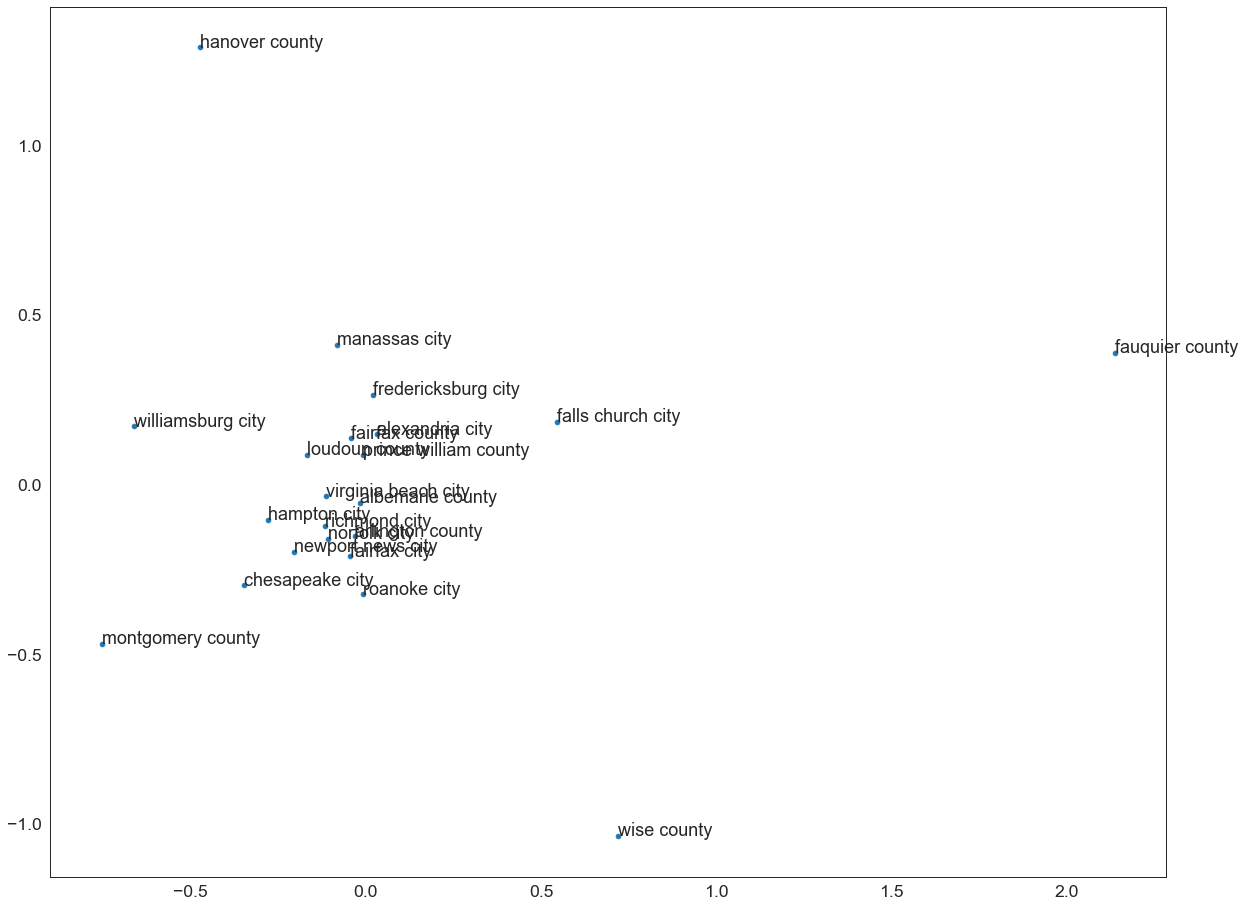

In [461]:
pca = PCA(n_components=2, random_state=RANDOM)
result = pca.fit_transform(DSS_for_PCA)
plt.figure(figsize = (20, 16))
plt.scatter(result[:, 0], result[:, 1])
words = list(DSS_for_PCA.index)
for i, word in enumerate(words):
    plt.annotate(word, size = 18, xy=(result[i, 0], result[i, 1]))
plt.show()

# Merged DSS Data

In [ ]:
# Create blank DSS Daily Sentiment Score
DSS_text = county_check
DSS_text.columns=['county_name']
DSS_text.head()

In [ ]:
date_list = [sent_0409, sent_0410, sent_0411, sent_0412, sent_0413, sent_0414, sent_0415, 
             sent_0416, sent_0417, sent_0418, sent_0419, sent_0420, sent_0421, sent_0422, sent_0423, sent_0424, 
             sent_0425, sent_0426, sent_0427, sent_0428, sent_0429, sent_0430, sent_0501, sent_0502, sent_0503,
             sent_0504, sent_0505, sent_0506, sent_0507, sent_0508, sent_0509, sent_0510, sent_0511, sent_0512,
            sent_0513, sent_0514]


In [ ]:
for i in date_list:
    DSS_text = pd.merge(DSS_text, i, on='county_name', how="left")

In [ ]:
DSS_text = pd.merge(DSS_text, freqs, on='county_name', how="left")
DSS_text.head()

In [ ]:
spotslyvania = pd.DataFrame(DSS_text[DSS_text['county_name']=='spotsylvania county'])
spotslyvania

In [ ]:
tazewell = pd.DataFrame(DSS_text[DSS_text['county_name']=='tazewell county'])
tazewell

# FOR REVIEW = Particular tweets from a county on a specific day

In [ ]:
# Select data for a specific count
data = merged_cleaned_data
data = data[data['county_name'] == 'petersburg city']
data

In [ ]:
data.screen_name.value_counts()

In [ ]:
# wise county was really low on /13
data = data_0513_clean
data = data[data['county_name'] == 'wise county']
data

In [ ]:
#### Word cloud ####
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
comment_words = ' '
stopwords = set(STOPWORDS) 
 
# iterate through the csv file 
for val in data.text:      
   # typecaste each val to string 
   val = str(val) 
   # split the value 
   tokens = val.split()     
   # Converts each token into lowercase 
   for i in range(len(tokens)): 
       tokens[i] = tokens[i].lower() 
         
   for words in tokens: 
       comment_words = comment_words + words + ' '
# words should all be same color and horizonal 
wordcloud = WordCloud(width = 1200, height = 800, 
               background_color ='white', 
               stopwords = stopwords,prefer_horizontal=1, color_func=lambda *args, **kwargs: "black",
               min_font_size = 10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('Petersburg City word cloud.png')
plt.show() 
